In [22]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")

from Miscellaneous_Tools.Handy_Functions.Unzip_Zip_Files import UnzipTrackJSONfile
from Movie_Analysis_Pipeline.Single_Movie_Processing.Server_Movies_Paths import GetMovieFilesPaths
from Local_Cell_Density_Project.SegClass_HDF_Output_Files.HDF_Format_New.HDF5_Data_Functions import GetCellCountPerFrame


Define how to calculate displacement between two cells:

In [23]:
def DistanceBetweenTwoPoints(x1, y1, x2, y2):
    """ Use Pythagorean Theorem to calculate displacement of two objects with known 'x' & 'y' coordinates. """
    return np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )


Create a class which will collect the data of division distances:

In [38]:
class AnaphaseNucleiDistance(object):

    def __init__(self, txt_file):
        """ Which tracks you want to take the zipped file from."""

        zipped_file = txt_file.replace("analysis/channel", "tracks/tracks").split("/cellIDdetails")[0] + ".zip"
        print ("Unzipping file {}".format(zipped_file))
        directory = UnzipTrackJSONfile(zipped_file=zipped_file)
        self.hdf5_file = directory.split("/tracks/")[0] + "/HDF/segmented.hdf5"

        if os.path.isdir(directory):
            if not directory.endswith("/"):
                directory += "/"

        self.directory = directory
        self.channel = directory.split("tracks_")[-1].split("/")[0]

        self.frames_of_interest = 5
        self.parent_child_1 = [[] for _ in range(self.frames_of_interest)]
        self.parent_child_2 = [[] for _ in range(self.frames_of_interest)]
        self.sibling_sibling = [[] for _ in range(self.frames_of_interest)]
        self.cell_count = []


    def CalculateAnaphaseDistancePerMovie(self):
        """ """

        print ("Processing directory: {}".format(self.directory))
        file_list = os.listdir(self.directory)

        for number, file in enumerate(sorted(file_list)):
            if number % 100 == 0:
                print ("Processing file #{} out of {} files...".format(number, len(file_list)))

            with open(self.directory + file) as json_file:
                data = json.load(json_file)

                if data['fate'] == "DIVIDE":
                    
                    #print ("Divides: {}".format(file))

                    x_p = float(data['x'][-1])
                    y_p = float(data['y'][-1])
                    children = [int(data['children'][0]), int(data['children'][1])]
                    frame_div = int(data['t'][-1])
                    cell_count = GetCellCountPerFrame(hdf5_file=self.hdf5_file, frame=frame_div)

                    x_c = [[] for _ in range(2)]
                    y_c = [[] for _ in range(2)]

                    #print ("Children: {}".format(children))
                    
                    for index, child in enumerate(children):
                        with open(self.directory + "track_{}_{}.json".format(child, self.channel)) as new_json_file:
                            new_data = json.load(new_json_file)

                            if int(new_data['length']) >= self.frames_of_interest:
                                counter = 0
                                while counter < self.frames_of_interest:
                                    x_c[index].append(float(new_data['x'][counter]))
                                    y_c[index].append(float(new_data['y'][counter]))
                                    counter += 1

                    if len(x_c[0]) == len(x_c[1]) == len(y_c[0]) == len(y_c[1]) == self.frames_of_interest:
                        for i in range(self.frames_of_interest):
                            dis_pc_1 = DistanceBetweenTwoPoints(x1=x_p, y1=y_p, x2=x_c[0][i], y2=y_c[0][i])
                            self.parent_child_1[i].append(dis_pc_1)
                            dis_pc_2 = DistanceBetweenTwoPoints(x1=x_p, y1=y_p, x2=x_c[1][i], y2=y_c[1][i])
                            self.parent_child_2[i].append(dis_pc_2)
                            dis_ss = DistanceBetweenTwoPoints(x1=x_c[0][i], y1=y_c[0][i], x2=x_c[1][i], y2=y_c[1][i])
                            self.sibling_sibling[i].append(dis_ss)
                        self.cell_count.append(cell_count)

        return self.cell_count, self.parent_child_1, self.parent_child_2, self.sibling_sibling


Done for file: /Volumes/lowegrp/Data/Kristina/MDCK_90WT_10Sc_NoComp/17_07_24/pos0/tracks/tracks_RFP.zip
/Volumes/lowegrp/Data/Kristina/MDCK_90WT_10Sc_NoComp/17_07_24/pos0/tracks/tracks_RFP/
Processing file #0 out of 3652 files...
Processing file #20 out of 3652 files...
Processing file #40 out of 3652 files...
Processing file #60 out of 3652 files...
Processing file #80 out of 3652 files...
Processing file #100 out of 3652 files...
Processing file #120 out of 3652 files...
Processing file #140 out of 3652 files...
Processing file #160 out of 3652 files...
Processing file #180 out of 3652 files...
Processing file #200 out of 3652 files...
Processing file #220 out of 3652 files...
Processing file #240 out of 3652 files...
Processing file #260 out of 3652 files...
Processing file #280 out of 3652 files...
Processing file #300 out of 3652 files...
Processing file #320 out of 3652 files...
Processing file #340 out of 3652 files...
Processing file #360 out of 3652 files...
Processing file #3

Groom the lists - append them continuously:

In [39]:
maxi_file_list = []

for exp_type in ["MDCK_WT_Pure", "MDCK_Sc_Tet-_Pure", "MDCK_90WT_10Sc_NoComp"]:
    call = GetMovieFilesPaths(exp_type=exp_type)
    txt_file_list = call.GetChannelTxtFiles(file_type="raw")
    for txt_file in txt_file_list:
        maxi_file_list.append(txt_file)


In [40]:
total_cell_count = list(range(2500))
total_parent_child = [[[] for _ in range(len(total_cell_count))] for _ in range(5)]
total_sibling_sibling = [[[] for _ in range(len(total_cell_count))] for _ in range(5)]

#maxi_file_list = ["/Volumes/lowegrp/Data/Kristina/MDCK_90WT_10Sc_NoComp/17_07_24/pos0/analysis/channel_RFP/cellIDdetails_raw.txt"]

for file in maxi_file_list:
    call_anaphase = AnaphaseNucleiDistance(txt_file=file)
    cell_count, parent_child_1, parent_child_2, sibling_sibling = call_anaphase.CalculateAnaphaseDistancePerMovie()
    
    for i in range(5):
        for cc, pc1, pc2, ss in zip(cell_count, parent_child_1[i], parent_child_2[i], sibling_sibling[i]):
            total_parent_child[i][cc].append(pc1)
            total_parent_child[i][cc].append(pc2)
            total_sibling_sibling[i][cc].append(ss)
    

Unzipping file /Volumes/lowegrp/Data/Kristina/MDCK_WT_Pure/17_07_24/pos7/tracks/tracks_GFP.zip
Done for file: /Volumes/lowegrp/Data/Kristina/MDCK_WT_Pure/17_07_24/pos7/tracks/tracks_GFP.zip
Processing directory: /Volumes/lowegrp/Data/Kristina/MDCK_WT_Pure/17_07_24/pos7/tracks/tracks_GFP/
Processing file #0 out of 10275 files...
Processing file #100 out of 10275 files...
Processing file #200 out of 10275 files...
Processing file #300 out of 10275 files...
Processing file #400 out of 10275 files...
Processing file #500 out of 10275 files...
Processing file #600 out of 10275 files...
Processing file #700 out of 10275 files...
Processing file #800 out of 10275 files...
Processing file #900 out of 10275 files...
Processing file #1000 out of 10275 files...
Processing file #1100 out of 10275 files...
Processing file #1200 out of 10275 files...
Processing file #1300 out of 10275 files...
Processing file #1400 out of 10275 files...
Processing file #1500 out of 10275 files...
Processing file #16

Processing file #7100 out of 10430 files...
Processing file #7200 out of 10430 files...
Processing file #7300 out of 10430 files...
Processing file #7400 out of 10430 files...
Processing file #7500 out of 10430 files...
Processing file #7600 out of 10430 files...
Processing file #7700 out of 10430 files...
Processing file #7800 out of 10430 files...
Processing file #7900 out of 10430 files...
Processing file #8000 out of 10430 files...
Processing file #8100 out of 10430 files...
Processing file #8200 out of 10430 files...
Processing file #8300 out of 10430 files...
Processing file #8400 out of 10430 files...
Processing file #8500 out of 10430 files...
Processing file #8600 out of 10430 files...
Processing file #8700 out of 10430 files...
Processing file #8800 out of 10430 files...
Processing file #8900 out of 10430 files...
Processing file #9000 out of 10430 files...
Processing file #9100 out of 10430 files...
Processing file #9200 out of 10430 files...
Processing file #9300 out of 104

Processing file #3100 out of 22002 files...
Processing file #3200 out of 22002 files...
Processing file #3300 out of 22002 files...
Processing file #3400 out of 22002 files...
Processing file #3500 out of 22002 files...
Processing file #3600 out of 22002 files...
Processing file #3700 out of 22002 files...
Processing file #3800 out of 22002 files...
Processing file #3900 out of 22002 files...
Processing file #4000 out of 22002 files...
Processing file #4100 out of 22002 files...
Processing file #4200 out of 22002 files...
Processing file #4300 out of 22002 files...
Processing file #4400 out of 22002 files...
Processing file #4500 out of 22002 files...
Processing file #4600 out of 22002 files...
Processing file #4700 out of 22002 files...
Processing file #4800 out of 22002 files...
Processing file #4900 out of 22002 files...
Processing file #5000 out of 22002 files...
Processing file #5100 out of 22002 files...
Processing file #5200 out of 22002 files...
Processing file #5300 out of 220

Processing file #21500 out of 22002 files...
Processing file #21600 out of 22002 files...
Processing file #21700 out of 22002 files...
Processing file #21800 out of 22002 files...
Processing file #21900 out of 22002 files...
Processing file #22000 out of 22002 files...
Unzipping file /Volumes/lowegrp/Data/Kristina/MDCK_WT_Pure/17_01_24/pos8/tracks/tracks_GFP.zip
Done for file: /Volumes/lowegrp/Data/Kristina/MDCK_WT_Pure/17_01_24/pos8/tracks/tracks_GFP.zip
Processing directory: /Volumes/lowegrp/Data/Kristina/MDCK_WT_Pure/17_01_24/pos8/tracks/tracks_GFP/
Processing file #0 out of 33333 files...
Processing file #100 out of 33333 files...
Processing file #200 out of 33333 files...
Processing file #300 out of 33333 files...
Processing file #400 out of 33333 files...
Processing file #500 out of 33333 files...
Processing file #600 out of 33333 files...
Processing file #700 out of 33333 files...
Processing file #800 out of 33333 files...
Processing file #900 out of 33333 files...
Processing fi

Processing file #17300 out of 33333 files...
Processing file #17400 out of 33333 files...
Processing file #17500 out of 33333 files...
Processing file #17600 out of 33333 files...
Processing file #17700 out of 33333 files...
Processing file #17800 out of 33333 files...
Processing file #17900 out of 33333 files...
Processing file #18000 out of 33333 files...
Processing file #18100 out of 33333 files...
Processing file #18200 out of 33333 files...
Processing file #18300 out of 33333 files...
Processing file #18400 out of 33333 files...
Processing file #18500 out of 33333 files...
Processing file #18600 out of 33333 files...
Processing file #18700 out of 33333 files...
Processing file #18800 out of 33333 files...
Processing file #18900 out of 33333 files...
Processing file #19000 out of 33333 files...
Processing file #19100 out of 33333 files...
Processing file #19200 out of 33333 files...
Processing file #19300 out of 33333 files...
Processing file #19400 out of 33333 files...
Processing

Processing file #1600 out of 29573 files...
Processing file #1700 out of 29573 files...
Processing file #1800 out of 29573 files...
Processing file #1900 out of 29573 files...
Processing file #2000 out of 29573 files...
Processing file #2100 out of 29573 files...
Processing file #2200 out of 29573 files...
Processing file #2300 out of 29573 files...
Processing file #2400 out of 29573 files...
Processing file #2500 out of 29573 files...
Processing file #2600 out of 29573 files...
Processing file #2700 out of 29573 files...
Processing file #2800 out of 29573 files...
Processing file #2900 out of 29573 files...
Processing file #3000 out of 29573 files...
Processing file #3100 out of 29573 files...
Processing file #3200 out of 29573 files...
Processing file #3300 out of 29573 files...
Processing file #3400 out of 29573 files...
Processing file #3500 out of 29573 files...
Processing file #3600 out of 29573 files...
Processing file #3700 out of 29573 files...
Processing file #3800 out of 295

Processing file #20000 out of 29573 files...
Processing file #20100 out of 29573 files...
Processing file #20200 out of 29573 files...
Processing file #20300 out of 29573 files...
Processing file #20400 out of 29573 files...
Processing file #20500 out of 29573 files...
Processing file #20600 out of 29573 files...
Processing file #20700 out of 29573 files...
Processing file #20800 out of 29573 files...
Processing file #20900 out of 29573 files...
Processing file #21000 out of 29573 files...
Processing file #21100 out of 29573 files...
Processing file #21200 out of 29573 files...
Processing file #21300 out of 29573 files...
Processing file #21400 out of 29573 files...
Processing file #21500 out of 29573 files...
Processing file #21600 out of 29573 files...
Processing file #21700 out of 29573 files...
Processing file #21800 out of 29573 files...
Processing file #21900 out of 29573 files...
Processing file #22000 out of 29573 files...
Processing file #22100 out of 29573 files...
Processing

Processing file #3600 out of 7192 files...
Processing file #3700 out of 7192 files...
Processing file #3800 out of 7192 files...
Processing file #3900 out of 7192 files...
Processing file #4000 out of 7192 files...
Processing file #4100 out of 7192 files...
Processing file #4200 out of 7192 files...
Processing file #4300 out of 7192 files...
Processing file #4400 out of 7192 files...
Processing file #4500 out of 7192 files...
Processing file #4600 out of 7192 files...
Processing file #4700 out of 7192 files...
Processing file #4800 out of 7192 files...
Processing file #4900 out of 7192 files...
Processing file #5000 out of 7192 files...
Processing file #5100 out of 7192 files...
Processing file #5200 out of 7192 files...
Processing file #5300 out of 7192 files...
Processing file #5400 out of 7192 files...
Processing file #5500 out of 7192 files...
Processing file #5600 out of 7192 files...
Processing file #5700 out of 7192 files...
Processing file #5800 out of 7192 files...
Processing 

Processing file #600 out of 12307 files...
Processing file #700 out of 12307 files...
Processing file #800 out of 12307 files...
Processing file #900 out of 12307 files...
Processing file #1000 out of 12307 files...
Processing file #1100 out of 12307 files...
Processing file #1200 out of 12307 files...
Processing file #1300 out of 12307 files...
Processing file #1400 out of 12307 files...
Processing file #1500 out of 12307 files...
Processing file #1600 out of 12307 files...
Processing file #1700 out of 12307 files...
Processing file #1800 out of 12307 files...
Processing file #1900 out of 12307 files...
Processing file #2000 out of 12307 files...
Processing file #2100 out of 12307 files...
Processing file #2200 out of 12307 files...
Processing file #2300 out of 12307 files...
Processing file #2400 out of 12307 files...
Processing file #2500 out of 12307 files...
Processing file #2600 out of 12307 files...
Processing file #2700 out of 12307 files...
Processing file #2800 out of 12307 f

Processing file #6200 out of 12058 files...
Processing file #6300 out of 12058 files...
Processing file #6400 out of 12058 files...
Processing file #6500 out of 12058 files...
Processing file #6600 out of 12058 files...
Processing file #6700 out of 12058 files...
Processing file #6800 out of 12058 files...
Processing file #6900 out of 12058 files...
Processing file #7000 out of 12058 files...
Processing file #7100 out of 12058 files...
Processing file #7200 out of 12058 files...
Processing file #7300 out of 12058 files...
Processing file #7400 out of 12058 files...
Processing file #7500 out of 12058 files...
Processing file #7600 out of 12058 files...
Processing file #7700 out of 12058 files...
Processing file #7800 out of 12058 files...
Processing file #7900 out of 12058 files...
Processing file #8000 out of 12058 files...
Processing file #8100 out of 12058 files...
Processing file #8200 out of 12058 files...
Processing file #8300 out of 12058 files...
Processing file #8400 out of 120

Processing file #300 out of 8198 files...
Processing file #400 out of 8198 files...
Processing file #500 out of 8198 files...
Processing file #600 out of 8198 files...
Processing file #700 out of 8198 files...
Processing file #800 out of 8198 files...
Processing file #900 out of 8198 files...
Processing file #1000 out of 8198 files...
Processing file #1100 out of 8198 files...
Processing file #1200 out of 8198 files...
Processing file #1300 out of 8198 files...
Processing file #1400 out of 8198 files...
Processing file #1500 out of 8198 files...
Processing file #1600 out of 8198 files...
Processing file #1700 out of 8198 files...
Processing file #1800 out of 8198 files...
Processing file #1900 out of 8198 files...
Processing file #2000 out of 8198 files...
Processing file #2100 out of 8198 files...
Processing file #2200 out of 8198 files...
Processing file #2300 out of 8198 files...
Processing file #2400 out of 8198 files...
Processing file #2500 out of 8198 files...
Processing file #2

Processing file #10300 out of 12384 files...
Processing file #10400 out of 12384 files...
Processing file #10500 out of 12384 files...
Processing file #10600 out of 12384 files...
Processing file #10700 out of 12384 files...
Processing file #10800 out of 12384 files...
Processing file #10900 out of 12384 files...
Processing file #11000 out of 12384 files...
Processing file #11100 out of 12384 files...
Processing file #11200 out of 12384 files...
Processing file #11300 out of 12384 files...
Processing file #11400 out of 12384 files...
Processing file #11500 out of 12384 files...
Processing file #11600 out of 12384 files...
Processing file #11700 out of 12384 files...
Processing file #11800 out of 12384 files...
Processing file #11900 out of 12384 files...
Processing file #12000 out of 12384 files...
Processing file #12100 out of 12384 files...
Processing file #12200 out of 12384 files...
Processing file #12300 out of 12384 files...
Unzipping file /Volumes/lowegrp/Data/Kristina/MDCK_WT_P

Processing file #0 out of 8815 files...
Processing file #100 out of 8815 files...
Processing file #200 out of 8815 files...
Processing file #300 out of 8815 files...
Processing file #400 out of 8815 files...
Processing file #500 out of 8815 files...
Processing file #600 out of 8815 files...
Processing file #700 out of 8815 files...
Processing file #800 out of 8815 files...
Processing file #900 out of 8815 files...
Processing file #1000 out of 8815 files...
Processing file #1100 out of 8815 files...
Processing file #1200 out of 8815 files...
Processing file #1300 out of 8815 files...
Processing file #1400 out of 8815 files...
Processing file #1500 out of 8815 files...
Processing file #1600 out of 8815 files...
Processing file #1700 out of 8815 files...
Processing file #1800 out of 8815 files...
Processing file #1900 out of 8815 files...
Processing file #2000 out of 8815 files...
Processing file #2100 out of 8815 files...
Processing file #2200 out of 8815 files...
Processing file #2300 o

Processing file #9400 out of 12957 files...
Processing file #9500 out of 12957 files...
Processing file #9600 out of 12957 files...
Processing file #9700 out of 12957 files...
Processing file #9800 out of 12957 files...
Processing file #9900 out of 12957 files...
Processing file #10000 out of 12957 files...
Processing file #10100 out of 12957 files...
Processing file #10200 out of 12957 files...
Processing file #10300 out of 12957 files...
Processing file #10400 out of 12957 files...
Processing file #10500 out of 12957 files...
Processing file #10600 out of 12957 files...
Processing file #10700 out of 12957 files...
Processing file #10800 out of 12957 files...
Processing file #10900 out of 12957 files...
Processing file #11000 out of 12957 files...
Processing file #11100 out of 12957 files...
Processing file #11200 out of 12957 files...
Processing file #11300 out of 12957 files...
Processing file #11400 out of 12957 files...
Processing file #11500 out of 12957 files...
Processing file 

Processing file #1700 out of 4608 files...
Processing file #1800 out of 4608 files...
Processing file #1900 out of 4608 files...
Processing file #2000 out of 4608 files...
Processing file #2100 out of 4608 files...
Processing file #2200 out of 4608 files...
Processing file #2300 out of 4608 files...
Processing file #2400 out of 4608 files...
Processing file #2500 out of 4608 files...
Processing file #2600 out of 4608 files...
Processing file #2700 out of 4608 files...
Processing file #2800 out of 4608 files...
Processing file #2900 out of 4608 files...
Processing file #3000 out of 4608 files...
Processing file #3100 out of 4608 files...
Processing file #3200 out of 4608 files...
Processing file #3300 out of 4608 files...
Processing file #3400 out of 4608 files...
Processing file #3500 out of 4608 files...
Processing file #3600 out of 4608 files...
Processing file #3700 out of 4608 files...
Processing file #3800 out of 4608 files...
Processing file #3900 out of 4608 files...
Processing 

Processing file #8500 out of 8867 files...
Processing file #8600 out of 8867 files...
Processing file #8700 out of 8867 files...
Processing file #8800 out of 8867 files...
Unzipping file /Volumes/lowegrp/Data/Kristina/MDCK_Sc_Tet-_Pure/17_04_24/pos6/tracks/tracks_RFP.zip
Done for file: /Volumes/lowegrp/Data/Kristina/MDCK_Sc_Tet-_Pure/17_04_24/pos6/tracks/tracks_RFP.zip
Processing directory: /Volumes/lowegrp/Data/Kristina/MDCK_Sc_Tet-_Pure/17_04_24/pos6/tracks/tracks_RFP/
Processing file #0 out of 10054 files...
Processing file #100 out of 10054 files...
Processing file #200 out of 10054 files...
Processing file #300 out of 10054 files...
Processing file #400 out of 10054 files...
Processing file #500 out of 10054 files...
Processing file #600 out of 10054 files...
Processing file #700 out of 10054 files...
Processing file #800 out of 10054 files...
Processing file #900 out of 10054 files...
Processing file #1000 out of 10054 files...
Processing file #1100 out of 10054 files...
Processi

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/lowegrp/Data/Kristina/MDCK_Sc_Tet-_Pure/17_03_06/pos12/tracks/tracks_RFP/'

Plot the dependence of distances for parent-child & sibling-sibling pairs on cell count (overlapping):

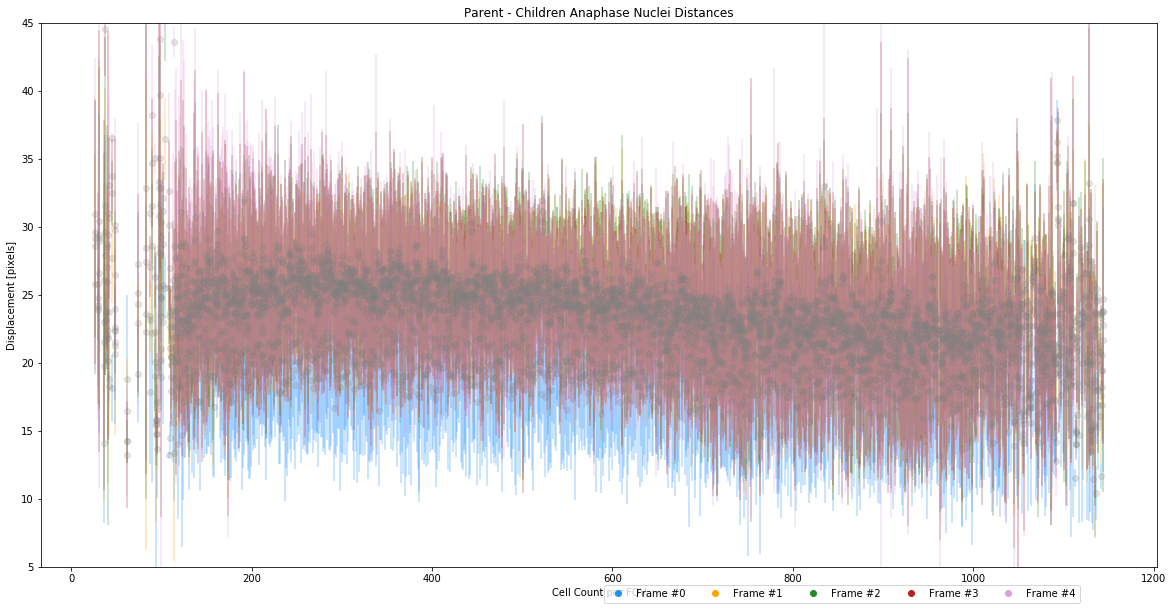

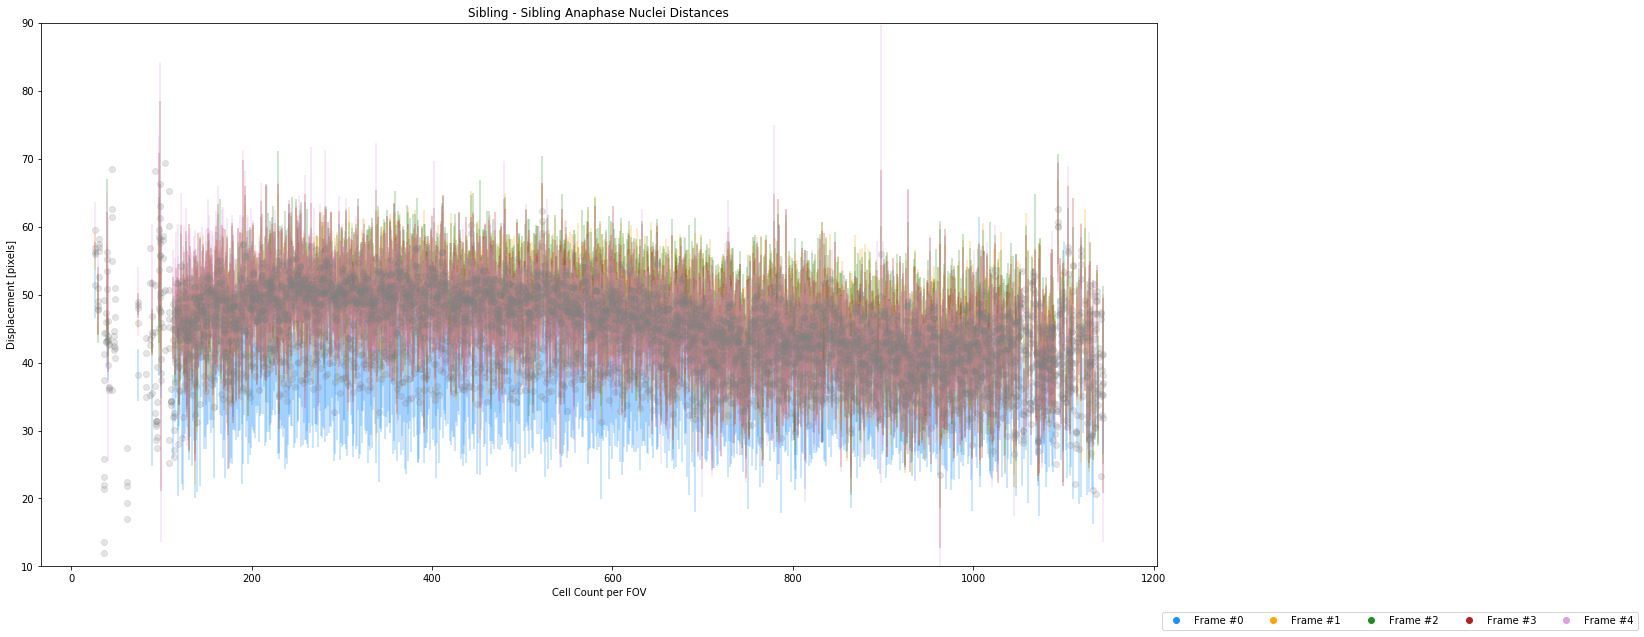

In [46]:
#print (total_cell_count)
#print (total_parent_child[0])
#print (total_sibling_sibling[0])

color_list = ["dodgerblue", "orange", "forestgreen", "firebrick", "plum"]

plt.figure(figsize=(20,10))

for frame in range(5):
    for cc, pc in zip(total_cell_count, total_parent_child[frame]):
        if pc:
            plt.errorbar(x=cc, y=np.mean(pc), yerr=np.std(pc), alpha=0.3, color=color_list[frame], zorder=0)
            plt.scatter(x=cc, y=np.mean(pc), alpha=0.2, color="grey", zorder=1)
    plt.plot([], [], "o", color=color_list[frame], label="Frame #{}".format(frame))
#plt.title("Parent - Children Anaphase Nuclei Distances at Frame #{}".format(frame))
plt.ylim(5, 45)
plt.title("Parent - Children Anaphase Nuclei Distances")
plt.ylabel("Displacement [pixels]")
plt.xlabel("Cell Count per FOV")
plt.savefig("/Volumes/lowegrp/Data/Kristina/Evolution_Distances/Anaphase_Parent_Child_Total_All_Movies.png".format(frame), bbox_inches = "tight")
plt.legend(loc='center left', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.show()
plt.close()



plt.figure(figsize=(20,10))

for frame in range(5):
    for cc, ss in zip(total_cell_count, total_sibling_sibling[frame]):
        if ss:
            plt.errorbar(x=cc, y=np.mean(ss), yerr=np.std(ss), alpha=0.3, color=color_list[frame], zorder=0)
            plt.scatter(x=cc, y=np.mean(ss), alpha=0.2, color="grey", zorder=1)
    plt.plot([], [], "o", color=color_list[frame], label="Frame #{}".format(frame))
#plt.title("Sibling - Sibling Anaphase Nuclei Distances at Frame #{}".format(frame))
plt.ylim(10, 90)
plt.title("Sibling - Sibling Anaphase Nuclei Distances")
plt.ylabel("Displacement [pixels]")
plt.xlabel("Cell Count per FOV")
plt.savefig("/Volumes/lowegrp/Data/Kristina/Evolution_Distances/Anaphase_Sibling_Sibling_Total_All_Movies.png".format(frame), bbox_inches = "tight")
plt.legend(loc='center left', bbox_to_anchor=(1, -0.1), ncol=5)
plt.show()
plt.close()


Plot the dependence of distances for parent-child & sibling-sibling pairs on cell count (separate):

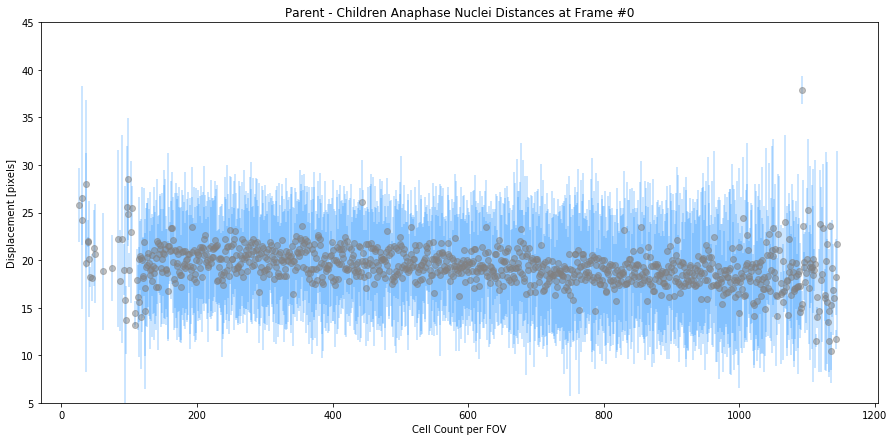

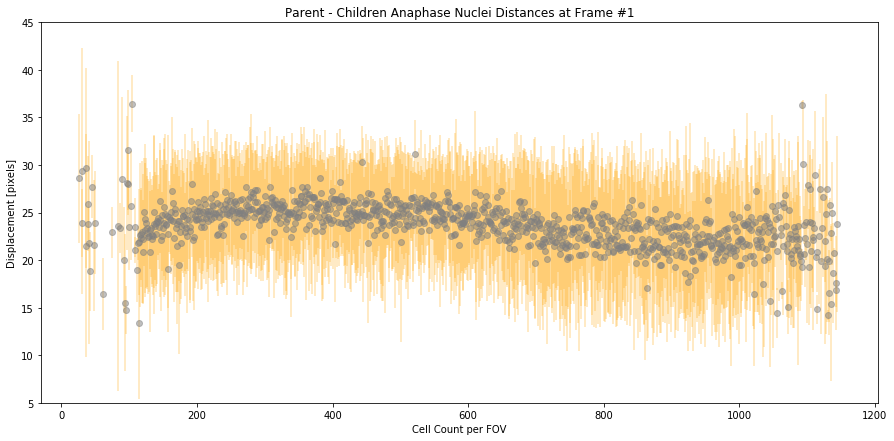

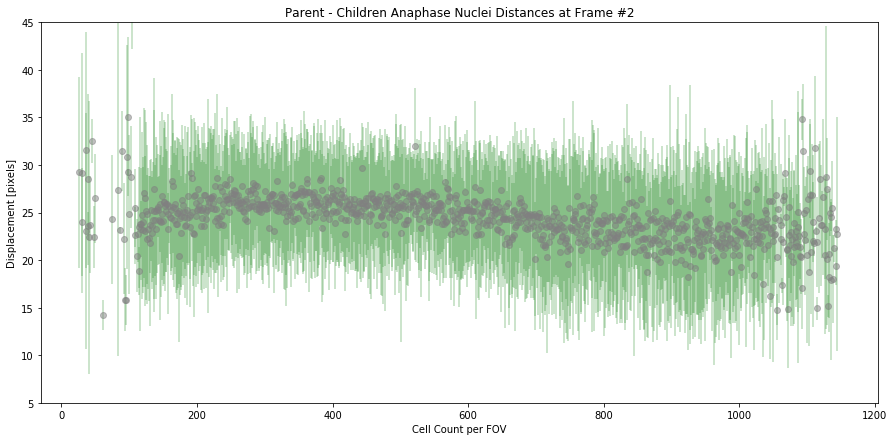

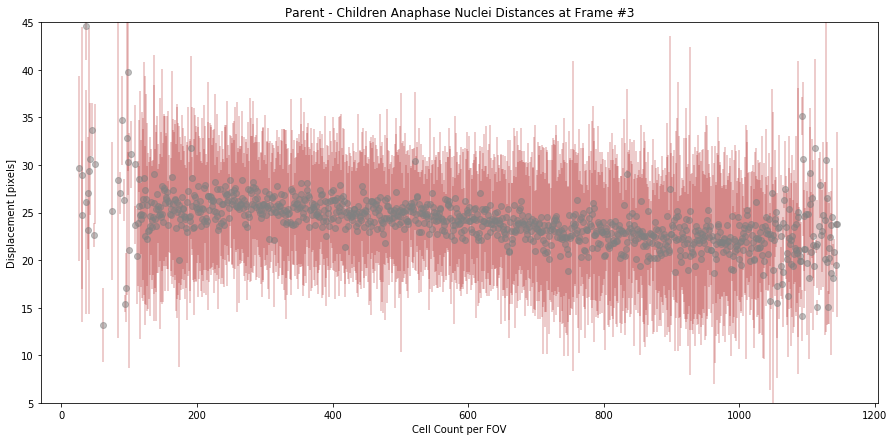

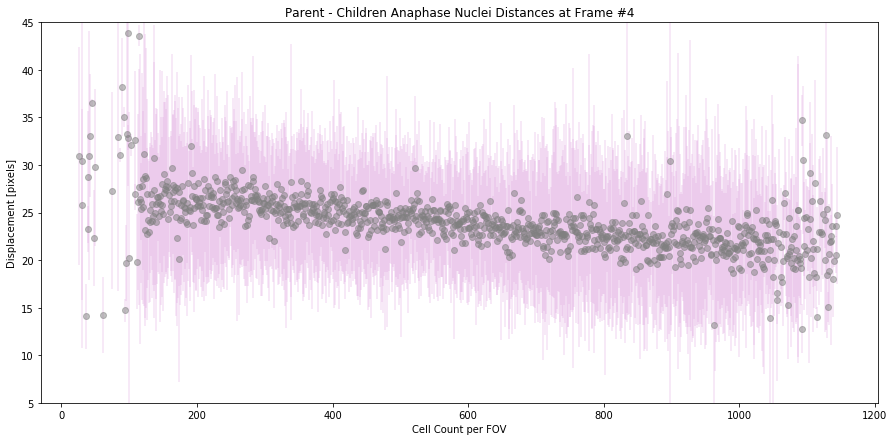

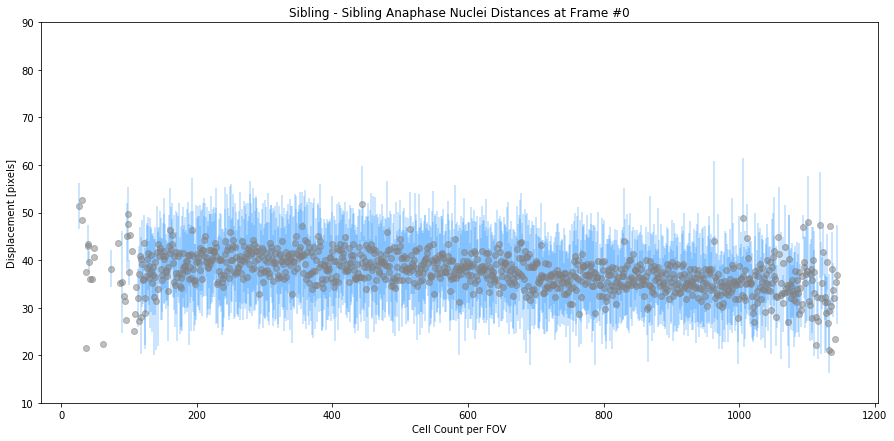

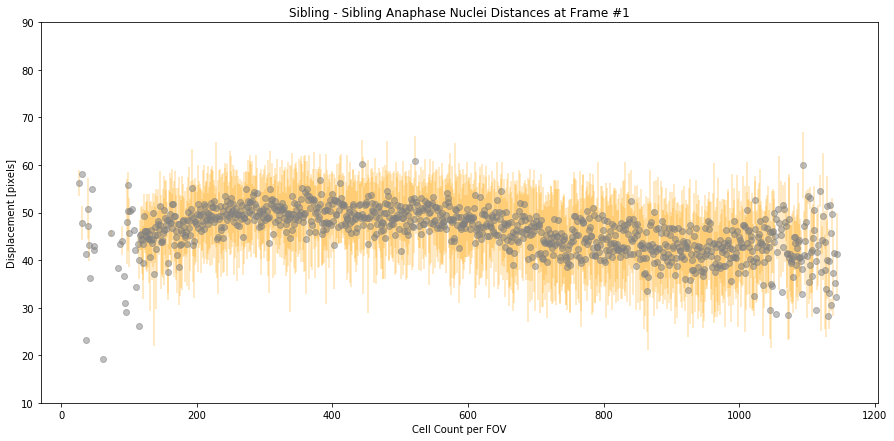

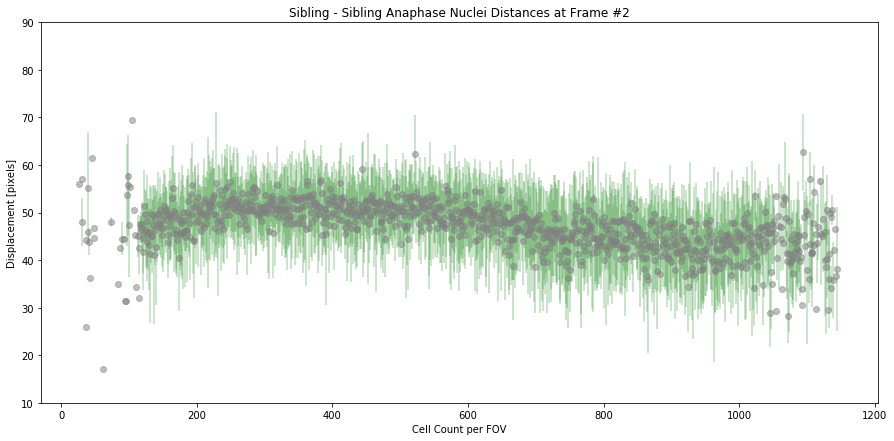

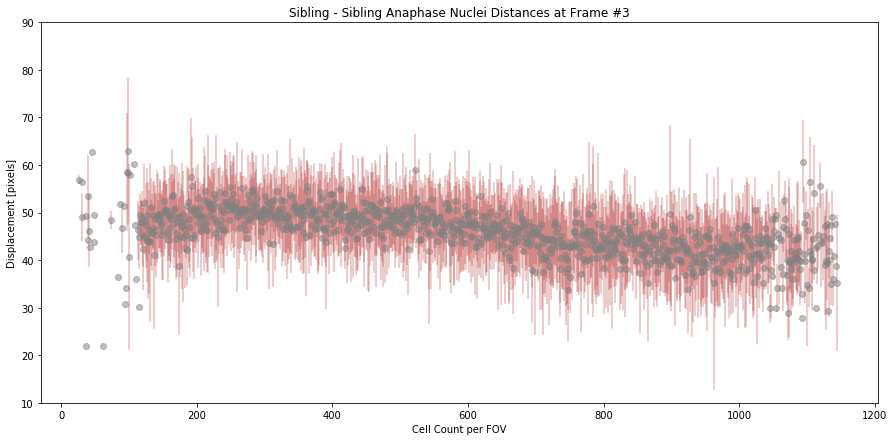

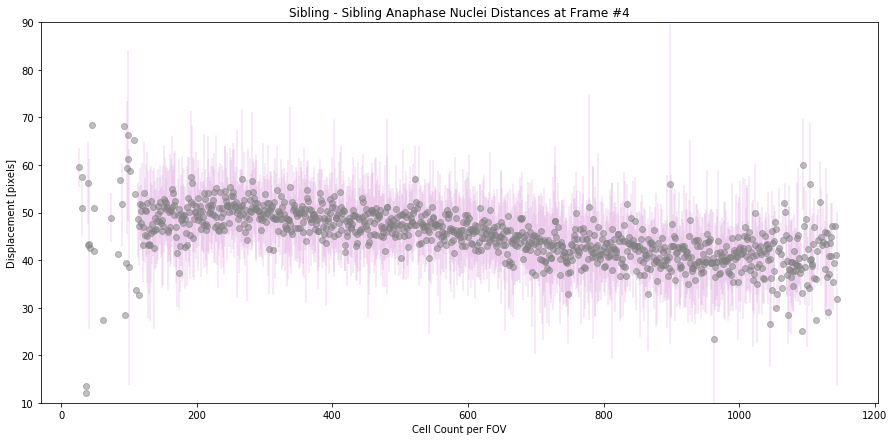

In [48]:
#print (total_cell_count)
#print (total_parent_child[0])
#print (total_sibling_sibling[0])

color_list = ["dodgerblue", "orange", "forestgreen", "firebrick", "plum"]


for frame in range(5):
    plt.figure(figsize=(15,7))
    for cc, pc in zip(total_cell_count, total_parent_child[frame]):
        if pc:
            plt.errorbar(x=cc, y=np.mean(pc), yerr=np.std(pc), alpha=0.3, color=color_list[frame], zorder=0)
            plt.scatter(x=cc, y=np.mean(pc), alpha=0.5, color="grey", zorder=1)
    #plt.plot([], [], "o", color=color_list[frame], label="Frame #{}".format(frame))
    plt.title("Parent - Children Anaphase Nuclei Distances at Frame #{}".format(frame))
    plt.ylim(5, 45)
    plt.ylabel("Displacement [pixels]")
    plt.xlabel("Cell Count per FOV")
    plt.savefig("/Volumes/lowegrp/Data/Kristina/Evolution_Distances/Anaphase_Parent_Child_Frame_{}_All_Movies.png".format(frame), bbox_inches = "tight")
    #plt.legend(loc='center left', bbox_to_anchor=(0.5, -0.05), ncol=5)
    plt.show()
    plt.close()



for frame in range(5):
    plt.figure(figsize=(15,7))
    for cc, ss in zip(total_cell_count, total_sibling_sibling[frame]):
        if ss:
            plt.errorbar(x=cc, y=np.mean(ss), yerr=np.std(ss), alpha=0.3, color=color_list[frame], zorder=0)
            plt.scatter(x=cc, y=np.mean(ss), alpha=0.5, color="grey", zorder=1)
    #plt.plot([], [], "o", color=color_list[frame], label="Frame #{}".format(frame))
    plt.title("Sibling - Sibling Anaphase Nuclei Distances at Frame #{}".format(frame))
    plt.ylim(10, 90)
    plt.ylabel("Displacement [pixels]")
    plt.xlabel("Cell Count per FOV")
    plt.savefig("/Volumes/lowegrp/Data/Kristina/Evolution_Distances/Anaphase_Sibling_Sibling_Frame_{}_All_Movies.png".format(frame), bbox_inches = "tight")
    #plt.legend(loc='center left', bbox_to_anchor=(1, -0.1), ncol=5)
    plt.show()
    plt.close()


In [13]:
#Processed channel GFP
cell_count_GFP = [1012, 1282, 624, 636, 453, 580, 566, 1270, 694, 711, 592, 621, 401, 610, 644, 699, 1296, 621, 596, 619, 422, 625, 584, 570, 357, 747, 582, 676, 789, 711, 863, 401, 442, 163, 644, 404, 1481, 403, 188, 580, 664, 815, 666, 676, 729, 816, 708, 792, 730, 813, 438, 803, 754, 244, 740, 676, 469, 188, 421, 1177, 789, 776, 701, 260, 224, 795, 426, 434, 891, 741, 824, 958, 791, 664, 1093, 836, 859, 968, 492, 1012, 819, 940, 1192, 540, 580, 621, 658, 1060, 1090, 1051, 578, 705, 1078, 1227, 916, 1027, 857, 831, 276, 1074, 625, 936, 1166, 1007, 1066, 1028, 571, 995, 1108, 338, 1078, 231, 1028, 802, 1082, 1041, 1113, 596, 1188, 922, 1082, 958, 1012, 1098, 1222, 1217, 432, 836, 803, 311, 263, 216, 1479, 244, 1149, 1432, 1237, 1152, 621, 1282, 1270, 749, 384, 295, 481, 1012, 1098, 323, 438, 1321, 1289, 1246, 208, 1296, 1274, 200, 233, 188, 339, 1270, 567, 341, 726, 726, 747, 799, 374, 740, 303, 1478, 1371, 290, 1280, 1372, 245, 859, 355, 1134, 795, 1314, 1364, 1378, 1299, 791, 236, 400, 291, 277, 620, 408, 218, 1065, 278, 815, 1467, 338, 837, 922, 213, 1487, 889, 1486, 1434, 913, 864, 1458, 422, 864, 876, 477, 1064, 894, 315, 381, 1449, 341, 216, 1469, 912, 991, 961, 1287, 912, 1487, 924, 1026, 1051, 936, 1078, 274, 533, 1265, 1368, 1335, 1051, 1455, 1078, 612, 1415, 1417, 1458, 1348, 622, 1108, 1113, 1196, 242, 1026, 1477, 1041, 1103, 242, 506, 1166, 256, 1081, 1444, 238, 230, 381, 1098, 385, 1481, 859, 1098, 1134, 1113, 656, 1108, 430, 1124, 1163, 436, 1279, 298, 265, 1170, 1477, 1169, 351, 255, 436, 602, 1354, 1469, 314, 1279, 1246, 1335, 383, 166, 426, 295, 1306, 1420, 304, 319, 389, 394, 1459, 1458, 1489, 155, 1454, 452, 1452, 266, 358, 1486, 338, 293, 484, 319, 1492, 1481, 295, 447, 510, 298, 338, 383, 521, 188, 465, 484, 366, 502, 515, 319, 400, 219, 368, 383, 557, 336, 625, 537, 307, 336, 1419, 584, 540, 557, 545, 356, 616, 496, 555, 588, 592, 574, 332, 588, 506, 218, 427]
parent_child_GFP = [[21.009929841476875, 24.016382233080385, 20.077476086223612, 8.601951701418148, 19.573710626949268, 18.409368493059453, 17.92117381210782, 18.863047409939448, 15.953076453898653, 16.937477857139324, 20.403602429041566, 20.51257749005277, 24.88449315158538, 19.606056155229304, 21.56762819686024, 37.55257692758869, 22.89418066388013, 27.040555042602655, 21.643699530368483, 31.255966914842546, 17.92904346308364, 15.67082395089121, 8.837901901796428, 20.307396148352105, 19.613083978123175, 12.637451480364124, 9.30731870556682, 11.85315037216626, 10.628614618982374, 12.032170910857888, 21.932218748866152, 22.545285343104503, 15.811514039415556, 14.255683109387233, 13.34982648202441, 18.689212876885076, 12.670926971256417, 14.207668531387556, 21.25351654085264, 22.099261313161527, 28.587852643124723, 20.83068668223933, 17.234279954418923, 16.827662842932032, 11.988254245045246, 33.8125852497387, 13.831812890792735, 15.80797572220392, 14.916256527031146, 23.811504384891997, 23.815998275128717, 27.653236999019793, 17.108034356629396, 33.48729790000583, 17.689610644534522, 30.26062250601471, 15.690783219584635, 22.081888335734863, 15.16863238535532, 13.998991811036015, 13.458387271263527, 9.68242948620271, 20.54084372832208, 23.20526714904563, 19.899702829309216, 23.487172496570846, 16.468391912664302, 6.356867250371303, 18.213665085170785, 20.641358396473347, 21.96784364418195, 17.323374910780014, 29.977713654324077, 26.283303835139346, 19.273320580217916, 24.14133771298353, 38.668402229713436, 18.866748156699177, 19.32037699675201, 20.489603626627158, 19.097586886623684, 17.828555636032892, 17.007587146295524, 14.18457226216472, 21.244762296984923, 22.40935322149536, 14.52275090175491, 26.317573836994104, 17.828812352423785, 26.78389451988871, 17.102299766824647, 16.82592729512079, 17.956556784801496, 22.09203016734908, 9.46212039485917, 12.86716872644126, 11.487712206556422, 19.871357511000053, 20.57508234200073, 22.45836462875423, 4.6420906219033995, 30.551400732169558, 27.705535908571974, 18.678331391309698, 27.730447422444033, 17.69211454865047, 12.630669161477845, 21.589375796163434, 21.706373234116217, 23.489996357574878, 22.24119580158426, 19.75793937155541, 8.147962076797988, 11.06061932559251, 17.141763276496942, 30.037547471781068, 14.20801763083884, 22.26207111790634, 24.908644164171097, 16.23311332303552, 23.39007957365929, 23.547852481192134, 15.48544173676148, 15.094446364128993, 20.05134803643854, 16.65012531471867, 13.688962662377158, 8.80125841460141, 14.787850718177909, 25.139721068309314, 22.025474716406382, 18.566048101008185, 22.967492127994355, 17.23923757728628, 24.121490130196452, 19.665037293692887, 12.398837702947247, 15.164260336513328, 11.102657434848053, 12.982008266598294, 18.57192862080362, 17.717329927529555, 14.740407886345709, 12.805575795903264, 17.0352816038335, 16.87330056006518, 16.391170675161373, 15.85890370385695, 16.886826768878638, 13.588815495726479, 15.49281259433233, 13.088112860681237, 17.035085182014637, 20.096057066626084, 19.80352895619127, 20.710702813846687, 14.252458249639899, 22.185112449921554, 16.315556336835666, 15.171600615033254, 22.957978156572555, 27.879042822137983, 23.864443121819882, 21.564952758609873, 13.283949232587782, 14.96912880341191, 18.246685543053943, 16.373837681829393, 16.497534278915012, 16.624896604134204, 21.184432441773808, 18.3131692088895, 18.09654012330526, 21.065613435370306, 15.490374742483285, 13.633096304818187, 23.773200140328964, 27.968339221168122, 19.48871436534312, 16.55097601280563, 24.938836128567424, 23.04230296132923, 13.994021953737116, 18.223290214382494, 17.959693501657025, 24.9451258701215, 20.487854244307194, 19.64179838722323, 18.024803755695384, 14.595743305100463, 14.384200323787276, 17.691416435860756, 22.813068799830145, 24.829957251728203, 2.401473270662241, 35.222608211941896, 15.026980232074104, 13.404529474085143, 20.14813985416144, 25.960211180893708, 28.3688230238222, 35.26804350233362, 17.13293904391712, 11.775001612463717, 26.22711553507556, 23.685476887060773, 9.970736905376066, 12.019643140395404, 12.522256173776647, 13.668267451486848, 24.31645732437653, 22.371858610203677, 27.159750593824228, 20.716221889948166, 13.949561366843877, 17.431743329597758, 17.870593202367537, 18.495197786840585, 12.399654682327693, 16.401268525208714, 20.630018893024435, 20.672780603703252, 20.07063594119823, 26.257618932980947, 15.928759134493433, 14.393512417646898, 17.955215076202055, 23.251855772720457, 14.232024389248277, 16.791585164409227, 14.416806442758888, 20.384353347341666, 36.42921880583748, 10.327538485184073, 37.57397369088358, 6.229306068520224, 24.738087681591733, 24.221290749283753, 14.929381435402043, 19.409143040460503, 26.792023066577112, 3.6344091885304297, 13.971812078625002, 15.419360904382748, 14.820531615863043, 11.163669001302846, 22.8932376980056, 23.37088455479739, 26.4170740417261, 21.69338241974691, 9.042881294192169, 7.870481199609598, 20.40194882406058, 25.31924846047263, 14.79648263073509, 15.198416912554006, 23.41905288056475, 27.082937258944796, 16.608537046815076, 10.782703332843466, 13.487939160917085, 22.803822602111396, 12.319864236040125, 18.641440903381348, 19.749872563826802, 20.114334463469902, 16.957921665504454, 6.646981532077556, 15.884781126392117, 17.681038979951246, 8.93955382611634, 11.2668013147977, 13.667838982628108, 18.096028362075007, 20.3150061209663, 28.50947748155083, 15.889442713566655, 11.920271482464976, 13.645377634808051, 12.007127051493683, 20.88408386447388, 25.550506681592086, 23.944012871504476, 19.47010412925525, 15.33510237240304, 12.294248164642946, 16.774275697927088, 18.153314445880866, 15.393793568992832, 19.1072722216332, 11.816741202036559, 13.044747869756355, 13.774955172189157, 10.24060082080073, 20.88120133879337, 13.590497989509496, 27.697831096718136, 24.897672999051792, 20.92833443198379, 18.429508959599517, 13.366630353671832, 14.181859883550887, 20.656894189403804, 13.84661524199804, 30.29839498673459, 13.565387364780719, 25.50348076141907, 20.32720894191735, 15.11299727918856, 14.98425200798332, 15.33850653678073, 19.348135152436942, 11.495004645277849, 18.01239901955871, 22.11262519261141, 34.381372507872534, 24.337509471047635, 23.289043499227187, 10.561469824377548, 8.844879948474919, 22.329720461652037, 19.41530487337555, 28.0913733423447, 20.54508071986331, 39.15569721956186, 0.9655363167913472, 18.204242368302644, 11.981884446407266, 16.16381433584176, 14.338970299600536, 22.29379451126221, 10.959938927978195, 19.60218674582524, 26.714119904385555, 1.125415748464224, 17.73459740549295, 19.51250475158548, 15.644334033313537, 19.77987940439025, 14.974929386611564, 19.908493932095986, 25.494056286085, 19.1499354625964, 25.78604623584628, 14.340123794728672, 20.472656141299144, 14.843613015502738, 22.866638001720887, 18.549067516118683, 28.181418561433958, 21.061982355509663, 21.190764780625187, 20.351274665601924, 2.591702662195116, 11.57585588042902, 10.332344183888058, 12.779598951668426, 15.692411161450893, 11.18685153879015, 9.477534157844092, 22.075035735151346, 19.18645216263275, 10.292149848201808, 8.964725333729298, 16.687560565583027, 13.356326929811937, 11.29768308070123, 37.26119055915148, 31.626370229048163, 15.264265879319854, 23.74872930126864, 20.512158466334196, 18.353502141925844, 27.759962965434873, 18.501378610334545, 18.39849913320018, 16.6815846747027, 15.003773739694484, 23.859234743339947, 25.694310351787422, 20.09616044192238, 18.045610448808137, 14.493821892512747, 17.329694180410574, 24.394741327150108, 23.194633190711965, 18.75373060237149, 15.329250271665124, 13.230594609633048, 16.610071611285218, 18.37784217122235, 33.740776233448656, 0.89680249610431, 35.70418302081176, 18.043735657671554, 17.251566951030934, 12.66134892230332, 38.018446337636206, 27.13406841320652, 14.613248429520294, 23.642377378500953, 20.15519633403857, 20.8393742967202, 21.543001636002757, 22.12701485581718, 10.764621168862282, 15.221374796627549, 14.713686786122507, 16.288931610990335, 14.683780046901354, 17.323996168510867, 27.224275979135214, 18.39856224027896, 27.03840621932217, 13.767321365311968, 8.622652481581513, 0.8936141051668669, 21.312599934294006, 23.779001822669148, 25.937343322057355, 24.954852427739272, 20.96856503663467, 21.27303900282084, 36.847454741714586, 21.96053177525947, 23.520592079850342, 13.904809102004537, 27.164166708690253, 7.944847882040806, 11.54381345653106, 22.266354054344003, 24.79922358325329, 11.12619407010611, 18.836373723222646, 8.51348110999871, 11.750688968706495, 21.215047071614023, 27.81827403200297, 17.32527386974696, 11.84028783462452, 15.182557155892603, 15.70655500448467, 23.08167449299745, 22.50345873278062, 14.92786593268991, 18.48979027531629, 21.216273478682417, 18.86473987049026, 19.030631223357194, 19.26633045418608, 11.804994719445673, 13.601889298960746, 23.25906234496753, 23.26790246495382, 26.492564966038323, 5.5907928465341366, 21.106433307514962, 23.847376980955488, 17.328254457929436, 17.432795824139262, 9.867709761283628, 16.50259206606968, 13.816723102183333, 14.317423506353698, 21.818021502764033, 20.46165669708599, 13.60379113824078, 24.297994867852296, 17.086944362509808, 16.875487843887697, 12.186472774313694, 38.461790503620875, 21.780539907287906, 20.170506589744132, 26.054842630019298, 20.029818583209, 14.38141487648626, 7.326539470297674, 24.911058017482045, 26.577056238987637, 19.670106487077327, 13.949790466562922, 14.793614646395516, 7.72047081660228, 8.914206966697195, 17.153160885863485, 3.5156359996888487, 13.710601862994714, 39.53337750797608, 3.134920710592605, 15.17128411076903, 14.234240394148461, 26.699863730375554, 18.375034880062696, 1.0849180032800152, 39.79725243466573, 14.456841904185984, 18.023283496585524, 32.359746264252394, 2.726096325182905, 24.039284667345864, 22.3270575743791, 21.618661902332402, 13.756781343108173, 17.771053456663136, 18.14542440796932, 13.563835555937226, 14.050191165066817, 10.313818658342573, 17.40846665938866, 14.096029848025688, 20.12916325970099, 37.843175562410096, 27.45667167057179, 22.491761651919436, 19.55254963111746, 16.77811370990731, 18.908443872421213, 25.157837670216324, 21.065318262761505, 5.731459079257267, 27.667256518124532, 19.945728673101634, 13.340356574526913, 37.634460516888154, 0.7598490474631674, 16.39441240452556, 13.223558660645384, 15.51233615734333, 1.1227816102849961, 15.352457661440525, 15.220033521894775, 2.053026072449983, 39.202725018104374, 20.43418127056485, 24.32662020063041, 13.597978306194424, 11.394409464779342, 25.353778831445304, 22.596332787757202, 38.36572981863499, 31.957293654797642, 30.66916122357865, 29.816302095855153, 24.14639784295939, 17.445843900360178, 13.79871500715365, 15.74029866723869, 11.779287660875355, 14.601794275493745, 28.03005304676294, 15.17972221998798, 38.641649858645245, 24.711821524604705, 18.350619115083433, 14.143325472775187, 38.82657241427588, 2.4383476631536807, 19.725108944528717, 22.049165970999802, 28.254632424236693, 19.40307233437797, 19.41728783284895, 14.486585008663925, 19.317218374357857, 13.933415791961156, 24.081829727149575, 32.75095634012021, 18.518378681883892, 15.080164350043981, 24.302696585539607, 29.309601972973585, 3.225603901636661, 23.596005048099794, 21.098774078892045, 27.74841192465445, 0.8492821971872075, 38.07036745888678, 22.59385329141871, 24.11388775336049, 16.348889760973886, 17.579665925945196, 19.127025710842375, 13.80072393794837, 15.632708244724352, 25.789972016533643, 16.460806457027093, 15.815861080924837, 24.670982486328157, 12.236101039109732, 18.731332399527055, 13.952145048140935, 15.474857849070611, 10.539393575415785, 13.814680852945152, 26.928773634034368, 15.149934643852365, 18.848459491403307, 25.787178771380592, 39.78241194378841, 18.420776335779756, 19.432833345598826, 0.7295413734777794, 31.476465000260536, 38.081828364450956, 7.0591577950961035, 1.3143823117117641, 31.041610575738364, 20.27251358191632, 16.431912671549735, 3.6906065168541593, 20.49012096137664, 8.711825794208542, 22.55215322480155, 9.925785329413415, 16.324233239643455, 30.352995962858174, 26.219859463493666, 11.334396341177289, 9.05693007605739, 21.332632497941454, 19.048012562072717, 19.537356300437224, 21.349827383047177, 23.79297316962871, 18.084946742255127, 32.69895298869137, 23.075005997349937, 38.487265040610204, 7.9970083783395385, 22.162936647471867, 15.42671262269526, 23.564459344315292, 17.049718412721457, 19.248513355002313, 21.769027077509254, 25.962676177265195, 17.98558843767584, 12.770057410878854, 21.768079263469854, 24.84434464570713, 19.51215805775356, 20.213000907826334, 21.209424568545572, 38.38625057098684, 14.713506738065126, 17.88302703002133, 17.44446674551047, 19.352984507544484, 20.06718090583631, 25.638534963868764, 29.04751405248943, 14.812660877375471, 9.60263886288809, 25.04681904298171, 23.175551553838815, 16.005525948148254, 26.230459405189727, 24.609480670512156, 30.354103244002708, 18.83300247707222, 28.40432250957192, 23.451005354489677, 21.21962937773393, 17.35258007050082, 6.9202746821666645, 22.02985983716971, 25.828682984675734, 9.735617143255482, 8.006968995832581, 10.314314289960889, 17.997627586763016, 14.353678100388919, 19.92945176767986, 4.802205998104727, 20.450704319801353, 12.395827297113817, 16.88306716631776, 14.787810090850321, 39.30577649629743, 9.808206818923397, 12.179140849750324, 15.149419663222343, 18.058652078755895, 8.504608924302296, 7.4094306347213115, 22.498361541941183, 29.096055600687478, 18.359154257766228, 16.685528358436695, 13.433243558146932, 11.494907406089057, 12.304751502658345, 15.34000722952976, 24.506263589797477, 26.681040954329404, 17.793639042075903, 21.048800336131492, 16.93066801087321, 19.762663965798378, 29.000613313635686, 24.294458125027973, 23.121359777039924, 17.79014854737219, 23.480871608834732, 21.602466362656298, 24.999718123505573, 23.55817984764016, 21.946701321790695, 15.224802166966091, 27.943572453639444, 18.960000323350286], [23.27989306321767, 26.607529553528416, 20.077476086223612, 19.638449415625, 23.677573062068276, 24.25049800010702, 25.830388409739342, 18.863047409939448, 24.61451291236011, 25.54112055454035, 26.057021078594143, 24.30370214911962, 27.22623696702135, 21.424091540524827, 36.18278575220552, 39.83543506990251, 26.595718490238685, 29.62387187567515, 22.301808688400595, 36.36672496207332, 27.77287780411368, 22.96041738163127, 17.258582288779024, 33.13060228150216, 19.613083978123175, 12.637451480364124, 22.174000184970737, 11.85315037216626, 10.628614618982374, 24.79394917490134, 22.96822587083454, 23.245311211796032, 27.96052156548623, 21.639090479659767, 19.48739390989362, 26.170535505751072, 23.804229153592015, 14.207668531387556, 25.843515004268163, 29.079754800194934, 31.976367845873025, 24.727756281515205, 24.90117150311384, 22.98236090204838, 17.975091536650943, 34.756554714791974, 25.66798704911832, 28.119089614539444, 13.746594537240078, 29.182266968028962, 25.440311307306967, 29.815289978867508, 16.120938403891454, 34.52116748696746, 24.41552882561371, 30.26062250601471, 15.690783219584635, 22.17656180418075, 27.37699870907375, 24.69513317146828, 30.393183053495722, 21.639359037889456, 25.425829752004063, 23.20526714904563, 24.890525784316456, 26.358515320383557, 32.43373528401063, 18.70812679405667, 20.268299273483166, 23.097030326198947, 25.551344603746227, 16.782236768643404, 26.78373008520636, 24.03997718217935, 23.11366814781935, 25.337852934367906, 41.00872261876278, 20.99921020571024, 24.474620612685083, 26.120503095613273, 26.822912112510704, 28.128231331582214, 17.007587146295524, 14.18457226216472, 26.200541400434044, 26.628335378110133, 13.617705790226747, 32.24198801013612, 18.505381872035635, 30.883725263808625, 24.77533791724024, 25.1721210127328, 24.26393893489282, 27.8174300776479, 19.127242842304742, 12.86716872644126, 11.487712206556422, 27.714665421066083, 25.02339230711459, 27.88533473036934, 4.269061492877946, 29.592312891471686, 32.46653545532618, 20.141414430084208, 26.521700338125854, 20.311570337460466, 19.057399868049828, 26.707769514625728, 23.53081973546571, 26.760665270508945, 26.39681273696121, 19.77983242704833, 17.906152881951662, 29.294515123388177, 22.057320023524177, 31.5075955744076, 21.428845445206175, 27.08814460877163, 20.45876651666131, 14.56660789113361, 24.50649265175042, 24.17562334909019, 15.48544173676148, 15.094446364128993, 27.147254743647732, 26.830184575864052, 13.688962662377158, 8.80125841460141, 18.257963167761318, 24.245386816470326, 27.608603904299997, 19.143413535810407, 30.167769296484913, 21.106506227059924, 24.121490130196452, 19.665037293692887, 20.757858489542492, 25.301468297536072, 22.749808400190474, 26.880242561077658, 27.41077294363676, 23.440783219845397, 27.57016775326175, 25.63799057504127, 23.437580233535922, 25.344487895513552, 16.391170675161373, 15.85890370385695, 28.427491510363506, 19.948660700290525, 25.09207000266052, 21.931571368890236, 22.23052842842374, 30.175256120763613, 22.63371312336515, 24.64000823509016, 16.313743831084913, 20.0288927925729, 25.814093888765292, 24.498475884068824, 23.464889736600405, 30.571732493028296, 28.767672257184937, 23.49157073786684, 19.801964307968724, 21.68984740956043, 17.758041858139624, 20.410081674409117, 16.342708435706125, 15.668966969811816, 27.357695885903258, 21.59185472116287, 18.09654012330526, 27.29065633545967, 25.005663172536796, 18.74903486708376, 23.84582252548317, 28.50913689319841, 27.100576590417887, 26.883806152661187, 24.938836128567424, 23.15524823910298, 14.599548400553527, 17.561544915348016, 24.12464882343816, 24.85268350173092, 23.702620474592106, 24.758941013840538, 21.278269266336007, 14.906117882749797, 16.235902548703034, 15.717948353965241, 24.269870450653812, 27.373961956955068, 2.401473270662241, 35.222608211941896, 23.92852011541348, 21.66480994259224, 22.43200772208865, 26.36429427097373, 29.119982316870153, 34.31621021526589, 17.13293904391712, 20.088992696971488, 27.26114057768732, 23.21614562681087, 9.970736905376066, 12.019643140395404, 12.522256173776647, 20.42823690220676, 24.31645732437653, 22.371858610203677, 27.159750593824228, 23.50120239837363, 13.949561366843877, 17.431743329597758, 24.95459175384163, 25.13323132481437, 24.272499023914865, 28.05863639466376, 24.777519570430023, 23.286249079951954, 29.765995288720834, 27.331351840060986, 15.928759134493433, 16.96353243742996, 17.955215076202055, 23.251855772720457, 22.277502113141153, 26.08711196200889, 20.18570244642203, 28.266717469201307, 36.39671563089616, 6.276268080562052, 37.57397369088358, 6.540396344933956, 25.524693113223847, 27.673992879908713, 11.087247182578773, 24.760124569326976, 23.97773218269401, 7.59317127424372, 25.250645726776973, 25.961669700610432, 27.251284853707595, 17.00302758412428, 20.72971772468352, 28.738148604450394, 31.6683899054732, 21.15264260855512, 9.042881294192169, 7.870481199609598, 19.336412428782978, 29.111538957251184, 22.378915952877694, 20.418665444821805, 25.71883452563878, 32.25618142444851, 32.799497254292646, 10.782703332843466, 16.372937990127106, 29.700991796260055, 11.284704880024552, 24.091812512393076, 22.265322542666837, 25.072845495441868, 16.957921665504454, 6.646981532077556, 15.884781126392117, 17.681038979951246, 20.400368282824733, 23.92243591907192, 19.61712826103558, 27.082288297915895, 21.442142196496537, 28.50947748155083, 25.785663088429203, 18.059399694399143, 23.538755342942217, 20.40662557602159, 23.314260913014685, 30.566220930241535, 26.679774093427405, 25.08391361287203, 29.61851595601293, 21.756382240202687, 24.775117931530513, 24.235256729035736, 17.505795915908475, 26.93215229978074, 23.558749963027093, 24.728605107242025, 28.288128304685177, 19.29428222910143, 29.07987693233044, 24.492036556238112, 24.880374225537278, 22.93264767589897, 24.451964914588505, 22.92995713479953, 24.56703540497457, 24.609371237849146, 22.718718587597728, 13.383689561369712, 23.242662174282337, 16.31185431316965, 26.098291874631123, 21.576790568730623, 21.73654146457813, 22.060848488862998, 24.732946361930782, 22.414756448323047, 11.495004645277849, 28.444531218696305, 9.343520146711588, 38.52346715812841, 27.517996790458227, 27.016503496490184, 10.561469824377548, 19.116000811809265, 27.643437315941362, 22.634448555981937, 25.872793413517364, 21.598998795597844, 39.1193694253341, 2.1909170027280034, 18.884239225342938, 9.454370912305249, 26.602295853187233, 27.40517207863604, 24.704250269818985, 10.289238639767047, 21.172900889763106, 34.456268474437934, 14.149994996268168, 18.86732864831195, 19.51250475158548, 15.644334033313537, 26.1523845874885, 14.161400199861854, 21.1083484537524, 24.42765627505374, 23.027161091605024, 26.139058037417787, 18.03925216126659, 26.644832091740092, 17.804094062108383, 22.866638001720887, 24.753005590652435, 27.44572906031423, 23.338698778439117, 28.347923623183974, 34.16218432856451, 2.591702662195116, 22.876779733601786, 10.332344183888058, 12.779598951668426, 25.404670765517743, 11.18685153879015, 21.781897082660965, 27.080241793658253, 20.065492098771752, 17.674912798557916, 23.547397206606785, 21.15791259267894, 24.38561179744739, 23.954815553406263, 36.11589138389882, 45.393530396998536, 9.595602204840128, 27.48465255281144, 21.226624839851404, 16.879962484752692, 35.34734128018532, 28.285050719306245, 15.481233214582987, 19.73003297776566, 18.124433259375188, 24.535119433376153, 25.694310351787422, 13.781022310538578, 23.51666583867895, 19.330630475815088, 19.960459206505682, 24.394741327150108, 23.194633190711965, 19.156944888196282, 14.25956387593298, 18.917644062560232, 27.354484295265955, 21.73080090667682, 32.80393324640712, 0.7796365876157113, 36.01732335120006, 22.495474062908816, 21.573671317441953, 17.3083888493529, 40.66384293572974, 28.861858408757197, 20.727293885918602, 26.177204556345117, 25.234688918844984, 24.330480484825202, 24.456816094297785, 18.226216415035605, 17.20274233977144, 15.232265686888143, 13.893588747924394, 16.13703703502927, 14.965011338963667, 20.372337259922933, 22.66308108147386, 21.156289664168625, 24.468294055179168, 26.281698309287272, 26.091399633606244, 0.6653533338627202, 25.93495746446679, 26.40830514912692, 28.545213671487137, 26.406198700212162, 23.909619738259263, 20.405858682640048, 36.847454741714586, 23.79345950914274, 24.763656486204425, 16.98704061829246, 33.977828656150066, 18.57166505112442, 26.934077866179408, 24.42377983036628, 28.153846555847096, 15.096410129563045, 18.836373723222646, 18.34082888613731, 20.946500517947186, 25.17019486311182, 28.146452642136794, 17.009112240118824, 10.493085602482626, 16.086060379123133, 16.016673403710747, 29.82749980724487, 25.74104160718204, 14.148067881900738, 18.945912150623023, 22.84933781980113, 20.081865321044102, 25.63428022818026, 25.082413785795467, 21.61134044435273, 13.601889298960746, 17.99743489756221, 20.303286184470004, 26.492564966038323, 4.521356471664641, 22.099880978138046, 24.561643852232997, 21.215432288678738, 22.645670504871653, 22.210951909601647, 30.751949329079192, 13.80252822020101, 15.93179624782609, 21.818021502764033, 20.46165669708599, 15.055056995152054, 29.501198744191186, 15.833408547340944, 22.01097932803678, 12.45847242707024, 38.929379220688816, 21.181456442831458, 16.780324882491012, 25.211676365790407, 26.93499753909683, 23.635728766962345, 16.163923867703705, 24.96533017618374, 25.172517128390773, 27.447892323849505, 18.292101396245425, 14.793614646395516, 20.72252124704116, 15.14901261642123, 32.75618016431239, 13.537576721734611, 20.20253209206408, 39.53337750797608, 3.195326570308504, 19.462762218765704, 11.644344627941344, 41.245136898059094, 19.08183947169571, 0.9344857156666011, 39.79725243466573, 14.456841904185984, 22.906246930311035, 31.541716884014086, 3.287242573285401, 22.170662054767902, 21.817800658869395, 29.78224638592292, 14.823322176678202, 25.242395730744025, 18.14542440796932, 13.537316788833758, 14.98195865065881, 10.313818658342573, 17.40846665938866, 14.096029848025688, 20.12916325970099, 37.843175562410096, 27.22540247471312, 28.569893180137534, 21.246896034981578, 20.170908214056066, 22.956305835934863, 28.502907546968604, 21.66085864722582, 6.518097397555337, 29.188565640184535, 30.07884786313132, 19.718610880024894, 36.6018067367114, 1.465165407548532, 16.39441240452556, 13.223558660645384, 26.69895726485322, 3.7003584573794956, 16.736909453048277, 14.76484191927219, 0.9288765732505851, 39.202725018104374, 20.43418127056485, 28.670398074954324, 24.038282578024535, 15.877772640336357, 26.972259868016458, 22.317373302712916, 38.649043180753, 27.860936659354376, 30.995362042120625, 29.434996149982048, 24.14639784295939, 17.445843900360178, 17.01312237302032, 15.630881347030684, 11.779287660875355, 14.601794275493745, 29.30585182781625, 21.8732640785109, 38.641649858645245, 16.77314231372095, 25.211006191872197, 18.883464963443746, 39.68982392250474, 2.371869917194728, 27.885875706544223, 27.983341345731304, 27.57093323669261, 20.934828159520993, 19.41728783284895, 14.486585008663925, 19.317218374357857, 26.877566541629417, 24.198441608748343, 33.55324888176302, 26.147434000844935, 20.77418762553349, 26.29212712886377, 32.4914597808494, 2.681515840098442, 24.714994229913266, 19.04010199775944, 27.497382631427264, 0.9441187282214383, 38.07036745888678, 25.002610435394995, 24.613086106608637, 15.700704590912844, 25.048711090562737, 27.06350217863839, 13.80072393794837, 19.574382851330896, 30.55860471310785, 17.796034044913895, 16.609066062052335, 25.24240282500237, 11.898397765591076, 28.495061803477814, 26.896008874779934, 25.623844716023694, 22.239236378908842, 9.86677337164035, 33.94196392532575, 20.57267716698526, 25.672885797596017, 27.438244939073478, 42.26687790574593, 20.90115267415898, 22.07669295550036, 1.3788364489992133, 30.836129703434953, 39.58867399708224, 12.051534519002587, 1.3143823117117641, 30.757459847589562, 28.75383315311468, 24.153273009686863, 4.5737610390479935, 20.49012096137664, 10.74868681699325, 26.499878604477736, 20.115368608130236, 26.13524698378624, 21.24132675168088, 27.375687620212357, 11.334396341177289, 9.05693007605739, 24.62416660511245, 19.151680778844877, 23.096964664664053, 21.349827383047177, 28.420881672256606, 24.928303097795993, 34.33849054846281, 23.448817963044828, 36.03502963372086, 6.0312897123131295, 26.94100143214975, 20.793389584689866, 23.564459344315292, 22.637936943014978, 22.86567951143255, 25.852304390061324, 25.962676177265195, 17.98558843767584, 14.870548681477334, 33.18293172032496, 35.57667195961855, 19.819860570152077, 26.29662973838753, 24.68288866951257, 36.837097368889495, 17.276325382656527, 20.61907669550073, 23.189072657996363, 20.250991999766565, 22.485430006662853, 27.744503299567576, 32.479122309671304, 30.129170270186723, 14.510214177221773, 26.810228272190354, 22.53288587077539, 21.37236353237547, 27.723948602579576, 24.43912492177001, 26.97630570867902, 17.947695459938824, 34.69103598270893, 31.0751595339171, 24.700363809620697, 34.38762506780003, 17.260326178257316, 21.266473409341295, 30.754513044038863, 9.735617143255482, 8.006968995832581, 10.314314289960889, 28.761437900414904, 23.78242061957027, 31.51939714577919, 11.982811604935847, 36.6143427678636, 25.70595178723853, 24.603857388061602, 14.45013561482649, 30.334464710687406, 24.48114511518164, 12.179140849750324, 18.16250953854972, 27.306293869398733, 24.8808692343989, 19.850946455208792, 22.68397239224845, 33.22964735676235, 28.838543741443598, 27.015338972377307, 19.949724074701955, 20.703264920756016, 20.62586747992111, 27.126238950549116, 26.439939401013575, 26.323828445668017, 24.025355871333737, 31.54728618901067, 21.041162257851887, 29.811299218021787, 29.527021777058785, 21.23316755679382, 30.439569913562377, 21.507133672794534, 30.5100080367416, 27.316146663881756, 25.921496979117556, 26.277109919735487, 25.708341262943705, 20.506491196790847, 34.81593708714752, 17.2445596682539], [24.070294170936013, 23.349075352278877, 33.5939744298703, 21.203571801026992, 25.83787977533599, 22.317728751552057, 22.20338590889399, 25.983675542459423, 23.245912016506228, 29.384810075974322, 24.6986199935875, 21.540553883366826, 25.321380503059707, 24.943775594122208, 36.46205827501827, 38.30943418950453, 26.41355310889304, 31.86647723998136, 22.965998257137723, 41.45311622586913, 29.773203392305554, 25.052986107328465, 17.394138776044787, 33.19839891648709, 36.772482710748164, 17.45553662034187, 24.340015525025006, 24.044542317837664, 28.07881095126086, 25.237839681939455, 18.941850084020544, 21.982185108717953, 27.526249895307085, 21.967113906426068, 21.021786622739494, 29.093931289169273, 24.161188679610458, 26.582556913536692, 25.514147347922354, 35.927438528680284, 29.6782525450303, 25.258281343031122, 27.080850173680503, 23.58799113196818, 19.48444292718936, 32.850577566688465, 24.697918080150597, 25.966431002641382, 11.722355845414747, 29.018879778506278, 20.618703087282565, 33.326151517137916, 14.06765423903139, 32.39865818211835, 31.03562616667832, 30.949545384498197, 15.690783219584635, 22.164673059154065, 27.444624521926823, 35.18405425480132, 30.71265987117095, 22.194066591164685, 24.5321502023039, 27.061829908028088, 27.151560330357402, 27.784961917468067, 28.670051453377674, 27.334563908458975, 20.595349314577653, 18.833507643785584, 22.760534128443663, 15.448522934031617, 23.172860105015317, 20.435072144575443, 28.746904676708947, 26.73984086864389, 41.245452534947795, 20.911693720486916, 24.79606760969568, 25.176734805319203, 26.491014288823738, 29.20109233889781, 17.007587146295524, 14.18457226216472, 26.28153158797704, 27.485902617290844, 12.96486145903314, 38.063278656536454, 16.38320974990862, 26.925228628749924, 25.992093697849615, 29.8809383720025, 22.828697373984312, 28.68743903243478, 21.921053045120768, 23.19114576356956, 11.487712206556422, 30.130133262723195, 28.407260370134406, 27.186500047307586, 5.880685754380801, 25.581647501379905, 30.363875844118617, 20.22435214718558, 24.047650635184876, 20.997234293299712, 20.875067947494696, 25.798657216307312, 21.38425799790409, 28.386745160808275, 30.45694415610163, 19.807262788865376, 17.1087622892408, 47.1814517390602, 23.855760286550794, 33.99102952726651, 19.656172729509553, 26.19890573379153, 18.706019793791302, 8.983302024956755, 22.346831108655156, 19.056547174394918, 26.93011705927742, 27.826308085960402, 30.70634193287269, 27.438804289999723, 29.414907831464667, 15.886212925617667, 20.375283014074896, 26.89392898225215, 22.245318502468677, 18.136962164852246, 37.17732552135804, 24.869585881298214, 25.717186151162363, 16.866763148209046, 23.455001214503945, 35.239993904146836, 34.112628889692274, 25.361187697192744, 26.782133250599912, 22.462864007035193, 25.861980243773573, 24.979126503907867, 21.197707328567716, 23.926481455696987, 23.5278819163697, 22.42521352287386, 26.384777396528648, 17.918153121414502, 24.574975819387234, 21.8430207992925, 22.758423445695193, 28.588956117581276, 21.828663892466505, 23.858693547968997, 10.02735460272475, 15.856093195348052, 26.497848636076753, 20.3229670970879, 20.795946514318587, 30.397772271460326, 25.135786376314822, 29.94785447663101, 19.56086423128907, 20.08567911565731, 16.409371787991816, 23.32305613184409, 16.598108619112395, 16.7891954269364, 26.362438573230573, 21.411473954118982, 24.573806853553414, 26.790564193354697, 26.418916569865715, 18.926787949612823, 19.4785331965824, 25.849659517972395, 25.54056971030483, 27.0463776031192, 24.938836128567424, 24.425199388132167, 12.951334818117015, 19.760485879181985, 21.692627546669268, 24.651456640197818, 21.01791149104026, 20.185875745086523, 22.240649537442128, 14.760730452904834, 16.28064761527869, 17.55307321733729, 23.714320031238636, 22.6277140735247, 4.838222241653955, 35.222608211941896, 21.068116927106782, 27.48564642569962, 21.887573826147662, 27.982854992287738, 32.59360712209576, 34.82305138840914, 25.803010509267455, 16.475693243967356, 24.609606013651828, 20.567168657729223, 19.87686715646741, 23.371148759234273, 12.522256173776647, 23.412061101065387, 23.562408346613225, 21.844830519190825, 30.633543222480146, 26.533142070774367, 22.23827503252169, 26.603725120817966, 23.371431483914865, 22.562060103949786, 25.344467148180605, 29.987033687669808, 21.487290512588135, 20.28265221813684, 36.48209923634671, 30.733868288950053, 28.019743188058882, 14.518947393559175, 25.636737418008106, 31.402431562890026, 23.13275535999509, 26.91780470918922, 20.439615831761838, 29.38869354534263, 33.53348739750599, 4.88904007467343, 39.74827574196927, 10.66002570917795, 23.95851321288493, 25.846436250525876, 5.467948752697938, 31.468668492111256, 27.018512172212592, 7.825469829733751, 21.37379673100215, 27.386715094316223, 28.61816301695661, 13.518467351924407, 17.588678504902273, 26.113410817091815, 28.6955247644873, 23.75664109681314, 28.706336474491486, 7.870481199609598, 20.388051078316003, 27.711884321504424, 22.78604863962338, 19.871628139294586, 25.54187119874519, 32.95472013113685, 33.70758769891942, 23.044340655743575, 15.496635122725397, 36.639965650740464, 13.523969117667548, 26.447058333028313, 22.299006453606577, 24.99258890907775, 29.496434266599405, 16.184832285370494, 16.686336826163505, 27.934551791908593, 19.087537713007404, 25.303938179999847, 18.699700935248824, 26.78568623100384, 22.582020793641565, 22.913789385317532, 27.37502958593763, 21.20715404110295, 18.248866562722576, 21.501477010399334, 17.23236563946955, 28.443088625438705, 23.84711766148339, 25.966257560225184, 34.06018052958745, 22.561670800691118, 18.981760764951247, 27.457243752905452, 14.792882719613235, 29.584557762049396, 21.181094776492078, 24.180733838960318, 28.04648868222428, 17.602920796465337, 30.419847284963403, 22.46450342523511, 25.007075933869785, 20.57027264213395, 22.368007427554833, 22.70286199901178, 26.919806852692094, 25.289281159476626, 22.22481581721386, 13.291032407283698, 17.369408766423582, 17.02960415081768, 26.714210956030126, 20.775011259450626, 20.72461807868062, 19.543552668740737, 23.128804452330957, 23.670939995006375, 20.63093933551146, 33.88603381786667, 9.044648317283071, 41.33020084734781, 27.972123922935655, 26.909882530183754, 10.561469824377548, 18.08054050277943, 25.278052914807635, 23.262298870219663, 25.838334642329794, 21.213639506731294, 38.4510895936058, 2.3343269060691045, 19.55477735299888, 21.92513826728434, 24.361645443190877, 27.26903972217242, 26.71179788483883, 10.275298166665715, 21.279561001056223, 30.84623823116598, 14.948534682258163, 19.50053815930575, 32.41613109793531, 22.133918226947827, 22.38638595760677, 13.082787228749206, 19.68800550700587, 21.5490152189191, 24.162389762256183, 25.72618624565258, 16.079320081221624, 25.61792994941797, 17.425154353920288, 26.73688725259156, 30.07342982034669, 30.590811835285542, 21.488521938665436, 27.22628745630828, 38.80941785812154, 9.52515138975274, 23.035826135436984, 25.62314344053975, 23.16625639591989, 27.705119083953797, 22.535366846726752, 23.330486073650754, 22.54911886237283, 19.444629546877323, 20.346417637057435, 22.725959520180766, 25.520102270096988, 35.13114841472384, 22.84956132933952, 35.000052406657964, 50.99053036210831, 10.749376890448943, 25.822227288306348, 22.979225950938808, 17.2250596479733, 35.85960299148262, 29.589166260208795, 10.378930218532167, 22.729715095064428, 21.807422352367897, 25.339142678931765, 25.694310351787422, 17.545694994743567, 22.098234564901244, 14.518673398541099, 19.6852936718031, 22.61329108741037, 26.0055837005661, 19.640278638509454, 13.335061218738703, 15.320032448497118, 26.663747417402906, 28.101456919958416, 33.92869006247946, 2.255159874910501, 35.908171758377534, 18.204526754412736, 22.069318845585215, 22.451100427713822, 42.32653497436586, 26.53959822178937, 16.246236477202213, 24.932312131326384, 23.702364990482366, 21.629504727555375, 20.91840495813218, 20.091076127325735, 19.049244974289067, 17.317924354336448, 13.740556693422764, 16.729645762151435, 16.308339719906826, 15.947110158859784, 20.023776302329935, 18.590580797708974, 22.015896880868436, 25.870576862860602, 30.983989790189753, 7.610039852567219, 30.576870614495274, 22.02064962753701, 27.852793294913397, 23.9052453445743, 21.780529278198344, 21.020385840835576, 36.847454741714586, 21.501993700918394, 26.231699766031834, 19.030022231190273, 30.340339603856247, 21.1981586130946, 27.979567418279906, 24.914862215673963, 29.065714351561112, 21.063930220336978, 18.836373723222646, 17.55935027785095, 22.691107983730298, 21.75073181155276, 25.48043311884294, 17.017237495149946, 0.6396473066032401, 17.07824801214391, 16.344098113477198, 27.264556760154587, 23.050351341879583, 15.298843183570007, 17.663737639097636, 20.689178303009935, 19.215458692973097, 32.17559197319502, 31.560445870697286, 21.636340350644495, 13.601889298960746, 14.469982720718454, 20.040246954027825, 27.442016163578856, 10.1590449610644, 18.480705674796177, 22.597641805090486, 24.776374163143057, 22.50719499959533, 21.077654137510187, 31.673597180443195, 14.856219413843245, 16.132722598989254, 22.00296394355975, 22.466085692046825, 15.247765642053091, 28.818236920203592, 17.392075955479015, 24.04190617572044, 11.657841333622402, 38.93641299829555, 18.03913228546361, 17.22590703239616, 22.05574946569596, 25.537442314101266, 23.74062274810256, 18.9126681869769, 24.52489358863581, 26.20918971289424, 26.95575454165428, 17.602862085733324, 14.793614646395516, 18.769935131199556, 12.379606687116382, 32.15400648823005, 21.565995640063157, 20.481494298474537, 42.874337202044515, 3.931059146359638, 18.403723059660393, 11.536066368826848, 46.472700157835774, 18.700558658262104, 2.7435144870800343, 39.79725243466573, 16.536874505816158, 20.713143630637777, 32.19388697616816, 4.2024030503637455, 20.48184311701172, 21.73942811697628, 32.14058903621206, 16.343052903912454, 24.534521404207194, 22.393170418789612, 14.219630379609459, 15.518527344953027, 17.60621535976046, 29.39521791840216, 19.01364105236316, 33.5049924911767, 37.834584235980486, 25.418894395660374, 32.59103396942377, 22.192218742330653, 17.75602328057819, 22.77158688279544, 27.562187231992013, 27.14831364308807, 6.596537771611437, 27.477509843858414, 29.561368543968197, 21.128019643635707, 36.1953471946733, 1.5596154289431938, 16.39441240452556, 13.223558660645384, 29.639671696323607, 5.0328111848044195, 14.537077601837693, 17.033472362513436, 3.728532782605571, 39.52885491881649, 19.418681260467803, 29.145661595584787, 23.88031062767593, 15.22896591847636, 28.787486417820652, 18.966500890160027, 32.22372350270448, 27.3826958394533, 29.756095616142588, 29.6715970497827, 28.357146221518146, 16.833885975085508, 17.181274131027568, 15.856797732034744, 25.619701903499724, 23.1335373159902, 29.47095700482968, 25.6841278279594, 38.641649858645245, 13.028263092925082, 26.503710307453655, 17.02621072882605, 38.959014400119294, 2.51545521062459, 26.14155210336554, 28.882770701346026, 33.78574747544816, 18.068517948792262, 23.515924762085753, 22.39652824996359, 19.317218374357857, 26.755005297360615, 16.382883741410303, 33.971957155671674, 25.85036144313564, 20.642876723126676, 23.708015430972623, 36.53090838965206, 5.0258798672437885, 26.305603767144934, 17.65565211625687, 28.93703264766383, 1.0689094786587343, 38.07036745888678, 24.13998172353928, 24.14191642951857, 14.809686607359525, 21.6774177840916, 34.91448307250424, 13.80072393794837, 19.339299000803937, 36.00423496499188, 19.703488592929187, 15.386541545759867, 26.007996285934222, 11.866599249992827, 26.944135553711877, 25.967976930739166, 25.313085621075828, 23.02242144112142, 9.731466584438381, 37.48538575696957, 26.267747149003597, 32.31977827191773, 28.005270868976208, 41.5654190739592, 19.479706468960753, 21.057152790521815, 2.3334890095295306, 32.562396002027256, 42.48137413281295, 13.450527060634382, 2.4798157478211933, 29.713040932167523, 27.805573139257884, 25.298796652488136, 5.456311873339214, 22.909077903394007, 9.602286091272553, 32.59523214034812, 19.674971536901314, 23.921911266976565, 1.4193620903237685, 27.065812241398564, 30.86369080411192, 15.741771698659464, 30.332554308345692, 18.700692090238523, 24.512526209633283, 22.907998773042433, 25.802334482079033, 23.099240807799543, 33.9047303649959, 23.86363012965901, 36.92383704058318, 8.644233822823306, 26.526945834597118, 26.596235932956148, 29.49493069781292, 16.102683783561073, 20.85115797022766, 24.514414776586325, 20.99646514433805, 21.397264463785884, 13.105678087835203, 33.609454713636964, 34.8352417068591, 17.76960942735349, 32.25560850638067, 28.074425860641362, 37.69179261529731, 22.024333403913502, 16.049114201532984, 24.28196325019366, 19.783677335094332, 21.413249844051514, 29.51417577230189, 30.73176217973077, 45.179534904425175, 17.517842832457564, 24.0857540103558, 22.273002151364473, 21.277908900003563, 27.97270089468112, 18.05044027096005, 24.949038251068558, 11.987508892264255, 40.54180934874655, 29.76120807386707, 24.840168872097426, 34.65235894729303, 18.661086935388894, 21.381530557870406, 30.637085464154886, 26.112855745268554, 8.006968995832581, 24.26830007127802, 26.889818628083248, 23.068398593904455, 33.8297355266825, 19.16447076554188, 52.497924398399036, 28.128470311130517, 19.67458216280001, 14.546474449735973, 29.201652904337696, 25.88130363739131, 12.179140849750324, 18.26889875667437, 26.352887593934607, 27.60888038057542, 22.93321503794514, 19.512314142320896, 32.79314390230007, 27.01076035974954, 27.726165186665256, 24.48746705078901, 20.662803225921575, 23.128723212723603, 27.434976130469273, 24.099807887222383, 21.566429908226784, 23.735171581873715, 33.686438568147665, 22.716385684467703, 30.55388338409638, 30.082414283231497, 16.955556424867837, 34.67265106307586, 17.951401920839913, 25.228828445438985, 26.640279194329846, 21.59308674297311, 26.5909904284191, 28.06814492749507, 16.476413813085692, 35.975700610735224, 17.133431906497538], [26.067417696527652, 18.431309694034912, 31.66411520058006, 18.59656892388661, 25.238848217333018, 17.61558101568137, 20.785425206462193, 23.587321006338108, 19.97793474445443, 26.486069795555203, 23.068606475256043, 22.002749831232077, 21.763800553510826, 26.304154865098585, 35.296970756648186, 39.52878249544033, 24.255116664049275, 31.1866418626913, 17.33040331070354, 29.297208313734682, 32.85315770425083, 28.093188696623653, 14.407666415519925, 31.656316613621964, 40.10277605793751, 18.24016712250664, 18.52691470097174, 23.60141874452354, 25.557126880213556, 22.720537642761123, 16.509337256084443, 21.619070173088964, 28.467706160524575, 17.589529331173093, 20.92190666317631, 30.540405426933866, 24.450208677725573, 24.679529580828103, 23.20269292692436, 26.736302670961273, 29.178038234180562, 24.712715305711843, 30.084045274613487, 25.15352068178223, 17.8514388841819, 31.270870142667675, 21.815757147064044, 21.62676906007834, 14.204838654744357, 26.279089325447085, 18.2636515968397, 34.643975383040285, 12.245057669225016, 31.523802690446914, 18.57379774347046, 31.36342842659571, 26.530866364391777, 22.688901171805394, 26.68020596106922, 26.534285443877817, 22.080864650531908, 17.781167804797008, 24.644693960619964, 27.4508980597986, 27.300568370567174, 26.241932467467485, 27.26791618313302, 29.487926287983797, 21.01846022148883, 17.045538999433393, 23.01338161901635, 14.151493844339532, 22.002289408058036, 19.81509870800116, 20.000641951005903, 28.284732296869898, 44.240722530829274, 21.138298883718722, 21.62077254911104, 23.407982931661387, 25.680922413846634, 28.56128690429081, 34.8724943072367, 21.381903297856574, 23.52408052577617, 26.055378147094366, 11.910603782754329, 28.178761639787588, 12.874451573397378, 26.581958575152875, 28.203921882707775, 35.34140021367075, 22.285708737225974, 30.268314944050974, 20.747907555758854, 19.12148610268739, 26.237354189848443, 27.435592931653243, 27.056071117032943, 25.304817348137064, 6.00577114763551, 26.57144554308646, 31.199018742111413, 20.92445309406303, 21.390941547193886, 21.663640838839772, 18.57519432498253, 24.530410922637245, 19.271935927418802, 26.6895393789798, 27.38934406325681, 17.585810359443766, 12.496879729738708, 65.07024907031595, 27.532109023961493, 35.48403195275866, 17.47124039168751, 28.2142170891665, 19.429676606559077, 3.8574279963770715, 22.549551291602373, 18.579271901016515, 27.157728423973534, 25.065925954389428, 27.73433473584533, 24.05387446768828, 26.06843488073457, 14.822541201674097, 22.413975123171706, 28.78580927494743, 21.241867311562878, 19.294980982106754, 31.92464093550468, 16.621800481243135, 27.41562484514591, 16.79811867441984, 19.3528559735515, 21.630754788084815, 23.970492772806967, 21.847560115244114, 25.201574751930757, 20.293172269159506, 24.25592308149719, 22.194750102637673, 16.75516321877883, 21.893277618260075, 22.418220388373314, 20.035455730741578, 24.36331505817162, 15.416744336505003, 20.92747256054699, 19.4747869361105, 23.712347492817514, 21.304548912105542, 21.659222357791197, 23.78419007613662, 11.904551076426637, 10.946451154666349, 23.41014170316018, 18.334897033336226, 22.21261670799369, 30.574359527159167, 22.58920451374618, 27.556291544092158, 17.46210388180478, 17.93057065567212, 14.387309455676919, 27.1680359165146, 17.593793250138866, 19.42208287524256, 23.374756948570592, 19.83212005920152, 21.27100488588412, 25.321652932189586, 23.830119303298094, 18.6767767985129, 16.96004433778052, 24.04675184254591, 23.194202825548885, 24.230787076378068, 24.123860980002128, 22.708662025564283, 11.156693197041927, 21.22210132148373, 19.21281332896918, 24.64202735391883, 19.31984295876541, 14.941513407859006, 22.580765667199646, 14.539814393642153, 17.69711007498444, 14.34901265759838, 21.48322323598119, 20.601216779612624, 3.1618873001022636, 35.258660739728036, 20.718749801789833, 28.61326993662119, 20.996773612525907, 27.41395837787685, 35.17318383708711, 35.09254716430268, 23.17425108514378, 15.99492015003418, 22.809436974011394, 19.331844980456683, 15.213459157562182, 15.78432338278413, 16.39218918488817, 24.08606336921422, 19.78203326645556, 20.022488992613056, 34.23141949615773, 15.116911069182882, 18.342733277830988, 26.18847463281817, 21.778771000549728, 19.941471185272576, 27.0678967423213, 28.588998387766203, 19.133589922506737, 16.249073080789106, 37.22701840201588, 36.41138099078364, 26.673626874379718, 14.498974118958511, 25.743879492244975, 30.658419081994786, 21.53228442622429, 26.36084732590773, 20.044983565822758, 27.335458233468998, 32.39636261953287, 6.486706731556102, 42.20084065749327, 10.365662334795392, 21.828765202351896, 23.723556077180046, 5.07284943838306, 30.20166975660796, 29.359196168010776, 7.371125901186983, 16.397668990645908, 27.369298845937813, 26.561811572999108, 11.976829490062064, 13.898432883646299, 24.124742666271878, 27.644051682769767, 26.403167358214063, 24.62062142069396, 27.264890846981938, 19.850441739492812, 25.875573262350912, 17.69744841074915, 18.964323013157525, 23.391032863627416, 33.27942272922611, 31.138127655214976, 27.233375525035942, 14.050984822066665, 40.04391345271813, 17.213465835204193, 29.750525548293925, 22.73116894198327, 25.515326605494668, 27.49078844337006, 17.1567673003974, 14.871366329515686, 26.988076869048818, 16.290296350935115, 24.216807810909135, 18.494379569180033, 25.253187089152032, 19.46511758877341, 23.452858763422732, 28.68389953540941, 19.780924273118167, 15.496224717110186, 21.50131539670579, 13.401589627564816, 26.684030992916025, 22.11015467580731, 28.386568703986978, 34.138675426821464, 21.93387024493725, 14.526671425205963, 28.362054372893965, 13.81783518575403, 28.968937358075433, 18.12715586109229, 22.333536566188457, 26.197222885510815, 15.210069061586895, 31.139920496173115, 16.538800499782, 25.231677499328732, 19.29059177694684, 20.34968041727396, 20.092180971168784, 26.219187015695244, 22.886560363684563, 24.463530444536254, 14.082657622738374, 22.19481557439506, 18.14286667150557, 27.445776093189934, 19.055466514021465, 20.57309196941718, 14.909658750915677, 22.013343872433456, 25.70141334140084, 30.271685598319596, 40.3147812490205, 9.983903689446295, 47.44257304553777, 29.054962284031244, 27.49860015537138, 23.235874511479977, 17.31012135305157, 22.641953223522666, 22.62242316924516, 25.510592898883615, 21.25531259010657, 37.52388337213073, 1.4980837602880321, 14.023091812442205, 16.8425126430731, 23.117982637365223, 23.23329256253364, 27.020297442652726, 9.913206709127106, 19.675763251637385, 32.29777167746393, 15.716905290371452, 19.793230385211675, 31.669425955591077, 23.33485186555942, 19.18584590578744, 12.688366567438502, 20.049902052953573, 20.545422796377697, 26.776595097613956, 26.260608128232477, 14.8471270339948, 25.048808790147394, 15.34860884935863, 25.796424694928316, 32.37466065144548, 35.21764241776163, 17.22759381465651, 27.749171600402693, 38.44063173674206, 12.423907919780252, 19.819683113544098, 22.865967985528755, 20.897734612917624, 24.24773589121844, 20.1057031558328, 21.063944531868902, 20.803720487760646, 18.727580159821734, 16.402165259903626, 20.629491348942793, 18.747274328398586, 45.8850935454658, 24.165164591943046, 37.174599827411285, 57.691503073673296, 16.30761634470408, 25.267165529793576, 19.845836106629037, 7.795212883130221, 46.40646203455024, 32.658381675830455, 8.880836770370138, 25.736712054984025, 25.84096331967845, 26.2803826552844, 23.61686623678472, 21.11419880346083, 20.887424862485965, 12.099533563803028, 18.07961224004779, 20.646024308578834, 27.076214028310993, 19.28170546008419, 15.037011195525114, 10.904777605083783, 21.531028592261322, 30.273145959530897, 34.769738737592434, 2.362023747204314, 37.92826010589267, 15.409762447580903, 21.16910819862827, 27.95097036765596, 47.20513107538006, 25.046584936462537, 13.49948537058668, 22.745738601892747, 21.530940208729024, 19.535432990272085, 18.54433032353373, 20.571056208842126, 18.420482528599965, 17.644766630985742, 14.145659326613279, 15.34527442328943, 21.453264763276806, 14.629594883925565, 18.91831471981251, 20.761675786097726, 21.55990786149306, 20.028219240065535, 34.07807098098638, 26.009333984713223, 35.28344597933436, 19.875270827438932, 27.433640982638675, 22.15904475796573, 15.69270609097218, 22.34216116094198, 57.55412674104414, 19.83772928947506, 29.27768013083778, 18.401796622317217, 26.531372722397645, 17.79928600878068, 22.798458730848402, 24.047334166716773, 32.56573000203832, 19.4616977060973, 33.81682921078228, 14.268928890096252, 20.638997329541503, 18.715906360602826, 25.1695205797212, 17.326509431224046, 8.896226747861398, 16.36123304625758, 15.401820101702056, 22.852038528179246, 20.60762779929082, 15.37284389449113, 19.2882363366203, 19.350849106505756, 17.926997409089502, 23.754372869435663, 38.448405909626025, 23.120619728030334, 17.403950553491452, 13.023215773412922, 21.87027945854892, 26.229495526985435, 11.327214326920943, 17.314059803352478, 21.282434825832134, 27.535242329170153, 22.114815041783544, 21.235207896060995, 33.86380643062735, 17.469065737506277, 17.404435968026515, 21.493958715731022, 22.474775038214442, 15.337525369259103, 26.580413873545204, 15.857937428494465, 24.137921421258206, 12.872668434029073, 38.163690528260574, 15.512538305185531, 18.161352529797323, 19.16754043150066, 23.93290330240637, 20.44046974386084, 17.02748939554221, 26.19997107234843, 25.93415642454514, 23.329684194772764, 15.433004350522584, 17.75497487441731, 14.551503019371149, 8.995134727594282, 28.465570530918875, 20.371390389369264, 18.575553542996214, 42.429662081492296, 2.606350668878589, 18.682903109475877, 5.55538464046533, 47.49426839032193, 12.196445017225379, 4.007675043987317, 30.901473025547674, 18.607072156981246, 19.32028754954611, 32.81355555852819, 5.176344140417361, 20.25166538301485, 21.627477011886143, 32.86212247435411, 16.233268193854546, 21.826510691306485, 19.989720314383096, 12.493107446086064, 17.741534244608985, 20.553878551629293, 26.634494754298935, 15.998787998883358, 46.79562066296322, 38.027574434414824, 23.622517796131113, 38.88398657588439, 22.562075239454483, 13.581183403229726, 23.303925125620598, 28.171957602664286, 29.504987702789137, 5.726524928296269, 30.554731854358064, 30.504856818658524, 19.95826482201367, 36.12393651486526, 2.1940346065640046, 25.647584774205825, 17.961063169284316, 33.84723326817055, 7.605702339682918, 13.746491506958206, 16.104103551447444, 2.5846832120433425, 37.9091362104017, 16.62425287551457, 27.97671550132589, 20.63618908127855, 11.733348921736027, 30.245436234879296, 15.367052675164159, 31.791849759169803, 27.594883015303154, 29.19622346206504, 29.42051718451897, 29.478090468088535, 15.759132634480252, 18.420223600809255, 15.655110657755692, 26.61711886587159, 22.31958633683806, 31.359770710605442, 25.30791507763116, 39.434932510315576, 14.86177263141583, 28.428220928789504, 15.976004448655148, 39.681786881872625, 3.038515877933701, 27.16786461996325, 29.277445608872263, 35.37125139076254, 15.50512986861203, 23.30613257464507, 24.377109559197287, 29.885942344353165, 24.284048889379683, 16.714928861211295, 34.318831674166276, 21.806825196565242, 18.287480236331216, 20.811478830344047, 38.87771531896801, 5.645814012670948, 27.0824079583639, 7.795924497625562, 28.964247001988, 0.9282932907617648, 39.01608722036821, 20.84799862888822, 27.005989351195687, 14.588417232048624, 19.256722267705353, 26.316696816341224, 23.07043655168708, 19.13030017115332, 41.426051884531084, 19.146440462589034, 17.79477257608014, 23.93801169379226, 11.929197232783869, 26.400353520008814, 22.534069036375346, 23.651333535776246, 25.131499402156724, 10.320079337078106, 41.64802749361202, 25.6483692845269, 31.728425630660947, 26.56236675651524, 40.03938030805297, 19.725354619757972, 18.49087013246485, 2.969992820447294, 34.18638760568063, 41.95402318052012, 6.6093248242708205, 3.4664712419837342, 30.483711593329467, 27.440707721364685, 25.17037194549615, 4.711934102601365, 22.481706368209515, 10.208766374722178, 37.002854173867306, 20.826039398507056, 23.926477604221716, 1.6064856805338334, 35.08081908495072, 31.623677301451842, 12.578453300320248, 36.078845543964846, 19.92025129027612, 19.68550413664918, 17.393405778851825, 24.562623176296377, 22.902115477508946, 33.905866934895535, 23.359857148079694, 38.55212425148723, 7.376987694934388, 26.13397766627048, 20.472010930609052, 22.5362448195489, 13.553429994874161, 17.476393523292487, 22.479916583935136, 21.243786222152778, 22.315802626031793, 11.212797803328915, 33.881736238296924, 31.796611652598834, 17.833525481428453, 24.79498632005241, 19.294218899893757, 37.50854759160433, 24.92489860965673, 13.422444946138173, 26.334865129387016, 19.70195181749691, 19.59798133163044, 28.71996711905736, 32.947536266079766, 60.25293901584069, 21.665776305655612, 22.799634704110595, 22.30733894400814, 21.44990750834191, 29.108746210911512, 16.53927876964911, 23.33982255263077, 14.161382782136428, 42.76479425900284, 29.163301311217467, 25.331382460619928, 39.194683432984085, 18.522185702870203, 20.946954769949112, 31.074717273105968, 43.069190118250276, 19.506191479399966, 21.700921216768023, 26.112396685715574, 20.6277445632378, 33.5157143987895, 10.718614682572637, 39.310844240920936, 27.737361753620302, 17.912084100742625, 16.170405248413207, 27.49430512462501, 23.719934248604957, 22.966982038812155, 16.740600345966424, 24.942939652614054, 28.06265494622707, 25.65032353527114, 18.166417813850057, 32.01243475956369, 22.216273884748343, 26.905041032389484, 28.291506163082094, 15.907022210316489, 21.233838694934807, 26.547664996947116, 24.503645081483615, 18.73064278053367, 22.09251204083387, 32.81637748173925, 24.71986181292968, 33.245740198351825, 29.603135561622164, 16.27917966851947, 35.51151853993183, 17.347483476064248, 22.316432814667408, 24.573163054045143, 19.11197706740109, 26.273601014882285, 28.046590483787682, 13.676390278318786, 35.56887515474016, 16.39928800131346], [25.265226916097852, 18.21155100051122, 30.45629432225452, 17.200494039735688, 24.509775483750953, 17.05701841295732, 21.54760299724597, 20.47768007010833, 18.57749795005885, 26.44604779159641, 23.3222114784326, 21.068103301396718, 22.280825677536505, 27.244492446273707, 33.48803240471023, 38.913181598779076, 23.852440016979163, 29.046626593454604, 18.069908453408996, 29.604076087336686, 27.269396764278717, 17.2765958027341, 15.892866276336502, 30.699850171438968, 42.3631701408607, 17.376264743197872, 17.126985240814378, 21.54976034624452, 25.933437567081274, 21.56669046837926, 15.740750226486773, 22.562593473758607, 27.970525395500335, 18.32614964283516, 19.799830758435398, 31.87521892501936, 25.00042652988167, 23.205902540028962, 20.910171425049775, 25.78219908390652, 32.31670465965419, 22.989466724217937, 29.46171231305807, 19.077336021058667, 18.351802518240465, 32.29844076170348, 21.119839676460625, 20.668323131869148, 15.9216915510548, 27.03719384004483, 16.982609913417267, 36.335737784547725, 11.653113423356045, 31.55216573251804, 17.588793687972384, 32.23250828832064, 26.69414808182096, 21.26836574645587, 27.090839621261054, 27.285422776588906, 19.651990907181418, 16.74298539006726, 22.546150283131414, 31.19175727708821, 26.77506453558107, 25.895740188629084, 28.24255893490724, 32.2364888954256, 19.665412239126184, 18.429351477432032, 24.303442663663432, 13.418561677207851, 22.699012939634116, 20.421036653906956, 13.463075368754554, 30.007565213500644, 43.00491976014696, 23.89780286233178, 19.631234023106416, 23.03338500329723, 25.727735496215626, 29.82669394913422, 31.743384595831635, 20.231673158889187, 22.484417357086805, 24.452649185613094, 13.081314273578135, 27.45873746567549, 12.59297817813708, 27.566194259965766, 18.72336747977745, 34.25798630972426, 21.58142938866984, 28.89496184834394, 18.764970521547497, 18.169638656431285, 42.2116516595426, 25.73299969727983, 26.40786109820547, 23.106671521844255, 6.602320792660214, 26.497137450114316, 30.4529934926182, 21.194383246183534, 18.813547934089737, 22.431704283293065, 18.20082226258432, 24.394714333345046, 19.265011912337904, 26.207560633207322, 26.79840507596346, 18.825598836635532, 10.658429846216475, 96.35121605331183, 39.01590512097653, 37.15225990709543, 18.137012438745007, 30.14098164748847, 20.738822773660356, 6.348157076518451, 23.825677464986967, 16.23403990602676, 27.23132902842269, 25.47174098163636, 25.914910603713185, 22.578101602483624, 24.7878720413632, 16.873939376741774, 25.55788405086941, 28.082673562604004, 19.380357327398325, 18.633584594249495, 33.02376377927467, 14.754377012063228, 27.672706544777107, 15.660735211250678, 15.015698827528604, 20.044109361422418, 25.713946827716118, 22.818819600544682, 23.688120024248708, 18.464937939195828, 23.330421580332995, 20.705937637601334, 17.39825061191122, 22.448572995669142, 21.348228222883677, 20.095357336925534, 22.266772721241303, 16.653861682185763, 22.061936226147786, 17.401712652471485, 26.436275871091997, 16.647359657533357, 16.030724333720432, 20.628443331726217, 25.619880601982, 10.436617643356449, 20.69214928726717, 18.784878080097087, 23.67090413322962, 34.62791486738074, 20.004347557923506, 29.617684631796035, 17.510619734805626, 18.977678415457877, 17.121518240511598, 28.852877076185173, 17.754085219579807, 19.74879231162901, 22.1521228532285, 18.27779317858508, 17.09882313640764, 23.523834657499503, 23.661981665344953, 18.395165807469322, 15.393886935140573, 24.220957352774636, 21.315665538216358, 19.660783440712503, 22.776571691700052, 25.049720283239843, 9.131683840147181, 20.912632143305995, 17.3439832315142, 23.360511178434198, 16.594698597084108, 14.290111848038011, 23.899757286570903, 13.83243105572735, 19.042947820364624, 15.727583599799175, 20.399920463146294, 19.7190294390767, 5.068807281886019, 35.39814872260599, 20.338430625197333, 28.96553673041029, 20.524795249168605, 27.507087584818716, 37.702101175678926, 33.47503074142864, 23.700877167292326, 16.202804185658106, 21.142970431258366, 19.194087165709007, 12.776316913901494, 15.939546845049206, 14.60103255770089, 24.81053528165693, 19.258365218682272, 19.339940117287902, 33.46731931064018, 14.723884478295217, 16.461260029426157, 26.13101765266565, 21.41452979527835, 18.934677347334397, 30.405534046873218, 29.81967956591085, 18.73063264416226, 14.705393188032511, 40.19161214719212, 42.068832407730234, 26.673626874379718, 18.747076163410494, 25.347943224633056, 29.903071317415158, 18.597055346414695, 27.910988923107144, 19.253006466292327, 26.779929049176854, 31.181761733577666, 5.813001996840855, 39.025233048703605, 13.107138167826816, 21.405407348548785, 23.949280746761122, 4.028512816482256, 32.80296479428431, 30.137012404854822, 6.783492582457084, 16.09975318608443, 27.118728218198445, 26.98632060672953, 10.860717817513759, 11.690141803738166, 24.277745544419524, 26.00551588145068, 28.9914085543387, 23.688626497304252, 26.457193990297277, 21.61706770426393, 26.19335975093126, 15.926415795411572, 17.91717718174767, 25.74215771907826, 35.66037948619081, 31.836131939499, 27.176637526082217, 14.019491935126407, 43.64987403202595, 20.66820999087684, 33.140055667084866, 20.98544216413959, 27.01622617108451, 22.5968317770838, 21.777725466902425, 12.549341967114993, 26.375709504374292, 15.985146312194757, 24.27901439099266, 18.67534381495388, 24.589375480563113, 19.423256825790606, 24.365328233572495, 31.019222439992042, 18.28214524840897, 14.090991281229233, 20.341052551136247, 12.339180355528427, 26.430093354794305, 19.536835859144887, 19.372040028449135, 35.595311343492476, 21.950884683422135, 12.36017668932563, 30.156011914761194, 12.632481622727145, 28.971007328086113, 17.81867205191175, 20.51065687890055, 25.215077944532435, 14.918748171603063, 32.92262445478483, 12.543510880303272, 26.246334747673362, 18.901448317984098, 17.945331561539707, 20.212799695464977, 25.83918946623043, 21.084576452401752, 27.351839172857268, 14.17925579951459, 26.88276464371579, 19.31194180427248, 25.901694979591056, 18.910397552490416, 20.437142632329106, 12.779180261546877, 24.422324670008187, 25.180939719490144, 22.62836373928519, 41.43301181594939, 13.506033366000393, 52.78090381057072, 29.65998441844086, 28.937305500378944, 22.720021752809767, 15.119197980375004, 24.809860454905614, 20.263040559884743, 25.601667388608607, 21.537257419621632, 36.219107304895665, 2.6340983374278983, 15.874680655282392, 16.52851631307534, 23.604259998186766, 21.4146485077137, 30.349461692719803, 9.699597485545649, 18.92780368626128, 33.326643499131265, 16.82660180407159, 16.4932546908434, 31.143011338398825, 24.402166836132245, 19.127996470756838, 12.194656562765438, 20.12909067180212, 20.833449813500543, 27.43499603473462, 25.744395123031186, 13.417304143764278, 24.090652995483595, 15.58663594230391, 24.500046573706104, 35.72625083703199, 35.541147336523444, 15.089278602837904, 27.996716665020934, 37.499786864360466, 11.546811344090395, 18.616067764235147, 22.00721675730782, 19.115430140230984, 23.675945131149774, 20.828481871481042, 21.112407356092458, 19.368934327543748, 18.396388708258577, 14.997383663186909, 18.764695928014593, 16.682955064369683, 21.583815109032617, 19.766855640774747, 41.61847441077278, 49.85298918293853, 21.204803352669824, 24.85746423694485, 17.753729171048445, 9.49558420911608, 55.141916140319175, 26.690792620621544, 18.98733973118517, 28.748728643173095, 30.084385117146432, 23.686519625240184, 23.88688292591197, 25.51072844126836, 19.716269567980945, 11.455125326374821, 18.42594247940106, 20.735424035063847, 29.642318477374424, 19.173549845147736, 14.656523827153274, 8.154261314634347, 20.53297340087123, 34.015281465077805, 33.76401202718834, 1.2771773279574772, 39.904461659473704, 14.075781930504595, 21.472834082914595, 33.5902898266415, 51.53705466018765, 24.137168293903088, 13.44460367922736, 21.063551857050708, 23.468574882408284, 18.911782311052278, 17.758521817529953, 21.427582046310746, 17.481735703784256, 16.090752088062136, 15.635443982421199, 16.18382719630249, 17.102652435828734, 15.044403465894296, 18.002299245230468, 23.486109153634857, 22.0456173837897, 16.29397536101527, 35.68839196750825, 28.3128010210662, 25.555078309670623, 20.876747855398712, 26.461182802794838, 21.9511333192477, 15.728362070563616, 22.052193683941173, 58.33266874291669, 18.598797308235703, 32.391067691839375, 18.50660166074559, 22.721469010697724, 15.809109222947669, 19.364646266505222, 23.612074046928612, 35.52401678788487, 21.275177576610478, 33.72104905296552, 13.491250330278453, 18.415616220486807, 17.82584810663667, 24.85518865856025, 17.921343992815835, 0.9540067670355862, 18.737812681405202, 16.396886397131144, 20.15256460083222, 20.92934593801341, 14.813361086388788, 19.754258227827766, 19.031067266060653, 18.63133560183973, 21.56772728883571, 43.712456077688074, 24.98608676111894, 14.589516796555658, 12.588793915526193, 19.56572343695576, 25.949981695935602, 11.878897956474333, 16.976227229429142, 16.92762651213254, 28.47762756725367, 21.958176059366743, 19.96790148961288, 24.92034136835182, 18.47625146386922, 17.72199183564691, 19.44773542908568, 22.120658602603267, 14.984982858292868, 25.592751489903918, 16.455361615867403, 24.429305603231985, 24.700275121872227, 38.63397406636787, 17.49469645313489, 16.887877198075437, 22.81406789754719, 22.26319202863658, 19.765852276133607, 15.560211893687207, 27.36351938135001, 26.074927886591926, 23.921433120672148, 13.995858538730085, 17.267565779954488, 11.096699031226926, 8.432815611271323, 28.182421071339657, 17.68323430432849, 16.239691082514188, 42.47982743536617, 4.389183245207827, 19.348094077775162, 6.137516044299041, 49.570982516422276, 7.908445970231756, 5.104923668668086, 39.677363817398536, 20.678355189567778, 23.445350547112756, 28.08813548652884, 9.174108820246314, 21.546213644486787, 20.44722595227307, 33.63347447416198, 19.788864332883055, 21.305037894355845, 17.975651572679585, 11.17296651576396, 18.558427267646664, 17.49775739003564, 29.11919473370314, 16.150452586032202, 60.08784998392827, 36.729482039935796, 11.56874854135897, 43.57064801050694, 27.108946146582362, 15.261956802687196, 30.33494903601798, 26.986634941104736, 33.02354356524453, 6.23276595364612, 29.915243209811262, 29.061557792588275, 24.120891328031792, 36.53357809286, 2.734992013196147, 21.745373132701605, 15.300734475727523, 31.467654894771933, 7.020059004927568, 14.90403994135197, 13.903514690692264, 1.2477757363859054, 38.02709256183754, 14.905823414074714, 27.38273253986966, 20.324571381353937, 10.464380549495619, 31.75897257446411, 13.63611375635868, 32.09260172937728, 28.096013746796096, 27.698449637571713, 28.989555854062, 30.668087885461482, 14.266435329126287, 18.375078338988036, 14.404098260738678, 21.754883425279726, 26.415350078177024, 35.23759408950423, 24.58281695017584, 40.107626898330125, 14.849770481804104, 30.641078245659095, 15.23302021092167, 39.70824202170619, 2.9900569383486926, 28.696256100173358, 29.5156043458001, 37.67125469981232, 18.52941577771094, 22.47290046762429, 25.849391026974416, 34.075125303668116, 25.691245447855906, 15.456391128874944, 33.97530722832383, 19.533409715897214, 16.424109426317834, 20.90694154071759, 39.93882139506516, 6.29626574657085, 28.558374931974818, 11.739552299246377, 29.3508830901877, 2.2590517737283022, 37.98955091103285, 21.606922390169757, 29.067316971570854, 19.876124670344606, 19.56070905983374, 26.622474248737912, 23.230734357222293, 16.67893822671072, 45.56865441523285, 19.638909133496263, 16.933661164968914, 22.98130103955788, 12.605783406731735, 25.598751400451714, 19.61293758435499, 21.59639752624347, 28.212092458042537, 6.901145028143988, 43.5933774237025, 29.498791564402165, 33.44468189094855, 25.903646011534065, 39.81493890993217, 20.295889195723586, 17.9488604846128, 4.327418962026628, 32.26424499110996, 40.69385520463856, 10.813277268999832, 4.466909519342296, 30.842795263300143, 26.686147744481143, 25.7475024394265, 4.313504995340915, 22.086863635449728, 11.911540784680415, 41.393401792808916, 18.544006497081703, 24.948577859432135, 1.5252403546703461, 34.973728225124525, 31.120439899914203, 10.04707815968242, 38.643545849808795, 16.35277914157309, 19.59769779659127, 16.70713885659998, 25.928909450800834, 23.844011099665845, 31.231067136112223, 22.322036859008445, 37.350376324077665, 7.2346137739014305, 27.465567051122516, 21.6518697189748, 20.775357899878095, 11.213177046234831, 15.871233469655321, 22.196977271390093, 16.989610495473645, 23.939020115563117, 11.787834874156971, 35.205160356497, 33.538734234233175, 16.929330066425987, 23.559675300510293, 20.036388422431227, 37.549316864761956, 25.642786856179743, 10.46652231507649, 21.91639884287411, 18.93165551315583, 18.33568295541674, 27.7129066321296, 31.096430740639395, 73.47066714708443, 18.83878145786186, 23.816160816497177, 22.190641848656195, 19.743692680605722, 32.46046516164502, 14.612502189615125, 26.104270829855984, 19.30827531267052, 42.78035602165233, 27.22598387289853, 25.737700694773213, 42.98036155755139, 19.216958475955202, 21.34142638973117, 31.885912321889887, 29.51806586674578, 16.259243579429807, 22.27241133701376, 21.97651130342809, 21.518138691564495, 35.695243556992814, 9.20321697426353, 40.230238348075616, 29.410361218524336, 18.032225217479905, 17.595387447280963, 16.940872670052748, 23.18492973972616, 23.108132584474152, 15.889469192050225, 25.522569409394073, 30.86485116301069, 25.6954220169676, 18.029567919373513, 31.08326870378735, 20.400879905826475, 25.742347319111193, 30.82398962862201, 14.035741437264594, 21.715941694327697, 21.6407563015685, 24.324865688584012, 17.225878545478636, 21.744994233191058, 34.63870490491748, 20.512267099045683, 26.951814465800897, 30.14679703979739, 14.746889807958821, 36.596483862914745, 18.57544819127903, 23.56608130977356, 25.926138510576745, 19.989048006323817, 24.921592777445014, 28.401687792415977, 13.855059976444156, 32.90388508987318, 15.51150268096925]]
sibling_sibling_GFP = [[44.690537939073295, 27.982382488666502, 37.95541130048501, 35.52348201233696, 32.87741166364235, 40.795273708252, 44.48861972056466, 53.90535498747689, 49.49700917329274, 52.859745751958734, 31.715167253671805, 28.991261567584985, 32.24927886317886, 20.9389118152722, 22.612453008720074, 44.40315393877593, 29.92495894701195, 31.840552608209084, 26.425308699023322, 43.05807981558133, 49.33108771473877, 33.371638318472286, 45.50721213276273, 28.312961432044663, 38.7033182635235, 51.42812521363214, 50.594817250672335, 47.68824519411077, 37.30151200490017, 28.81853032077579, 22.969980714163995, 43.73836577002061, 43.28223103340355, 21.836754475239832, 38.71607075404668, 39.27232457305291, 27.453604649550464, 43.40975969981186, 34.76376224186323, 38.84721483442586, 36.2476684955075, 31.174759468746906, 43.64806718568496, 40.67031356874809, 44.373712635013824, 33.87277311583658, 39.99615466260861, 21.9803342901537, 25.825255522835384, 42.77302011782661, 31.364691068713054, 45.7001861673275, 45.3216559573551, 34.01894231175449, 45.1042185615745, 41.99564321844396, 19.186996245411347, 35.7267570895013, 36.4114122472361, 40.97387796000377, 46.910281718202576, 28.888651449692773, 36.24352135000796, 22.03140630307414, 29.394368620708804, 39.69792583560567, 40.20671678952678, 43.78509602133719, 27.403898260314726, 23.39662877425259, 35.82419732201006, 27.446176046940604, 33.7007531982791, 30.805843601498726, 30.473724802160604, 28.529493163768006, 37.13114205270632, 40.34683822813974, 33.92164013807391, 30.876271024129434, 50.734125351645886, 45.13001173444042, 27.563621691244858, 34.05845879740986, 32.93456136584801, 39.497528992544524, 39.028551486920044, 29.010715474590807, 51.729632835159535, 36.03950940117504, 47.95604164182124, 32.2172592560293, 42.52740997484229, 40.12163128794285, 32.46163992675866, 32.06092854149813, 47.61978336421696, 33.008087992223864, 28.02515123465984, 46.09979152542446, 62.58558174361827, 28.770147799018535, 49.91216784936371, 21.941070867243194, 25.97866444853028, 46.68544486884155, 47.24364274454712, 30.94015655244109, 36.349634781759995, 28.774810503072416, 41.276453242615666, 46.28684594855126, 29.69308318014877, 41.20100012562424, 31.012001024495678, 34.58513434449562, 46.56715580750021, 31.91875164437688, 48.91056200905221, 32.799228188112394, 29.810452743078738, 29.39097803850387, 25.868184041445375, 46.09537990701149, 48.108417267603365, 16.849186113860945, 45.36430108012205, 29.614155940198454, 50.44194241462341, 27.230794220326057, 36.218896043993595, 29.36680194868545, 39.81145014473248, 23.02045507147459, 33.49822086069741, 19.830074769827448, 31.499474543361657, 48.5267333984375, 27.785675920218676, 24.971257716676003, 46.43453507947649, 43.2194329905684, 27.620331491108924, 34.72437970925338, 34.23973075123577, 24.855949838534414, 23.556503419837878, 33.903880359537716, 52.48076050243906, 39.34487692130473, 27.500394045803322, 31.7006894832471, 43.4573953830165, 45.06890041518381, 29.462262849944242, 34.170105464120624, 29.431983779181603, 56.22917314731509, 47.62601418207115, 19.39360719277303, 40.25355288171378, 48.293118081220264, 39.60895607920539, 27.306178611894307, 28.88338406519376, 32.80217324408953, 45.92463510573536, 17.54316090115658, 34.94877323218636, 34.68281108597198, 45.375596229252075, 44.53716649228852, 34.62335096392649, 37.200436210257905, 45.525802802910476, 42.21997183293619, 22.449058770438935, 19.151227794465942, 28.301526918980162, 20.404303526733496, 41.240757457935125, 19.198936786750004, 29.985658545367702, 31.245282260773443, 46.79910191525553, 44.11692542874471, 46.106673967576064, 36.757213640680746, 30.123164397723816, 49.33536937338185, 36.21380639696704, 31.79191974971806, 47.44767204618473, 34.078658399732, 29.743183946213016, 51.864550589726925, 36.12994073341495, 35.16169962342038, 50.65884744925881, 40.69063652662435, 43.77787345756542, 42.38176124544593, 26.293990264051015, 29.69455001463036, 30.959834225470534, 44.29722267516715, 45.223746629171934, 17.248581634156498, 21.99955519736577, 49.7162589794281, 45.73383239724265, 57.51189023387523, 45.36904124161742, 40.95661115500271, 19.469461386544616, 46.82949349795406, 29.806972704032944, 20.19830030997956, 47.03915991383611, 29.165298747646588, 30.582175285849445, 45.47481509835202, 28.159037067626357, 40.0599299336451, 38.29668966859423, 25.063231550052475, 45.49705089577399, 25.195282294335897, 44.90884246100648, 34.75478523795339, 26.100120917182803, 27.96448686009142, 41.919953915257416, 37.89871468597293, 33.88934991846764, 50.63192821759209, 40.7570564900309, 45.50927536777953, 21.135727052724654, 28.475624152884322, 33.55978783248119, 22.43800465341959, 25.84698374592409, 12.694276147733223, 40.3770625272066, 29.360488136908973, 43.97092935445224, 39.23567593499757, 32.36996373745262, 30.692866063622596, 46.36375919443905, 35.37283904810905, 35.693114470647544, 27.530148086460727, 26.31897104506653, 31.420092288852405, 64.87508572549827, 41.562708893588, 35.68583850137005, 46.21925589177731, 30.268563206353477, 33.286075822443706, 36.89841808428035, 29.317667041393307, 14.435892538454544, 30.57019181865032, 37.504971872091616, 44.21013867371431, 24.787666311688394, 47.902545492611445, 52.834479758875716, 22.693488867909235, 41.58669110909447, 29.463340197993695, 25.19764701170822, 42.560825968443254, 35.627612060609216, 32.30467863904761, 36.420386168499085, 41.466103109435885, 47.304531278360145, 33.03893513418453, 33.243873133801706, 48.88564116019641, 33.41963091532154, 53.58734605255232, 26.5804384673012, 36.57117732120935, 38.55533325874988, 46.52609483387823, 32.86488812926681, 32.506866930095555, 41.36104540433971, 32.27578245772588, 36.8782733616052, 31.630685709870814, 25.91801833372365, 40.70937666758666, 33.86737173829803, 63.78857113803126, 37.25791605610931, 30.800368989073448, 41.00684930264529, 31.25160160377186, 36.69386859377249, 24.133668018628406, 30.73406384218344, 25.36650167609294, 38.37470840229153, 19.631921489153257, 40.36652773177601, 40.41817704946741, 41.669749383424666, 55.45500789290642, 35.03320119115039, 36.585328835329236, 40.52226043373015, 40.81599421977258, 43.94450341232198, 34.537856252503545, 43.62726602353735, 40.543212286717406, 45.20319869217237, 35.29103531348175, 39.30615426763704, 54.53686831677046, 24.11753097270828, 48.20600186204169, 42.13309712746366, 54.51263390869396, 45.963292205934394, 44.35166768934811, 21.88812907713351, 47.835500213056335, 17.248545796810536, 28.310032528142326, 31.836967649643206, 23.651702328053148, 28.67493257210932, 52.15939353608633, 20.6979274513449, 33.207694949830305, 15.913824854477634, 51.01613707825783, 34.8645133404506, 24.55467289847439, 27.613272445155612, 50.70358491833733, 38.6957906552537, 36.23994534199464, 53.128356629953565, 40.2018992559362, 44.896605409630475, 48.503369943786936, 36.499074826240246, 46.391677893010424], [49.87810324472274, 39.68313299738081, 47.83619065170084, 43.47498610517455, 50.144893048555076, 50.31360627763483, 48.64410736205165, 66.80480341706225, 54.07048090493216, 58.64658936353414, 49.85541785212104, 50.38447735752736, 32.24927886317886, 34.02658701201801, 35.374547342424144, 46.013538982868674, 49.53506119338393, 45.2794209254179, 38.00316980539233, 54.31261257848195, 56.32640395499203, 46.935376397083, 51.65314430719034, 53.310670087832314, 42.62790948727887, 55.07347961092704, 50.64114088023495, 54.50525228053976, 36.62175317969114, 52.071337142009334, 51.989307487744306, 48.62426564081315, 51.23184189449847, 49.65708373185627, 43.0767719624923, 42.3310217649104, 29.52746734493604, 47.94174131203924, 37.93439628501559, 48.63545497584685, 53.945844620409844, 31.174759468746906, 52.24345385108727, 45.790379158468696, 49.36651609665134, 49.80716119663001, 51.68891061826605, 31.796034554145894, 35.245315217200115, 52.5133795178794, 31.738758512059576, 51.10803137538362, 46.75987708000098, 45.75165487707222, 50.19431201892349, 46.17481239112772, 47.064045874345524, 34.43650722869735, 48.425150083269045, 34.89970698224227, 48.46625358765171, 28.888651449692773, 53.944487390504726, 22.03140630307414, 30.902544596337346, 45.96513275532344, 51.273952633612566, 43.78509602133719, 46.059271441669026, 49.0622734748933, 50.66073523687184, 53.04077506304044, 48.78127843587475, 30.805843601498726, 48.24247353600491, 47.021466018895005, 52.395613686301736, 47.23816304447176, 33.84047092142034, 49.1918972688168, 53.92839389677819, 51.93641378270759, 41.448213214579674, 36.74730958721765, 31.527580473370797, 48.94065982348362, 45.26971551862123, 43.4974897914405, 52.34951423528849, 53.96339595100655, 48.090748146973986, 31.973247638183203, 48.59898944001611, 48.292097225592975, 35.69730127423102, 31.942083922451484, 51.608571523921, 33.008087992223864, 45.421723023781794, 48.76129956562976, 61.935203324904265, 36.773899245103465, 50.44444070952305, 21.941070867243194, 32.906722095513764, 46.68544486884155, 50.41373020374514, 30.94015655244109, 50.08761455453207, 52.25963353861461, 48.00779416069244, 57.09730896573717, 32.51054943901071, 41.20100012562424, 48.36449233705445, 48.4035832525708, 42.36114037337708, 31.298759685641127, 53.17809936326587, 35.412774842590544, 31.2806412278425, 51.15609222790047, 43.82956628218822, 49.07401856760811, 52.74006964065366, 16.849186113860945, 48.256405593748916, 42.39166814857605, 57.945942557129726, 43.46934670048398, 45.69699799679845, 31.18229670761767, 47.297380346321624, 23.02045507147459, 33.49822086069741, 44.29066840218633, 46.04334716831706, 49.49109526172661, 43.83349980647298, 43.75078939216929, 53.879772094597385, 50.98263247154703, 51.37191556459993, 48.89350210363909, 44.336663797496094, 48.162766105109924, 47.343484496869266, 52.49972191024539, 46.910564140743375, 47.3580648961324, 49.17501967387571, 31.427854678709835, 39.20252596936103, 47.341153635303854, 43.62392127051194, 46.49413273436344, 39.93439891764319, 46.064598302428436, 54.150129924323764, 29.51423174688243, 49.12047047293569, 47.468728218048504, 41.040362301222046, 13.122790125591896, 52.97019528384511, 34.28569537268657, 55.62885293073384, 32.61782909439354, 34.94877323218636, 40.31378478631078, 45.53376175629147, 48.735908625929184, 44.02801472668989, 40.58911245083036, 49.36268979715574, 51.68655457729858, 36.43983045182997, 31.419372167990684, 38.14712472782188, 32.803264994189455, 47.048468620330816, 41.09927928515998, 45.431438121049254, 30.89117807022066, 54.2798392531016, 48.31556618716025, 51.70267852001476, 43.73760466672164, 36.96559722325515, 49.7711908089439, 35.02820888157146, 39.17476599702502, 47.44767204618473, 33.34951667186313, 46.24326962210094, 53.8359644576578, 36.22882210619598, 44.0283324923059, 57.57966804675386, 48.34119966236199, 51.3661165298386, 48.7869376912153, 27.98994115072453, 28.493406740990224, 31.07566839945158, 43.017225512381124, 45.33192513243702, 47.67382768279893, 25.38960688860622, 54.78481815728711, 50.17854246782728, 56.449279804182126, 48.467991262387216, 49.485134116674764, 45.50539324567925, 52.56871672850243, 33.5597224807231, 38.35231231430841, 51.6869797064911, 27.502194153292916, 31.88079846423121, 55.19284373902109, 28.233197495225657, 42.824375798811595, 50.09720252986965, 34.75101032456439, 37.208594489355924, 30.969459316275326, 46.3718912857848, 42.642382492688505, 52.380369653143916, 29.540227628239276, 41.919953915257416, 44.31763968079956, 37.832779788313935, 51.38694144664328, 37.335401495641136, 51.26188481072405, 39.59105912373465, 29.686820874979286, 45.6306212384657, 35.5024747940955, 47.72837368345816, 32.37486241206518, 38.23233390852795, 31.104941415550392, 56.39303404046186, 38.909179204283944, 37.247859493734644, 31.727459296843904, 43.91923667609966, 44.178877269084595, 43.29318443157232, 28.272680933459988, 26.31897104506653, 31.420092288852405, 64.70432450807517, 48.914594370925954, 43.12609634337213, 49.826072227525316, 32.92829236059503, 49.17673374393567, 35.165726981035945, 29.317667041393307, 25.64497031387003, 31.421739306295017, 38.27479743653586, 48.9861017860135, 39.507739985467154, 49.24562395854881, 57.4267839681697, 24.96973411634615, 41.58669110909447, 32.33697411711281, 25.19764701170822, 49.39147619068329, 34.967134519702704, 44.056372574785485, 37.51076208032263, 55.13246480255226, 47.94484918349559, 33.03893513418453, 46.056562021488986, 48.29097319343217, 46.92162124113257, 58.597254886960236, 27.38511993682868, 37.8251603537326, 38.02562247705699, 49.590424214438734, 40.27666904486105, 40.61267142018233, 49.81478579663799, 34.38364334371402, 37.02645356793133, 53.88590771191628, 47.648387163729346, 43.807886829403984, 46.233119149115325, 67.32464461158017, 42.89465839640389, 30.919293535012105, 40.239019475890565, 31.06465094202658, 52.85778421685069, 25.046806266457097, 31.511395736964946, 44.92976777990247, 33.486689289556104, 19.631921489153257, 43.746639682217975, 43.866805203698966, 53.00074556013174, 57.61126903173275, 30.2085599476711, 47.57249900459962, 46.19920907149887, 48.71208748618612, 43.94450341232198, 48.04721785895979, 54.487876447078726, 49.89546910882098, 45.25271840741712, 43.60382095931648, 42.424923556647556, 59.99118419510573, 44.5722315191366, 49.30694963775235, 48.63545805092385, 49.99689665746146, 51.48115196613582, 55.77543202659798, 50.44459402236001, 51.953878122800994, 17.248545796810536, 39.07575170825232, 53.78679576798839, 47.24615951816772, 50.289803130139404, 43.17215337742932, 35.55754587707384, 45.464073436100435, 44.68793917791097, 55.79480765166071, 55.748889439239846, 40.54179933326198, 47.730313675525764, 52.48250303027564, 55.56907869063615, 50.40183872528552, 50.30077766300096, 50.80778960298924, 57.286801125959094, 51.747328760188246, 45.805066588630744, 51.602551994776285], [47.41906361746123, 54.4478735612298, 48.140837557605415, 47.384545073161206, 52.60711846372785, 46.191388427751605, 50.260408094896235, 65.3192367467695, 53.57178532427758, 64.40393929561057, 53.50124065919023, 50.59091731614348, 53.73353076947152, 48.36899955820592, 53.280040041932295, 40.74909452746228, 49.49067767429066, 50.07649317191072, 50.654825082692355, 60.41313525881673, 54.900570748358234, 49.70776152111402, 51.72543204494944, 49.74615490209073, 40.09144464496869, 52.73842304715342, 46.24687880619724, 61.86820269833778, 35.29564642741681, 62.6022240283362, 52.83974851260248, 51.55804897101895, 54.69831752709764, 53.427926016826255, 39.1272008192451, 38.20523756107404, 26.71383005947405, 54.273707263089996, 38.816107220008114, 48.87377054624649, 55.33211500701673, 31.174759468746906, 50.077857073754885, 51.02582327757268, 43.25084377028039, 55.27539298366195, 51.40482100794924, 45.10814889725383, 37.63845428519505, 55.5815010195642, 29.257182327110403, 48.99276838185793, 44.920772105236935, 45.80927447683002, 49.493995297565455, 50.247542801117184, 64.28541085172905, 36.32735664662621, 45.80628629998242, 27.38199454322537, 41.35609416742618, 54.490264631684305, 57.75455844903687, 44.584583528535816, 34.43216685041583, 37.93236670811456, 62.04593562715253, 42.57522140134369, 58.63233773242162, 57.8215822006501, 48.88631186375974, 50.83092073994474, 44.19773698920837, 45.8083775151245, 43.85368414510633, 46.417794001683404, 51.33942341232664, 45.550229570029664, 25.546026902196157, 46.68603858988087, 51.18136074678919, 55.05769532712885, 39.64463688596901, 36.409880110809326, 32.29367721427313, 47.77353705080638, 51.24102684674662, 45.208552931990745, 45.31790681225103, 52.32385514714321, 49.028980155366796, 32.53786800048223, 45.80367338945838, 40.61110026274948, 36.441149401505875, 33.80013794927707, 46.28554667976572, 30.385772401566943, 47.90177993055509, 49.0069959067508, 66.0448375935449, 42.276928152013475, 44.966445021981535, 43.24613162978771, 35.651794053403385, 44.60396856847308, 57.162595648327155, 48.658629830122884, 45.90108500836069, 55.01756877033914, 41.75622808828179, 67.21361111250971, 42.52908590380507, 57.036620460584274, 50.02648987150892, 49.81410756632089, 37.51978797109886, 32.515743900896126, 49.80160668231596, 36.21983884200385, 34.4405616199373, 48.67651984866156, 42.05321087730475, 43.54942072075862, 52.295388877672984, 36.566263712966446, 47.94123827345283, 42.6115487528649, 58.48060780340002, 56.63658952494367, 52.10247780912791, 34.776749782466744, 47.277773664145066, 45.3945016709969, 44.14676852051061, 44.38793660801916, 45.39587804039767, 45.49555438974609, 48.53195514806857, 39.72627788791524, 44.8880575251647, 49.77490472652776, 56.511567298510606, 46.309680736767106, 43.82515672863542, 45.35577736892593, 45.45613087421937, 50.607565053513724, 41.95109803566099, 44.97169959754633, 52.14879163579851, 31.626365734908045, 32.86166143659861, 47.032595516558914, 40.18196217202404, 46.392127191119826, 54.379670608187304, 41.4369291962784, 54.86539249735008, 28.5048457363734, 46.914329780004635, 47.03632921343991, 40.714231892318054, 4.003362932623501, 51.4120142887678, 35.1708044554384, 51.99823304988996, 33.93007769504122, 54.51681126350494, 35.45230502901652, 41.10110981105111, 48.51834740249036, 40.819922189500616, 44.0016304051626, 51.74876311577336, 48.6665399288323, 48.33428777618678, 48.39776803671466, 50.63146082806318, 45.82925574307363, 41.9588641385393, 43.036415921998454, 60.51349973857808, 33.161844410335696, 50.57010596228328, 48.605689629653604, 51.81725797517561, 39.051182947072725, 44.023399283592404, 50.26945307762778, 37.023206643497964, 34.19348264016928, 48.4989368786846, 32.63492555210342, 41.69757938217826, 60.63584491983071, 35.98737686350749, 40.08670341160163, 62.62668728426258, 41.03698552561501, 48.59006225761597, 42.39933798168317, 28.11144935637444, 30.54077146281927, 33.035981123893244, 35.86945298857542, 40.56335108038696, 51.06935755864806, 22.997185230225746, 49.834004031237285, 45.66795778964719, 57.2525635732912, 47.019987898731216, 48.265347291735075, 49.16896444278039, 53.977564378300116, 38.38742130041905, 39.1119593706404, 46.80761241835469, 17.482381629648014, 33.25954710283944, 50.277519444235786, 28.18067644797356, 39.90441098756313, 61.73656384247849, 35.15663430451578, 33.45802194350378, 37.18268625112173, 40.73244706901671, 44.77102162615168, 52.671393788056776, 30.595001504213137, 44.10222370751333, 43.92505516221901, 41.429615053803865, 50.58549933991261, 34.241262817006316, 46.51845006438543, 42.64197701055253, 28.339990706181073, 43.92018300761038, 33.53694540596078, 43.93396528720666, 41.44775079194757, 40.037671205736466, 29.60392911099632, 58.087986032251386, 38.15567417446428, 37.206736708774315, 33.22928610937664, 41.39172974524652, 46.806031033840014, 46.813197574221434, 29.50272291234439, 41.2707901912, 50.386552294270174, 62.688691937781684, 53.465605354314185, 40.406598502706274, 53.675602593420706, 30.80608780170858, 50.292781589428316, 34.854392870052415, 29.317667041393307, 29.865718913041043, 31.567907391693815, 39.68754881842682, 48.20671550807913, 38.830171774688, 46.89255064057252, 46.1936839651476, 23.737253953125645, 45.104875515414356, 32.7315282295212, 48.51377824841502, 51.32900284253053, 35.01081341475028, 43.42299331227746, 36.52137978963791, 54.97828448847115, 50.10175125031345, 44.472557800922814, 45.53218951909755, 42.09584897921851, 46.49197497844275, 59.827434480050336, 31.175104195422385, 39.73747556880795, 37.158287203457654, 48.2802936572759, 36.4797251940406, 48.54464174782907, 55.02919638569549, 35.079698389713805, 37.17676389691118, 50.721671307820024, 48.15046433807825, 46.548679617948714, 58.37184458121143, 65.09664358175577, 40.53359090037243, 31.721003955941054, 40.75552356724701, 30.01641518503666, 53.01930019638162, 28.365387706750862, 31.888079579177397, 43.43875716614838, 26.952121118633762, 43.669039708432656, 48.32963607595071, 46.94746500315488, 48.14518470030542, 57.76818696708501, 29.61375784478261, 53.12128543759301, 45.58983953347806, 45.31312859749719, 42.390946558709686, 46.64901479991063, 51.65230598125939, 59.03512434889095, 51.98529585071532, 38.918508504598165, 41.01725536132892, 60.19657110618158, 62.476943810062465, 46.35020637253315, 47.071167238185126, 41.674810285552674, 52.15676310358075, 54.59853441317801, 53.19359144469563, 50.424259045056125, 34.06658906552645, 51.14017557139138, 54.712728485657266, 70.27770192704325, 47.45818951651865, 41.997229928958625, 37.03776406509798, 44.59895300929296, 50.541751724605746, 52.30102655808528, 54.574393343931185, 44.6211790221611, 50.46761094950809, 45.57945464375899, 57.40421936800495, 53.17709388696635, 47.002227825051214, 49.77094862421893, 51.850758547216735, 46.66324593404989, 44.51080213413377, 52.78179803674208], [44.00051945891638, 50.15463142717446, 42.81998678343404, 43.265130630166084, 46.23550131671429, 45.04690914999587, 48.027936484960165, 65.31935517319667, 49.7455104585501, 43.36617880727595, 59.2598988179502, 45.372738119775384, 56.74387413879205, 42.07651848692984, 48.27121531206821, 37.95203005738359, 45.35100734988881, 51.411022626036626, 48.553637892665584, 48.438435378810546, 53.89072614481374, 54.274947325656896, 48.61524749080743, 42.95143091009097, 38.8621878517121, 51.46449985182953, 43.61246484862748, 49.39307379180685, 46.9555807871884, 53.085939072624015, 39.86052480752927, 51.856224041144216, 53.22335088225159, 51.4647031702152, 37.832207973660246, 37.05151866225266, 26.193546586124636, 47.93352831860647, 44.59972032774016, 44.56520102071356, 54.23570512973386, 54.608520279725234, 44.16927982654794, 39.99343444657069, 39.337030491150315, 62.345324295944394, 52.536911262763674, 39.85233696398345, 51.98936553944777, 52.34894366122682, 30.91556988789061, 49.82541358727081, 42.662676483281345, 41.264114043296644, 45.73729613088115, 44.356289118046675, 77.53079283733216, 36.33203952824535, 45.47190238120305, 22.761273006492342, 40.93534618256642, 52.11261979331822, 51.282389824099276, 40.68550368054884, 39.703564010068774, 39.26028253409433, 48.382154225120615, 44.1986365894866, 40.61043302768824, 44.623495747610356, 44.74320276067497, 46.321022083910115, 36.18070036316321, 42.45016514305307, 39.46442219408713, 40.395253208113786, 44.93529223911422, 45.16369773345195, 22.850522113434064, 41.72065812883477, 52.75531303651767, 49.961207355199996, 35.39225568690798, 35.72236726730129, 34.651195760658496, 43.19057500258975, 45.57271310709155, 42.40739659646996, 41.002940906828215, 46.83426549408059, 46.608578395488095, 32.21922201174981, 42.61603066013271, 33.16574419748578, 36.57415675217349, 31.72612294444786, 41.705497899712185, 32.09749420968182, 48.045594716236856, 47.449741035693485, 68.7986252641699, 39.164672850468634, 41.91485730370408, 30.675604202760745, 40.4774535286673, 38.94632318351301, 49.325514057347576, 44.1877328177005, 41.71954780516576, 54.91994703294916, 35.33118221235219, 73.58023612162614, 36.02672179661472, 56.38452297257564, 47.81214491584897, 47.24605684261213, 38.03088169675764, 36.507620931259645, 45.55231145554411, 33.96892156794508, 36.51336843589481, 43.74811599681194, 38.467738876759164, 38.02315209260113, 53.46675152934559, 51.86863753414017, 45.52706765174404, 36.58166970389713, 56.46612593510802, 57.94633817928255, 53.645770527612314, 39.169860885637306, 48.23591693397757, 44.17120163236125, 40.16575767987038, 40.49698737443477, 43.726780814922, 42.917976350153026, 48.36549075667031, 36.9975397842213, 39.6997141776311, 49.34706660902258, 55.98446734613361, 41.97227930537192, 40.90611334239493, 40.405049295973484, 41.26790722767449, 43.991844631492256, 39.56018003958955, 40.381258098658755, 49.084341028478626, 33.27356508316254, 38.66137993790621, 46.365283390354946, 35.46641739825763, 47.345206635914984, 70.25381507368263, 44.44575716732644, 56.47518033621655, 39.64777297961711, 40.1954574751487, 46.65648210957308, 38.99314586441126, 16.6564913055876, 46.231397020114464, 35.14968848367082, 51.34731179430532, 34.44723343592524, 54.73596175657332, 31.728370140670066, 40.336719793907875, 51.629442580676304, 38.55416873701969, 40.328709617805806, 56.06776571001037, 44.410428849386236, 50.83819978418581, 42.645921439938185, 45.14424931656082, 39.56858995055244, 39.479255563911735, 37.02712678500286, 64.38601976665979, 37.62076359201182, 50.52240405867359, 45.04891354544277, 50.69962639872185, 36.019222282895036, 51.2823592885919, 47.846193090123876, 39.37167045280837, 30.143602382609696, 47.70503768475047, 34.168815482642295, 31.74394394544845, 64.21982055100796, 39.69620773655794, 36.325952597057345, 71.49815367050803, 37.07417503519549, 44.24869156243421, 37.60779902775009, 27.55907829211513, 30.76938416796864, 35.151839832467175, 33.43843122131468, 41.151148682784594, 48.3912103419396, 9.956778651799999, 47.30217659919802, 37.788318726801265, 74.91935846102098, 47.2260617499652, 44.45307591457372, 40.578185758684754, 56.570822651458975, 53.21411706946591, 34.19013733529598, 43.6755905601396, 9.468378764891536, 31.701294563500362, 43.454589542843486, 29.889100343691062, 37.27709532665648, 61.766288634538185, 40.52344855233796, 34.873455964196275, 37.52315703606002, 37.584530479692766, 46.204563783219044, 55.09533146153197, 34.44143542629648, 43.67247505057454, 41.89452393687642, 39.99565431673531, 51.032713701401896, 32.717427349019985, 41.8286889822379, 37.46740114582697, 28.133024502925103, 38.43436527356543, 31.98218711266027, 37.4374204994593, 38.4625390113287, 40.084603354945294, 14.754403557790194, 55.66866904706204, 28.9918218814865, 37.916927597309474, 34.27316456195237, 40.7023702053388, 46.599717869187224, 41.80256698226485, 30.145092204140024, 40.75117097687074, 60.2231879650872, 61.00147973153157, 59.67505067245429, 36.73199218853235, 56.016524534556474, 31.11445655356991, 48.570083463497575, 34.12962577194963, 43.603433826325485, 33.014733371868004, 29.823687392911793, 37.17280930246496, 43.30581068951125, 32.08143652572915, 44.23814040468176, 47.59739051485852, 24.082869225658545, 45.176566676310266, 33.9253134699209, 46.52684584905588, 51.96332398680227, 34.73979967378301, 44.22474641551322, 37.70841314356636, 55.853512104572026, 46.27457083912716, 44.09793313016633, 52.987781826589305, 42.436119188372956, 40.012300119440354, 59.23972408915918, 32.52952619670474, 31.000300643649375, 38.11435602288046, 47.76489717732635, 33.58330780405271, 49.2389176944575, 60.264714172824924, 36.93275356090514, 35.49926608231135, 46.45323982494834, 48.12665646736137, 49.40011163248807, 57.1155836051132, 59.33550699378721, 37.882262810417814, 31.732484090984375, 38.078957464864985, 31.671470304518543, 51.94225570837889, 27.193239123425606, 33.97406021206406, 44.62413960507117, 35.07785660682453, 39.153118208141244, 53.16006986518514, 37.022922673331664, 46.455475042858055, 57.22637681578182, 31.897839871635085, 45.40012690122289, 36.048119930047264, 39.781571955737746, 43.29030284608087, 45.03232989399451, 48.481873690890716, 43.8101487382652, 55.396142954139975, 35.71422804709608, 39.228219310943814, 61.133606021113984, 80.89906137133501, 45.10054062982148, 46.326542197399654, 37.01057719731946, 56.90421511263241, 54.49379257867567, 57.11089362165119, 49.70225144272652, 61.89296789985478, 47.81155015531672, 52.01740113541464, 49.23965283511783, 44.64174184324926, 41.86617910473753, 43.993865689255806, 41.663046074965244, 53.69792151641099, 50.17864417130746, 47.16564637439691, 43.71260660194545, 47.73282300378416, 43.10549326054646, 54.87624527506291, 57.96538761974665, 45.86801083290903, 50.63937975697537, 46.82660925629082, 43.238891771289836, 41.21353840768619, 51.44263042668712], [43.399153934148195, 47.56572506290138, 41.51202032080084, 41.169629402829045, 44.69744670884036, 44.37286780239131, 49.468825426441136, 62.666488828898444, 49.454325457099806, 42.5600100548146, 42.928380754373045, 44.30653872399649, 57.13245201887152, 38.67074497170967, 47.42137446272891, 37.968474552005084, 45.13215910869008, 51.61824018654633, 47.03666354985492, 45.187807013372584, 55.278659263226615, 46.34675196928136, 50.360042740546014, 40.67041389070806, 40.33352550943639, 51.2580096535437, 43.17417872320407, 48.45538858646326, 46.404761680705384, 54.19641778826568, 36.36384114862086, 52.54409683762422, 52.56821531135058, 53.55182167349376, 37.094014221590996, 34.401529021863425, 26.525148848464067, 43.468016325244, 44.82051515695484, 42.583633091042934, 55.30558489327933, 50.313755446456106, 42.81298384571412, 40.53874624746308, 39.41116257104072, 52.00617671180427, 50.44836928662108, 36.93301214333112, 67.20511186937829, 49.51171704133349, 30.743256061936542, 49.76224202959629, 40.252434265268406, 40.05320511233117, 44.44668819700335, 44.74775985033853, 105.74597619426942, 37.52346945353634, 46.545504972940066, 22.589489937520938, 40.024763786482104, 52.689359917243436, 47.721880524396155, 41.41115342944702, 42.67984659520441, 34.256029805036704, 47.607340646285714, 43.213954468552984, 34.83382542078433, 47.46702918884554, 41.86065961893949, 43.82960995022749, 37.144434206215315, 41.40922835614614, 38.485176091064005, 39.45927215409724, 42.84216748990165, 36.54873322783548, 31.29502682936521, 39.42715247653625, 57.91490017694234, 49.618665036302886, 36.40989924079646, 37.027307831138515, 34.38663972846407, 40.310581002377376, 38.183376172572686, 41.984569653068064, 39.487824572667634, 40.38312089267795, 47.82606148922226, 29.567633164721787, 39.59125386889878, 29.792226001769066, 36.64958609668813, 34.61807252742815, 39.69389185804999, 30.614470147118244, 47.47314132416014, 46.67053930848395, 70.03542898655343, 39.90170459226076, 40.22142143730654, 27.37106779812366, 39.25837399247247, 37.22334948931127, 48.00263822727474, 41.76589504277554, 40.34852105977751, 58.851716146798054, 33.133223880819855, 81.99250504217318, 37.16172508807522, 55.22322958579465, 46.507848599378306, 45.805359889128006, 36.043409377088196, 30.388012530732926, 45.348725114985534, 35.810504517063364, 36.84062553101474, 43.182468386616954, 37.76712097272624, 35.96159375999177, 54.462155418025446, 50.145407987703734, 47.73365734785353, 33.620710618004644, 60.82782529582565, 57.761054548769856, 56.18864005214345, 43.72556031852095, 47.6844948202341, 44.34022358086495, 37.90652768257629, 40.24127183320022, 43.26359709475591, 43.78368839393701, 49.131662358847834, 34.42372217054159, 38.0459580870046, 38.29095118470584, 57.26891504353264, 40.733456790638364, 39.361698575969896, 38.28641209817328, 40.02868007694295, 40.939938416732, 39.860502058224, 38.13263663450866, 46.90097340507185, 34.67432365456619, 43.12736518681016, 44.62820249629708, 33.2162540376519, 49.43242827129718, 63.61605580070609, 51.01370982303754, 58.533974425254875, 36.71965671622043, 39.92411423550742, 47.01013019495551, 38.82181876895794, 25.290194383262026, 44.5613507884971, 36.932226585308335, 51.531589064081174, 30.996448843174345, 55.4188346956806, 31.20650727007016, 40.637811545425315, 51.74303988148172, 36.8631941256924, 38.74914070515818, 59.4788975049416, 42.290071212928986, 49.0320228459703, 40.27732250427688, 42.75544002076896, 38.56934602512776, 37.71296061219406, 33.71808488515149, 38.00580879815397, 33.76535778330114, 41.1876754576563, 42.61117405249222, 50.748292136019884, 42.491074630753374, 58.66785701929805, 46.38352183952436, 43.40845683467814, 29.868205369589642, 50.09484290780563, 33.71131950711195, 27.98905018956747, 66.52662874017122, 39.544451932921454, 35.373551657727674, 79.75523637893112, 36.57681802573154, 44.52651298244739, 35.956024518856786, 28.57878374871398, 30.94008317066589, 33.284936187217234, 33.042137178430146, 43.188646668465196, 46.05577514025804, 2.8154863562886328, 47.286127310113045, 37.50069418476363, 75.71694969985312, 47.30854867344414, 40.80697460893285, 35.06922949589794, 58.98799832540063, 54.9721628576389, 31.20964163495122, 42.63530822217416, 17.01621500344553, 34.65644601805377, 41.07094427545177, 29.39288608606232, 37.57109011917256, 65.1214252342516, 39.48109393549565, 32.141602749095654, 37.488298824068586, 33.71373619689239, 45.92351842378825, 44.59728303730421, 35.81295550319145, 41.27508644200475, 40.571490210525816, 40.77681612972257, 63.3224760867008, 33.62121855065961, 42.94116822453431, 35.26330402451, 27.641203252326246, 37.44194742835177, 28.350212251938505, 36.61474332028943, 33.792099041976265, 39.06618646478444, 13.722726246930023, 56.46405340691906, 37.864998914209174, 44.12160689858389, 32.11603914591061, 40.754450813782704, 49.17532606627821, 39.15144772742663, 29.65496604667618, 42.535190438919805, 71.36533596788615, 48.2026006095098, 69.42826241825153, 41.546649526348375, 57.81603208192839, 31.02429362769026, 50.04793150755528, 34.26603422886305, 37.04257833839932, 31.834168798898038, 28.764591607261238, 37.85666883578047, 40.88981808904661, 30.637140079029653, 42.34755071812291, 55.25518288538428, 23.168075189144353, 44.80886912982487, 32.66307986977618, 45.62769889912993, 53.34169753318323, 36.30901924636368, 45.82790070704075, 37.224634172275294, 57.443420220498126, 48.77560680472712, 45.60003770943315, 57.731843803029186, 40.108619347319646, 35.81202140785131, 59.97079451817548, 34.449418720292606, 29.266297398351508, 35.85076758973218, 50.218180976046185, 38.36338465761656, 49.7603697341371, 61.92138687905061, 36.55916665455919, 35.0076346075237, 42.14626754431869, 49.382301937802666, 50.13453395319922, 61.92610611216145, 58.97751840364276, 38.18876379204035, 28.182070608915843, 34.24454284334771, 32.734493578556474, 50.424487593952506, 26.40021565626638, 35.46333730093776, 43.23831777108492, 34.333468659221865, 35.60917519734709, 50.412936322722516, 36.26502168794153, 46.474866857006305, 52.9450958076391, 30.76657871102359, 45.858100548635356, 31.953974331058355, 37.72174386121897, 40.90188303903291, 46.58206737649864, 48.55730944146365, 42.868240439805206, 55.856994977123065, 30.571667472658497, 37.10299630267782, 58.499979424631015, 88.00617677692465, 45.993040069525364, 45.21605317799743, 38.18198617019195, 61.71653685881985, 46.68055680822455, 60.859180000988076, 49.299721150888736, 45.73143607466437, 44.24580373674886, 54.88920852021573, 48.486979592980745, 45.10463412950246, 34.085540552438125, 41.80867799282453, 41.389231424006475, 56.560015521887486, 49.091064884836484, 44.250122104660846, 43.8659879882324, 43.30461968229446, 41.1557001898688, 56.291658452582034, 47.44502752620907, 44.470999904920845, 54.36484422697043, 47.87957302928623, 43.66733682305403, 39.15354654839821, 47.86784955606175]]

print (len(cell_count_GFP))
print (len(parent_child_GFP[0]))
print (len(sibling_sibling_GFP[0]))

#Processed channel RFP
cell_count_RFP = [924, 982, 1457, 368, 940, 962, 1108, 1108, 1012, 955, 556, 939, 922, 1032, 1002, 922, 852, 968, 386, 480, 1093, 1032, 1028, 1026, 1163, 1032, 600, 1431, 1082, 1024, 1150, 1211, 1001, 1032, 1048, 906, 1150, 1060, 1077, 1094, 1027, 1321, 1367, 1192, 1124, 1106, 1095, 1483, 213, 1066, 1077, 1078, 1172, 1108, 1098, 213, 1508, 403, 1455, 1207, 226, 131, 1348, 365, 730, 220, 1270, 1434, 287, 1422, 1454, 398, 220, 1177, 1507, 298, 1152, 1231, 467, 1415, 924, 259, 1366, 1483, 97, 1468, 333, 246, 1024, 236, 891, 1220, 1459, 298, 1336, 291, 853, 1372, 867, 867, 1467, 1434, 1427, 283, 1444, 1467, 1507, 1462, 1375, 1501, 131, 1452, 976, 292, 1504, 188, 1520, 982, 954, 236, 1222, 1467, 1496, 1224, 264, 311, 403, 105, 374, 1216, 1095, 1198, 1222, 1236, 253, 1188, 708, 365, 1265, 1231, 188, 542, 1246, 467, 436, 160, 1301, 1367, 522, 1486, 208, 1414, 1416, 497, 437, 1422, 1427, 442, 517, 522, 336, 254, 438, 522, 1499, 1499, 1482, 260, 438, 251, 275, 169, 624, 753, 170, 853, 341, 600, 213, 564, 465, 293, 555, 434, 489, 445, 619, 506, 537, 647, 700, 571, 580, 515, 600, 232, 579, 403, 1392, 502, 591, 558, 216, 579, 549, 505, 1002, 1089, 579, 1134, 468, 265, 584, 1217, 537, 636, 613, 791, 505, 922, 585, 1371, 628, 810, 853, 774, 648, 1177, 625, 625, 633, 705, 666, 287, 1211, 1207, 1483, 659, 1113, 292, 736, 522, 1419, 1232, 675, 736, 730, 591, 1153, 870, 304, 1078, 759, 1217, 1028, 816, 1431, 867, 1028, 878, 241, 816, 860, 850, 386, 871, 1499, 866, 902, 521, 916, 338, 1064]
parent_child_RFP = [[15.6103942267044, 21.862420487566844, 8.502011344339204, 12.13410629322135, 11.76784748332019, 9.861977974186775, 23.41408739583458, 25.32076293888711, 13.072837930197776, 18.530389319423158, 17.57881821296002, 16.833316879065368, 14.632116378839207, 21.510303492754442, 18.65249415322026, 29.95863163739967, 15.79065527189257, 34.04956467899163, 16.77946724670986, 22.14071787095585, 21.126628233133307, 31.490651545511575, 19.974675749787547, 17.26958578559551, 19.713981779737654, 13.70710055884122, 22.094180298854578, 21.77603580062413, 9.260021063977184, 9.651310081509841, 15.838730619649567, 14.048787259472402, 13.485971297889243, 18.64472741408546, 33.57258059461921, 37.724230481834, 20.28017672816354, 23.64666776658064, 25.75318704210492, 30.462207385433278, 6.813009786903386, 9.039324035627795, 19.94635264067865, 21.715926298815287, 18.283337049708933, 16.679423580382135, 18.603004735129257, 24.326753301081908, 16.697824746396957, 18.49312758454103, 18.779926304617433, 19.128504191285238, 20.682330624304353, 29.74656934228029, 21.704616832559758, 23.089723821250956, 17.59735902128792, 12.99128183370471, 21.92677498330314, 27.972771750761563, 17.840808229930666, 20.915612643270435, 19.055073850492043, 21.532864531003426, 28.872686107652573, 16.76777099276708, 16.42343875174881, 20.835082027045935, 15.935534078325448, 27.412586260280367, 12.586192443079774, 12.286730875716133, 21.813498789420148, 14.329370333161142, 12.274381326688806, 14.112506744760395, 22.72644130235519, 23.11699531950438, 15.137018324933111, 23.637067470100313, 26.211125776112844, 22.853746005525448, 19.57139559583029, 21.24188170225211, 8.914267047838765, 8.522073515304639, 19.29336061985282, 17.0911531970135, 20.036974121512568, 21.76523480584191, 17.63208247088724, 19.52536436121546, 15.29967884214789, 13.09313486242466, 26.51972550076444, 28.282562070649004, 15.61449530414657, 18.432812794620094, 19.749934998788017, 13.366336297982825, 15.084258580237675, 12.744984996965954, 29.122313003425674, 22.53425498045228, 20.807853084467197, 19.596002055845858, 17.916683621645298, 17.720499671671057, 13.398149034360106, 10.742408895291831, 8.162041739893072, 22.354070567508288, 12.009036253238326, 15.768242330493809, 16.85795373473864, 24.68762034590295, 22.986864361734348, 21.70537720654994, 23.683893539784403, 19.26289476898163, 15.623324157132224, 15.783166955553098, 30.275483660859223, 30.32184341259573, 21.39132003337702, 15.044470848133198, 19.65416349737065, 15.002388240015417, 39.31338529277108, 3.7980660494226046, 6.537160038359951, 20.382429282806786, 17.093723780937285, 16.037578263505512, 11.008169793969575, 12.38100196105145, 22.126862409585694, 17.006066292727045, 20.545827186269094, 15.997032644386904, 16.495861250557546, 13.948635016597581, 15.212182025908831, 13.071006755359525, 14.805959340423229, 25.87359684111772, 15.85021335793082, 16.68805934474994, 26.532353633234578, 18.62715165299541, 15.013201676920252, 35.82624780851393, 16.908725807367333, 17.2619764204416, 13.829256552539269, 12.535392642060575, 13.616490672891238, 9.066678872667072, 12.29358674466664, 23.414362994341452, 19.98404347239444, 18.207877166373454, 25.531959884514404, 22.700055578781875, 21.522302253626616, 23.998339318646423, 20.520865290525325, 13.725340105947348, 28.565517946989797, 22.97588743597124, 14.669725374493652, 21.015519726854723, 33.262120221504446, 28.51354248914557, 25.676633198850325, 15.138059641358877, 13.745094164461467, 17.193979346812867, 16.716905243427966, 28.818055907189603, 16.095162385819712, 18.502130979824557, 15.916807718353095, 23.192356990798036, 18.528767447006608, 14.984472017153138, 35.581032295057724, 21.02531184727873, 12.804295366856746, 15.553258243443791, 21.89754964489584, 22.493620352029104, 37.57705757223385, 1.1463328508176596, 12.359547528848289, 15.82472796587195, 32.62844189687147, 32.1286025745779, 14.752508687657038, 27.90474946599342, 12.144481181074939, 15.195832052517664, 15.834796714761898, 11.042394053036483, 17.37248274577349, 16.746422289374518, 11.721320534749468, 31.94691844747345, 15.409746999225781, 26.467454721305085, 24.707283698514896, 20.91031610225404, 18.982641601703797, 21.231249406248594, 21.81082708461102, 24.908771491432812, 14.427630928141722, 16.75194045203451, 21.32092515270756, 21.446639379823615, 15.492313949129752, 8.396002670744737, 16.75965714573053, 10.955638696241865, 21.664725669139987, 19.604168997436698, 20.311460906557503, 23.19050466488649, 25.430739472295983, 24.69308230696119, 15.184195353722425, 31.016318011108513, 24.002261763422954, 17.541504763375556, 29.23692993194678, 1.1983840381825481, 37.31412903985156, 3.163693344103654, 28.008029514067875, 18.39308928895084, 20.221668107060378, 22.068671853585304, 7.585161017378003, 12.775081755592076, 22.630039751034378, 26.363186377251328, 6.194349295734092, 15.294525008600816, 26.736302059804686, 21.79414850781172, 22.985461458423277, 31.403670530291713, 11.129000700512668, 12.494693792905798, 28.042302848135297, 22.37705730757925, 26.663121619349297, 24.368636724483206, 13.488350194367959, 14.592352786967682, 30.40534111108534, 5.230830846678366, 19.17787804119013, 21.175278147308457, 15.28837740488403, 13.056326153205772, 34.56850456737995, 31.607454891131017, 20.803316265334768, 19.78245599552172, 18.501532556490897, 9.238672242751907, 23.4626444231531, 27.272191853192425, 24.846503037216735, 31.268757522801625, 29.05611894631491, 18.25229063933858, 20.206051162808652, 35.32135363401534, 37.36120723949297, 18.98713406707507, 11.82842458793206, 12.491658877980298, 19.82551252232915, 16.08051330283811, 26.452081462558297, 11.777057071101991, 29.453678813848207, 20.488724867056433, 9.343209787089387, 9.267372046300803, 29.016641722582566, 32.348908656142605, 27.31120586645407, 22.568269752463145, 31.18677857198914, 4.301828082568312, 23.08771756291825, 24.427391239625436, 16.51199194079975, 16.137367237467043, 31.035860151881234, 27.00610283105177, 27.499486720174485, 34.28471042239532, 39.65300019140524, 23.752251566821194, 11.382381042241507, 11.384167692150085, 0.8768289240200874, 30.569207275373827, 13.060616330172754, 20.91584139601827, 15.64508444299742, 10.427632929745585, 27.120562520662872, 13.84938236395358, 1.015429978720067, 28.978644730309327, 37.66901022924985, 10.748548871336894, 23.50339492017298, 19.531474712318914, 19.3393438594767, 18.473988486391647, 30.04674952585462, 33.3447370482515, 12.540452660242162, 7.321013875284794, 1.5731225480301896, 26.032523338803365, 2.87349108998301, 22.841721775524324, 21.314826821884413, 17.752571770167624, 17.43943433603579, 20.70036788503528, 16.537665630346062, 26.104393575726892, 17.33326950619329, 12.702234916483544, 25.079431857334527, 27.705282016658725, 28.941354178743378, 25.90688758181707, 16.04957529860934, 13.543468922312318, 8.809545707647134, 17.02258790622459, 19.413722870482903, 28.486050638946942, 21.38094159505812, 15.358461568342086, 22.01280391272288, 22.66135494898099, 33.932185938322284, 11.225172597402743, 12.688320111091368, 15.66554192301369, 16.620415115622432, 18.941749197541228, 21.60371153844668, 27.219534229087404, 17.551402136809745, 9.964160012670412, 27.76818147292454, 24.334036070461583, 27.836327467373426, 24.246362580975735, 24.933268299530678, 23.96825768445493, 17.38300266086847, 20.341329577916426, 25.33759497534207, 25.033390207343835, 26.258314888114025, 24.755815963631814, 17.319071132059452, 27.05551582520251, 19.206570488180382, 18.29348164252185, 22.11818857533541, 22.087494627375136, 24.922328401439014, 26.726065267260115, 23.327597764430315, 15.976702911283416, 22.956271958224605, 18.734927129623017, 16.382965167448013, 20.80948323121008, 15.873661390212037, 14.781628494761005, 24.56418184994899, 23.86166428721305, 18.191188685755662, 19.527164226222098, 14.930799563604744, 12.24877613690532, 13.55961504927293, 16.88851238380867, 18.69300921073001, 16.144567569680966, 15.198141437905694, 33.61443915276237, 18.786676633473036, 12.328379052362228, 29.024850169658745, 23.003943824726246, 22.28364169786815, 21.17999578457824, 22.880405314796477, 23.09247025233392, 21.252495469819376, 21.099951037842803, 24.94809685865712, 22.366011596589683, 22.23498596506405, 19.122572283724935, 29.26580942422144, 25.341861140160248, 17.870069697489104, 15.112728497258377, 10.280868837581654, 14.6212019275872, 9.393572640037494, 19.43496428262353, 24.350368927072207, 28.325589045178585, 10.530680292946462, 11.921788860938843, 21.995142257565035, 23.80117523758879, 25.346812036279346, 24.099157150901647, 22.182316270626547, 25.993044361317995, 11.450861637110233, 12.746063881845519, 24.783457105229417, 17.733976665615224, 15.071566421690683, 18.210265542528465, 27.396991055908398, 16.085372389321087, 22.73432886309055, 15.550645793280761, 24.423845638740175, 23.79344645759479, 24.042105486794327, 19.044946008392525, 25.148419764677058, 23.723551819510405, 24.302242809205833, 22.392997788091453, 13.360477233612423, 16.135553990668946, 22.999228608553086, 21.477123041829284, 11.498910139501655, 19.17298680716305, 18.026731200159137, 34.62032998633964, 16.215664565508042, 34.84297475150174, 20.674100017291355, 14.278724251487501, 12.746699046133681, 10.201537960253583, 24.793488836776095, 24.876379885331804, 12.096843158815025, 14.538497858623666, 18.545657245665932, 24.792885269929524, 20.24579394518004, 21.4755462685896, 21.126809027290516, 22.11470070460916, 10.465258320115124, 10.197868202825603, 14.077877383986435, 21.14171340019787, 18.920268465444988, 19.55022051940301, 18.371263520277402, 16.223033979166946, 4.065473138094558, 34.58289690791392, 17.506615101187524, 22.303965516626967, 16.807619916818314, 18.063511513602585, 22.60275433912842, 25.038623727834256, 12.856932329283046, 8.365755417205852, 21.744100625379897, 12.718414183327514, 25.499639595046673, 26.903912453579125, 21.01399361456468, 21.68147415153579, 18.571102923216504, 31.39329122255437, 13.966098920027576, 27.0540686037463, 12.095058352062589, 31.07930650264417, 13.28129710963954, 13.294004343674214, 19.26893470898521, 18.82567219140129, 10.773824159241045, 12.28091959366291, 19.23431132189454, 20.824892416805092, 29.127931871419538, 16.88916355519466, 31.177179203217694, 21.43956237095122, 24.656068472441795, 27.11311597104596, 23.860296054417674, 23.22630020982343, 23.195908750221147, 18.589708315730093, 20.456299253220237, 23.564618930656213, 14.952965084779951, 8.6082453322197, 26.124428605516993, 17.02784746778801, 18.76498345168566, 12.166551958909244, 15.28383028474984, 14.113066821874028, 37.38462623792941, 0.9206283362462444, 17.03159037159929, 12.677605363377923, 20.778819946964546, 18.76151729971388, 10.523133949122878, 12.502060296504103], [19.30694620783504, 26.86773856130126, 8.502011344339204, 27.89392487676913, 24.10678146519387, 20.959829661439834, 23.41408739583458, 25.32076293888711, 19.83974454398775, 28.643397988604168, 17.57881821296002, 16.833316879065368, 12.96378370498818, 24.48799305245905, 19.609865131654967, 32.78629043218976, 17.32880667970044, 39.85998285512167, 18.578623944859235, 20.33555421090648, 11.318539958209389, 30.48534134563558, 19.974675749787547, 17.26958578559551, 30.556506479342556, 22.488101084227704, 26.891309405070142, 26.46463952495984, 22.6550638589637, 20.92657418223653, 23.712235709654067, 14.048787259472402, 16.384166688165973, 32.088652798510466, 34.0872879235137, 32.89988159105489, 23.77836655242098, 30.762988115218217, 21.67431900569932, 33.35911233295208, 22.98559249998083, 20.944129931540026, 22.203504101515403, 23.906145215350243, 21.699900834791144, 26.176378483701992, 18.603004735129257, 24.326753301081908, 22.76310292484908, 21.083155321268418, 21.30327643461461, 19.128504191285238, 19.285117287163747, 30.12548959656528, 23.828868619853402, 26.562175913492066, 20.585999181123903, 18.98032121413057, 22.848993141948363, 29.835591345991777, 18.302882951074988, 24.089704226638496, 19.055073850492043, 21.532864531003426, 33.17114450945862, 18.03977078549726, 24.489745254372078, 28.630116313778558, 17.02129545717021, 30.41305950385536, 23.297864662314755, 25.998035134346864, 21.244074963063927, 17.3204024992847, 22.00847363329655, 21.7527604768685, 25.75118811306105, 22.087356771716415, 17.007016095508618, 23.384702038979192, 27.58014977023869, 24.66676854230779, 27.37623482042351, 21.24188170225211, 21.510273171618586, 25.85632609605599, 24.287042112606276, 17.46427711535152, 24.271859236560832, 22.861991739479635, 18.28721499201841, 22.901620734734244, 24.687805294611827, 21.57110671133902, 28.37124291634124, 21.876876133032415, 15.61449530414657, 18.432812794620094, 30.215830819174442, 17.215656712434328, 26.785371231434294, 22.380062801168144, 29.29867952384659, 22.24034206586437, 20.807853084467197, 23.155875194996998, 23.404926319631723, 21.70392225557814, 26.067178736472982, 20.992238820179715, 18.760915956893275, 40.2989892381387, 20.905753784819684, 23.89099570137069, 17.622183049345537, 31.198703594395447, 26.11483241654817, 23.70404622465124, 27.975731331324962, 23.124359606964664, 17.334846905484813, 23.048379220608254, 31.624814834448443, 30.808574438844772, 21.39132003337702, 15.044470848133198, 33.484394467766926, 26.797463076466784, 39.31338529277108, 5.5546574023406174, 9.954272698086115, 30.81949935615197, 17.093723780937285, 25.134770131627633, 19.920461044645787, 20.705239744975195, 27.979737120738562, 27.41931996697723, 20.545827186269094, 22.67191763761469, 23.332091320068447, 15.453638210009547, 27.627633964307915, 24.34526976619724, 11.339005930617406, 30.58495447770249, 21.93684702702365, 23.463784864487405, 26.654702981346542, 20.670187580784727, 16.809007888774484, 35.89867118478164, 19.98601895180178, 17.2619764204416, 18.974337795736393, 21.100341490475937, 13.616490672891238, 21.705922256843543, 22.05229191846808, 24.124457053405298, 27.770734782974433, 18.41269343445152, 27.14093192479926, 21.009171296636072, 22.218837694019847, 25.887952785009503, 25.766584292910775, 15.947866894517452, 30.65528438973332, 18.882295734129478, 14.649424456599109, 20.30489263874916, 36.27503740573819, 27.88956109917544, 29.165640131569806, 17.71439351673667, 20.243410299260024, 26.124963474732972, 16.12342442278993, 34.314976228989735, 16.095162385819712, 18.502130979824557, 20.247045271237294, 28.65099666751832, 27.515584247587093, 22.82400171077805, 36.3297756737868, 21.02531184727873, 27.27736197237064, 15.553258243443791, 28.574733139060445, 25.928074622786326, 37.57705757223385, 1.1463328508176596, 19.15516490190822, 26.381628900930306, 32.62844189687147, 32.1286025745779, 14.752508687657038, 27.90474946599342, 24.143951621671533, 25.889182712460713, 27.79383179056142, 21.19853719247349, 27.499520458308886, 28.868374691614523, 21.805128654478427, 29.17914924303874, 20.04142701771686, 26.11327307650339, 28.276919520560938, 22.674606188475316, 22.01288634032414, 24.187254621064422, 22.492756516379924, 26.84757173112242, 19.221092833115172, 22.734217184377652, 25.529915825858794, 21.446639379823615, 28.581567160786033, 24.117315140122432, 19.836543504670814, 22.274946156511383, 20.00378346195985, 23.763645093428075, 23.19456559315222, 27.682387244622362, 23.976282023260627, 28.70941158616033, 13.915930632515742, 33.1717133431762, 25.531388522277783, 19.887562488755794, 29.36367015969356, 3.683760046626279, 37.31412903985156, 2.9768654201088323, 23.99547488990153, 22.58793765350539, 18.527258829957454, 23.790003342029323, 16.21559265916521, 31.63350683682324, 24.98345528772716, 25.056045942648364, 11.796326560099123, 13.832495109051596, 27.177079960135895, 19.14065878769615, 26.41268561424138, 32.32017058358028, 11.129000700512668, 12.494693792905798, 30.863789297735245, 20.508306386540927, 23.18610990764694, 30.19144174383947, 13.899683166511506, 15.2181429801889, 28.45629176433782, 5.230830846678366, 22.93902093830167, 21.175278147308457, 26.730848374417246, 23.63603673835802, 32.86033304730004, 28.13410945341991, 20.803316265334768, 24.366754099632324, 18.501532556490897, 8.610020014490951, 27.830017885583597, 28.166446077486324, 25.206989017196555, 35.8449041945085, 34.938506979318255, 14.275819998008107, 21.530134389198796, 36.709890186320486, 36.30634906780401, 22.524911534959813, 26.120541116406525, 20.842913515937223, 20.27462359543793, 16.08051330283811, 25.49469657811378, 13.820199866776626, 29.453678813848207, 24.355390588960752, 28.066265025613948, 24.90194250924697, 18.51621987246339, 32.348908656142605, 27.196178759186456, 10.957443983630874, 31.18677857198914, 4.301828082568312, 24.205928131774872, 24.279328853256846, 24.809315261175477, 20.11006130553096, 30.832620605603363, 17.14851412620239, 27.3461684923099, 32.21180139851235, 37.59775314894488, 24.468289328339537, 28.88635320535334, 23.403721678245073, 1.1494552488248422, 29.587938494703078, 9.86429233089911, 21.141940320902734, 29.830768050030105, 10.427632929745585, 20.485803108446074, 13.16500723785228, 1.015429978720067, 28.978644730309327, 37.66901022924985, 10.748548871336894, 27.59090439969252, 23.753028095934525, 26.57971665888317, 23.919554054619926, 30.04674952585462, 33.3447370482515, 12.540452660242162, 20.845074835374536, 1.5731225480301896, 26.032523338803365, 2.87349108998301, 22.841721775524324, 24.206049774809028, 20.057628505478306, 24.30273913923237, 20.70036788503528, 20.017863289548163, 28.591797130438007, 28.000648453839982, 21.21171992959369, 28.252799958882594, 26.601668837432094, 30.093679053925086, 34.36143581690294, 16.226173380716656, 12.363857242159668, 20.6691459381134, 35.27204100488943, 20.146795558906877, 31.330199178418326, 21.38094159505812, 15.358461568342086, 23.277878036794487, 25.84493873541824, 33.932185938322284, 11.225172597402743, 13.098124830048064, 17.263900822319933, 25.27157266950613, 29.490584408283038, 23.042983574308973, 24.544736730218467, 27.31775935236353, 19.327211006066744, 31.32251859927769, 24.334036070461583, 31.11080286533757, 25.391223457106047, 29.07252533554473, 24.161569044291724, 22.7867340276207, 30.360938432952707, 26.234670757006246, 22.818833519752854, 25.51279255132077, 24.8544488524803, 16.714455251241816, 30.096573621440502, 26.856188036926863, 24.580601950630907, 28.233555030118005, 33.212230804204616, 28.94860834472704, 32.225959827697665, 33.80373593750574, 20.949380441984484, 26.007535258394224, 23.44615796875673, 16.382965167448013, 20.80948323121008, 32.78196918124349, 21.097959328734454, 27.22292828796854, 23.37586600446471, 18.434984472886338, 26.44222439132051, 26.41836252141859, 19.259284112193743, 13.55961504927293, 16.88851238380867, 25.308141472353995, 24.940556861376653, 9.4384586695202, 32.26289858007669, 32.96110033095796, 21.729238945870737, 32.59337294918795, 23.057502371391003, 27.603069362392507, 24.34195924457104, 25.731063984144566, 23.6956708502407, 21.410623248571074, 24.865468014146877, 23.952395186034174, 22.846523920809414, 23.5536507324763, 20.861895123378442, 29.192085399556625, 29.037675207345416, 23.36461331693948, 28.15991403049832, 22.427459052547054, 24.26160622461475, 11.54355638641267, 36.68897014337588, 31.810527573204496, 34.75215191854749, 10.530680292946462, 11.921788860938843, 24.598658097482947, 29.86508459580391, 25.346812036279346, 26.495678457362732, 24.528284842259747, 27.180603295855427, 21.107256295085154, 22.885088873870075, 32.59849501241244, 19.93512846249379, 24.750287412605623, 28.063157260420475, 34.842948120880195, 14.298798044170725, 34.45506563846493, 19.369397759738224, 28.181506749204683, 23.79344645759479, 26.12828238899169, 19.044946008392525, 25.148419764677058, 25.439455268131248, 22.984646720045113, 27.94227842188045, 23.96234720100358, 26.62242775574206, 29.496436780246786, 24.291212443580136, 18.643417827789637, 33.2470995754877, 21.084244968010655, 33.67041865029416, 24.28108264684078, 32.21764399521088, 29.440116046920064, 24.543022368355977, 12.746699046133681, 14.172769646895201, 26.208215959648236, 27.97976910777394, 22.259634692691563, 21.26975690688693, 21.719214464806917, 30.58039149509789, 21.974292108935884, 25.10839336805154, 25.72775932302071, 27.15241007873258, 22.60369584969173, 26.601402286437967, 14.077877383986435, 21.14171340019787, 23.922046556891644, 24.81974384005316, 18.371263520277402, 20.860054310531385, 6.143836419566369, 37.343083244021635, 17.506615101187524, 22.303965516626967, 16.807619916818314, 28.396450834168718, 22.60275433912842, 25.038623727834256, 12.856932329283046, 8.365755417205852, 21.744100625379897, 17.991410576667747, 27.45034457588239, 30.30107041276666, 25.791498430020066, 21.68147415153579, 17.813576789566884, 27.928292565423586, 10.05017091182793, 25.69552549616127, 21.18798062987648, 30.409537392005184, 13.28129710963954, 13.294004343674214, 22.029634655911106, 21.26801163778454, 10.773824159241045, 12.28091959366291, 22.07718491839158, 24.838837156208257, 29.127931871419538, 16.88916355519466, 31.177179203217694, 20.835899703089336, 24.656068472441795, 27.11311597104596, 24.573026076333623, 27.06796875094636, 23.195908750221147, 20.695971876622714, 20.456299253220237, 28.59032900499153, 14.952965084779951, 21.177264608169622, 26.124428605516993, 18.444497455401315, 27.696351893832457, 23.472265147983496, 27.48459710573461, 22.198929563627857, 40.035702778998115, 1.828923855813688, 23.823836056003326, 18.24042799143093, 27.069530876883118, 19.134563785664405, 19.48458717629974, 28.034694119578848], [15.925407790577559, 26.713369513753022, 22.328860552079576, 29.551324326053166, 27.131966698559577, 20.155187455529962, 21.577953206213348, 25.31775898323796, 20.23518992887773, 29.216576841013403, 22.39017422824975, 20.76042942097572, 13.976364432861729, 22.079850299677204, 18.69862348409116, 31.09460219097223, 19.097738015665975, 45.53074924880341, 16.773242138163603, 19.77287763123271, 11.546778885043627, 30.540486662996855, 28.036755473446494, 20.126400419561907, 28.39168458151992, 19.943396208500005, 23.643311648313023, 24.723447786107357, 25.52498384737259, 23.02827091906546, 23.065676566835776, 24.14488493778428, 19.505846075239848, 33.134307237903755, 33.42021062104328, 31.102474661210078, 21.070582718720058, 30.17195367793592, 21.38111991798499, 31.541171542732535, 24.063806967357404, 23.198844268346924, 20.857435255571474, 20.32848163425402, 21.295191678015044, 26.022198936611385, 21.69907756601975, 22.973915817922574, 23.404701844485118, 18.86974576673926, 20.81387830714576, 27.02771601325923, 19.018215236254335, 30.909694690254998, 17.8431497384578, 25.368838747066782, 23.20402872721054, 20.427896109007392, 24.047616889629396, 31.773891085250767, 16.073862555656213, 22.270571619602933, 20.013092433384365, 29.54757049515247, 30.918753159167853, 16.926014834114593, 21.96903616302451, 29.380989214209535, 18.242138562621832, 33.59303003663796, 27.80004717824243, 24.883118701834064, 18.968657289339127, 15.188231104205194, 27.284260625555167, 23.04761241404711, 26.05468331677233, 19.325160631625746, 11.267473582534777, 24.800937017617652, 29.175453514920925, 26.43309899131606, 28.775042808365818, 26.265007422880807, 22.9281345345185, 24.46727446787839, 23.262956072364048, 19.70657350794934, 22.83971425772152, 22.712672255248094, 15.13243217979964, 21.368456522705266, 23.842883984878576, 18.746452895681934, 31.039939066803992, 18.32276631072131, 21.87817104773739, 20.40462887540798, 26.37435598988645, 14.74894396817279, 23.536346649281786, 23.023638265609435, 26.89933430692673, 19.073121383135838, 22.67050640811505, 23.718758722851522, 22.926687073462954, 21.20582191374582, 38.40326759355794, 23.31214989616685, 19.205222737604757, 50.04045191871253, 21.008069406040992, 24.876275865279258, 14.558559957925452, 32.43295890906565, 23.170624904711797, 20.583162813833294, 26.647867636876818, 20.871212933068147, 23.7757545255475, 22.38058723461022, 32.872557410181265, 30.686873040682666, 27.361111174975992, 17.265049369092836, 30.806000626884508, 29.553002157731985, 39.31338529277108, 6.216403637449479, 12.447509959558417, 28.256735495689888, 19.104483833329688, 27.268403750114146, 22.041134304716707, 19.643897449827428, 27.03912673380515, 31.444982528436103, 26.052781029929783, 22.32374376349042, 24.109442194080476, 16.27500346192621, 26.444118561427604, 23.047644123239586, 5.341805670764105, 28.479406665974057, 22.14154040967466, 23.64193769916647, 24.080609631711827, 19.245289524368673, 14.356111439960847, 34.70692065886276, 19.888841972407576, 22.75353896287178, 20.968981750599966, 21.154279792729298, 13.616490672891238, 23.804014160494205, 24.60797095819687, 25.771841039426487, 25.79178277831558, 18.634457988976436, 25.453601704063036, 21.26079507288252, 16.562743629185317, 26.062669433656485, 23.061145075307675, 17.253061618042477, 38.67250471697269, 12.515499336155989, 15.248184209346602, 18.49389331995516, 31.320149264263513, 27.629057288785123, 30.941350859845407, 15.811476069896523, 26.593634761328758, 34.85066648401555, 11.209542675383704, 32.014602096117855, 16.095162385819712, 21.497882934233566, 19.28117496910815, 28.334619960281383, 27.388684564856963, 19.788153335798388, 33.78871239935926, 18.40486728646953, 28.01562413621466, 24.27648759569065, 28.635667905222327, 27.644555339277858, 37.57705757223385, 1.1463328508176596, 21.988847951927298, 25.318102915941573, 29.047661162205674, 32.1286025745779, 10.575458649358806, 32.39810901213918, 22.85375646019767, 25.766647069333136, 29.451385570383042, 20.106354767476322, 27.664909941988963, 30.08329747776875, 26.78104832445601, 25.576407582950935, 16.82613613691647, 25.59958967969327, 25.922291054255243, 17.97107422153951, 19.8419965434887, 24.270201350376126, 17.585454166045704, 25.1501569574878, 15.895249893210863, 22.751853128888563, 27.634768539136815, 25.92801731676441, 27.48353271985625, 26.705918351305705, 22.89968481801353, 18.84477811357463, 16.69111341900401, 21.548556091617108, 23.543299220120115, 31.07823802770177, 21.300549630977258, 24.58154594538989, 19.20902907148629, 38.383790639865886, 27.341072753766557, 18.160774101468135, 30.176439027260635, 1.5452445798953147, 37.31412903985156, 2.1504950060617363, 22.169228202988027, 24.685342634451594, 16.441986127379955, 18.45633308954821, 18.28302923219048, 31.168815987815254, 21.523269361888104, 21.445587283686123, 13.787222918180564, 13.349097942814097, 25.81404806621081, 17.045879115719195, 23.629016639870954, 30.726578120793704, 11.129000700512668, 12.494693792905798, 31.18201612466863, 17.99619742550556, 18.94075560922423, 31.72521512731363, 14.73814731138812, 16.64522648154249, 29.815717709059037, 5.230830846678366, 20.340207300147807, 23.035619931667053, 26.593111180982792, 34.46070865790569, 30.13743976812426, 28.47386579939598, 20.814045871925284, 29.684859641514585, 18.156759274742317, 8.4773440244659, 30.028971157013256, 26.148361978758047, 24.143077028924893, 38.6632963076515, 31.557394387218462, 11.068383613817026, 20.31951097391104, 36.062563318929584, 35.739678888148944, 23.775753928893227, 26.61769927467831, 21.346800493292662, 19.579586691456456, 16.08051330283811, 24.841113519525923, 13.803570758639466, 30.56107608433013, 25.29857519050287, 25.893324940924852, 28.68083656990688, 19.371438765487028, 32.348908656142605, 26.495791408701226, 2.8727839373578785, 32.476632070776574, 4.157780115216656, 23.43697174438572, 24.553434658889575, 29.736270880182097, 19.191406874653754, 31.156074931116873, 2.403291851343682, 15.5248835508806, 32.42519130211477, 37.934745291263255, 22.51593094589507, 30.80576547833333, 23.815193318458583, 2.117812733864796, 30.146921368636235, 11.806490930510677, 13.938649877046526, 31.55296078497112, 20.811404099479592, 22.190916105363435, 11.656323856632406, 0.6494969193225449, 27.911086766285848, 30.342060101966165, 14.686784820188874, 26.149080796843908, 22.807384857859713, 25.478887531143922, 22.37327801249082, 33.45661077246303, 34.23535985772724, 26.859200386880058, 22.494163317750477, 2.2377133539442604, 25.78912813190717, 3.8987188660020777, 27.52160991176981, 24.774899984590554, 20.85884018482074, 27.132120396087764, 28.444029009351578, 17.792236212967488, 25.257553125212514, 24.359709123989507, 24.750819320314694, 31.607724110978467, 25.526126718594973, 30.357537042720484, 37.16489882768112, 16.181450015173052, 14.643130733284204, 21.98115652902518, 34.24188420367883, 22.4422914964163, 28.353453689247928, 33.188990375303966, 28.604237747991476, 25.905817778661454, 23.751306900049943, 39.565898138260366, 7.881197500479433, 12.841466313738204, 18.035475364738772, 25.592526135348965, 27.956439105720328, 26.9382561301818, 17.917591649677462, 29.732363841437753, 20.552459575326704, 32.079440756494485, 21.365167957177913, 29.410126276772996, 21.971470216424592, 33.09424483756552, 24.470892499785002, 21.95586822490652, 30.807615622539362, 25.581978207654217, 19.158668752066223, 22.371954882516846, 23.850420846505557, 12.417242769967299, 30.404217492843106, 28.95596780551987, 25.29468741598033, 30.337856911983287, 32.334302125882814, 29.387671192750517, 29.965410187857756, 35.307699891791316, 22.407874228717837, 27.25306468373437, 20.889059051525265, 19.93055165991974, 26.163545517485403, 34.53268073125742, 20.846226963084103, 28.35618652248059, 23.70811430897489, 19.72316083995383, 24.902579295045996, 26.32252098826333, 21.013438782904725, 13.55961504927293, 33.971952808333285, 24.814500486950973, 25.944118460237192, 13.500791262136248, 31.671668731147626, 36.23976110809117, 20.70878026015773, 31.133139321718396, 23.084792081701956, 28.177636321499342, 23.830296319561043, 24.270256521988294, 20.959538309730963, 19.019873203412665, 22.58599330406328, 22.82983806541659, 19.591144212913033, 22.72305427791412, 15.43383075377776, 20.99911370901448, 24.379804100062273, 24.335750121410168, 32.16239986449494, 23.290889965574102, 23.775254725904, 11.719845360108605, 35.124520146878076, 29.801226079933276, 34.100435404378494, 10.530680292946462, 11.921788860938843, 21.954426237673935, 29.755953713318526, 31.450849929888278, 23.051072355347973, 21.1355421127548, 27.19097661255865, 20.566566928641603, 24.29645921462169, 33.72005927176581, 16.677940690926327, 21.325660097210783, 28.31789971980067, 32.4060606589989, 17.94590883487406, 31.06166601434647, 17.43573056920448, 25.326385336228086, 31.551899816880724, 27.44964721093402, 27.366063689217665, 25.148419764677058, 27.147371717623045, 24.931757013562514, 23.41426431606217, 22.933447177131384, 32.39895840160084, 30.99420018364739, 26.36951252795793, 22.302678460965694, 32.60654860912624, 14.852973451569593, 36.04927830612132, 24.466104140896654, 26.750627994128987, 30.081584662293483, 25.820768742202326, 12.746699046133681, 15.989432674891184, 23.747785841790947, 23.62630390045644, 24.254241835383247, 23.509718577145428, 23.23798304945043, 31.551880657579478, 23.85524572333608, 28.670979977223254, 23.930844956710406, 32.08269510214877, 21.930859463883888, 26.56745279257696, 25.169476217573894, 25.485077887819497, 24.107386811237166, 23.672083804280565, 23.452325404871722, 18.69624572095333, 5.974425310215773, 40.97163791488429, 28.576433471944075, 31.3505111264835, 16.332239848216453, 28.85813843055724, 24.12724244039053, 26.03992959490857, 29.225714077497962, 22.012155212367073, 31.247878633990194, 15.709446848686666, 23.066594444059525, 30.049180149016088, 22.769508628671186, 21.296157608277944, 16.758807857447984, 26.725251625987323, 12.819147320335672, 28.301746589161787, 21.161694909452475, 25.885849891994322, 26.368983223483962, 25.13831890279033, 22.457385576854513, 18.895782401027887, 26.62243849183948, 12.28091959366291, 23.644432719939328, 24.01122938038795, 31.91298287852253, 16.366562670733842, 30.45374442438977, 21.355502207444445, 27.573571373575668, 22.892323037789655, 21.829950887953327, 25.183920865733338, 31.706322352058265, 20.697319962046013, 20.456299253220237, 25.030371923667023, 14.952965084779951, 33.516419130441406, 24.248455885834026, 20.40850083496055, 24.4055508446933, 23.254651729172657, 27.86840208010562, 19.605094924820296, 42.63032721855243, 2.8528924997369165, 26.61081428219438, 19.002493561389763, 24.087620411954273, 18.106776403382817, 20.065003462286956, 29.07292879839122], [14.266875397930859, 22.19985099073732, 20.765316297603324, 25.962056095193226, 25.610674487101768, 19.14755634966112, 19.620618648333338, 24.16410137530128, 21.59168019933608, 31.207592877140634, 20.07273038608013, 18.470051646176575, 12.002172158324557, 22.521347141831953, 18.935804234979365, 30.056669437923375, 15.337308664476955, 35.01650410779109, 15.962533964914838, 21.02359061557949, 15.474289139615417, 28.428298860376074, 26.739989644936227, 17.622504694097778, 24.697901371412893, 17.291797121472953, 21.014054883497824, 23.963055385482956, 23.229671933024008, 23.504025930591617, 20.514329034789657, 20.982001952718914, 20.302692053123682, 29.694626985058157, 33.42878010939268, 33.40278809555171, 17.11973584084782, 29.094824628866668, 22.86336740902889, 32.37584349485798, 23.317406021159655, 17.817691119854395, 20.22850617933063, 17.177797539381512, 17.910355439529233, 22.81934903208088, 22.428029106202256, 21.78514466786966, 20.750264919221692, 16.214164194448188, 20.644909939486944, 34.89323560748147, 18.50456693509438, 34.049691008809305, 15.657549183664166, 22.088045502211674, 20.89282777631213, 18.74723324968432, 19.274877475193403, 26.484192712615037, 15.146289064691757, 23.03284161740978, 18.874529132710393, 26.332976058230688, 29.56582457731884, 16.111969124317675, 20.29190959804797, 30.761847727135176, 10.978008329165215, 29.178310492080595, 29.956231050611695, 19.156675639649727, 16.367581421588742, 14.773291894756813, 25.393164519227824, 21.77896288614299, 24.696448880134465, 16.231227058762215, 8.641580003818637, 24.57985055022057, 24.281899975655968, 23.917251401733047, 31.06515853288384, 24.284099789963292, 20.42487745406585, 22.962960036113568, 20.80003587963332, 18.823087382391254, 21.641610919101225, 21.02463911842295, 15.055818754923056, 19.99890690373791, 24.625925599076787, 17.79911910897001, 30.505931819358626, 16.771701164333805, 25.093563122046234, 19.397468296606192, 21.00490615365373, 11.630354794111634, 20.091011857210113, 18.440873154436684, 24.696070799395187, 18.629716974518267, 19.641073710779285, 19.98761234986958, 28.57810788597256, 19.45674875829932, 25.97674331044607, 23.781073467951142, 15.124074566968316, 61.07207868682985, 19.524010702131907, 23.84686098578945, 15.92970834893252, 29.290038672356168, 20.442141385730938, 16.90703603863775, 24.787073474858335, 18.510192232608578, 15.912988232724974, 31.61884777965091, 35.51722797077503, 28.976215759017016, 24.337459433421504, 14.153184437900704, 33.63239053340759, 27.426072256448457, 35.177675618795085, 6.115032723926825, 13.858601471802933, 25.79877457456845, 15.129208972975508, 25.36791965401979, 19.81040831035248, 17.440515930438448, 26.590998768956272, 29.74053307228756, 31.695388442693424, 23.27999345673547, 24.177114291305163, 14.228409499700113, 28.107794425799796, 23.620932200897354, 8.31045717063212, 27.59274249570425, 17.49673549559886, 20.839949377251656, 23.522652780281312, 19.804845087940517, 15.164188180586397, 34.06617932861365, 17.214062827484426, 19.836013352458288, 18.328549802840058, 17.728341799182438, 22.61572850484225, 22.59895981414033, 21.326143712897615, 25.80069486645453, 24.177251221922916, 18.86864211381846, 27.752197666783506, 17.952862134459288, 14.520186717730226, 25.709567439851646, 20.609486391335498, 15.312806407139965, 47.543379378951514, 14.598223318341667, 14.193867840969574, 19.356383915811463, 28.58399579484853, 26.89674788456689, 29.0233828833061, 20.301414221595202, 17.600944578145377, 23.06187625641774, 8.25170665327738, 32.9860053965655, 25.276327361811045, 19.39724089411219, 18.07851682592801, 26.51499294934906, 25.544492404260815, 13.933710953995138, 33.745385321072916, 17.227721547392356, 21.469399470929893, 23.507420737294197, 33.169360155116756, 28.699027236773528, 37.22900271226165, 2.561459342574332, 19.306025633136485, 25.713060142242266, 25.582147967893107, 30.41869409044938, 11.923591925164818, 31.496165422630753, 21.05435339285714, 21.627392587578008, 25.696878502582845, 15.241558360761573, 24.444879874145986, 33.021576952578336, 22.130405338381134, 24.21175430788895, 14.329200057681279, 25.42210948263865, 23.031043174755073, 15.477087020891771, 18.457457470690503, 22.009526338697437, 14.8400260607081, 23.30104852988341, 14.69168457572945, 20.908957216649725, 23.627179600004407, 21.414604804135763, 22.444799561752255, 25.1706282644082, 16.520537815422188, 18.14929800917555, 16.517847478484143, 18.462018514891085, 22.079140432339518, 32.79068209580586, 19.19275226241914, 21.116587570270905, 22.18024737838333, 39.682581648148265, 22.149761185962458, 18.720474367231542, 30.992945259350307, 1.5651001534494655, 34.4521860699724, 1.5152300499492697, 30.592784700091137, 26.00874716546557, 14.50316522542034, 16.484959405670445, 16.97410575122665, 25.39221832235258, 20.62554334336627, 18.62457935257065, 15.042247148355536, 12.651873504965552, 27.09447087250231, 15.333837810778634, 20.78451250722544, 33.45158943237703, 20.446345039739622, 23.79995702195695, 34.07549046430764, 15.863155044639784, 19.833852838035927, 32.23150581252475, 14.815619363886622, 16.38503615307992, 30.837795083269494, 2.6118013820476373, 18.501990025303424, 21.786731747475542, 24.949108442173458, 21.56848029120295, 29.841147795057246, 27.240634443908164, 20.300694573261225, 31.630903268131753, 16.783796746410008, 7.874606716841139, 32.4210979838504, 26.474992850346613, 24.586003691276133, 41.494703510782195, 27.961076001083143, 9.002705629487995, 22.766960026434756, 24.671184450179894, 33.57354402252477, 27.478039787828568, 22.923639294525202, 20.401502860574436, 20.717359935743588, 14.572539070713589, 24.222272430035023, 14.727641938437506, 33.4189447773349, 25.22997954886982, 25.21844823208331, 27.280749497361654, 29.006218454500083, 34.15261739682071, 26.430941796935738, 3.2342091859939357, 33.847734218145916, 4.034699957398081, 24.65331474488487, 24.734455689345612, 33.9870192126645, 27.32403709591191, 32.694815001554765, 2.376370908255434, 14.95608002239875, 33.005969129023576, 38.750665209813285, 23.57320305266621, 24.45920840458301, 23.64270609206903, 3.2706688775065977, 30.825637922011445, 9.55835960552132, 12.612598855305643, 31.55296078497112, 17.767035224523006, 22.212740713566394, 9.303899778914309, 1.8999930286358004, 26.86885345811092, 31.469461881177054, 13.787560333040402, 24.267347239637488, 21.540699480573732, 25.085684512777476, 21.48187255052993, 36.86134456287478, 35.13510711710262, 40.60179233729116, 20.66644369234888, 2.6182247846335405, 23.49438301796693, 7.023957475773464, 32.187614733293145, 25.824663437970237, 23.340723069038965, 28.698869635902906, 24.680597022647813, 12.61649218376516, 23.400921387571678, 23.13735019019263, 24.08759202550149, 25.887952117526854, 24.689174905925263, 29.47689140989647, 35.42696802980349, 16.288125081300127, 16.579029179044525, 22.375963518805424, 31.577947755731106, 22.08244437135861, 29.249815801649188, 34.41283360802845, 30.74665239029484, 29.290426252562114, 22.647588963629364, 40.373482828867004, 7.328288201800356, 13.673966480089698, 19.142848519485305, 26.953632657323503, 28.168205214069406, 29.754706031073596, 16.78973187294432, 28.05401787264066, 23.689483740685603, 30.016825513944084, 18.853108453043863, 27.287801492064023, 20.52858397008868, 26.89812822445262, 23.770614462206897, 22.261103478487204, 27.945328067255844, 24.375903777490688, 19.105380674044905, 21.285251840277727, 25.99867640283284, 10.23603030151641, 29.837414592392253, 29.940489793153063, 23.175865706382808, 34.364483163966796, 29.382745966497474, 26.814413809506096, 26.76407173772592, 31.9070371147083, 17.880609542277416, 28.15515582217971, 18.985929777995224, 21.99772784498278, 22.92268316998677, 31.32378719233673, 22.757607020418067, 28.246391161718197, 21.85283382562033, 18.97462572560536, 22.20821611367795, 23.61361542213632, 22.419098335641507, 25.112008419161917, 31.765993553425584, 22.985634627922753, 23.169626331530583, 13.12385110140894, 31.088976580907268, 31.33121494393795, 19.454460419257202, 29.668604503321053, 24.018022823804102, 29.043544191770586, 20.70597565963711, 24.328697156594064, 20.82132223849545, 17.90873700293752, 19.597246706780528, 21.60489898803528, 19.63047951616008, 20.124715092183358, 12.102471818933756, 24.088847409128434, 18.635385184746188, 20.745493218822194, 31.465145850078066, 24.221650744372702, 21.72437675946652, 10.455127040378756, 32.835544665573686, 24.51005381070405, 32.39385764654331, 18.204169591311324, 30.247663492062156, 18.469808368242514, 29.074524894116312, 29.684467313487204, 19.146360143900345, 19.303276664740206, 27.654083413946488, 18.737347675213933, 18.852937186818608, 30.186426755684238, 13.586232157078975, 16.397367276656954, 26.11230823762632, 32.947318255580164, 18.88106059772871, 30.035090451244965, 16.228514783061094, 22.977140316252807, 29.673852534294447, 27.869741048780565, 23.816807471185676, 22.59572809222762, 20.598104854946577, 26.76269770230577, 20.899887956214553, 20.887794057887408, 32.09819735632324, 28.95020348170296, 25.724846094004214, 18.109199258632078, 35.746823611620954, 11.680319608213704, 35.441240032995715, 23.97106908479855, 26.279593006465735, 29.928069595370722, 26.412320104553977, 24.596594112261915, 16.0718110957089, 20.47841275270716, 21.440790566465523, 20.313672772168687, 25.82285430216417, 24.65666474240577, 30.323139151343334, 19.346478729987652, 23.814973531172868, 19.62441504363691, 25.49267049317843, 18.11284946147985, 23.371366829535372, 25.1290009576272, 22.393875350675845, 22.30002951555657, 24.81716053489434, 18.431365446118505, 15.47278850992944, 7.177376455673358, 40.477277042331245, 21.239334272430046, 25.88058111566807, 16.451308448226417, 24.04363344987349, 21.667305845845174, 24.75345569167262, 45.67666209306499, 21.523377889907177, 28.991794680789585, 15.307944519461326, 22.47745629989092, 28.417565220658414, 21.476186965165247, 21.705045806032064, 16.93379859019443, 26.015557717187612, 11.982957858174146, 30.031231651191387, 17.159031314435243, 21.738502127816187, 24.27111922864522, 25.45755768765087, 21.10894003976479, 18.966360872190304, 24.090344066444057, 25.922658997533805, 21.798384321076945, 22.81217919166555, 29.411979772613545, 16.01467810695567, 24.416218392360413, 25.69265080226688, 29.146994966082364, 23.351348574859102, 20.434257080612518, 22.810540258490494, 29.14169511338681, 20.47709110027815, 20.20061004015608, 21.72413427634121, 23.875384027087602, 17.6047561149614, 20.58976773825336, 21.080800481995293, 21.728628918405985, 18.57648247443202, 24.003446086639983, 18.460808740508906, 45.237508867408685, 0.9396568103044974, 24.587760298121097, 16.153359369483614, 22.32829204523472, 15.881085886465554, 18.305603957999665, 28.608788087193066], [12.2890662513786, 21.35374500464087, 18.820810112311914, 25.92114038431379, 25.95050260336144, 18.195336469377395, 19.304775420606788, 22.608048006042296, 15.473998514532326, 23.2216079297235, 20.08467716367333, 17.188629896408873, 11.275735754502616, 20.943336562222786, 19.859361515370736, 28.818016721174303, 11.230562401878357, 26.130173142063644, 15.964019319275602, 20.78188622593022, 13.260268282666866, 28.136744485974013, 23.375574212799524, 17.134138783315375, 22.63987349776086, 17.12793712571898, 16.125965697551035, 21.744096692118923, 20.991366962386298, 22.93184006869613, 18.668236595088374, 21.50331215657127, 17.8951297318565, 28.137014883465163, 32.84550093637754, 33.7057452490472, 14.869847142022254, 27.51300467308862, 24.50018482967601, 34.59271243321041, 22.646912790234605, 14.364734270308869, 15.85624525780136, 14.419587480491778, 14.737516397870618, 19.940516008628325, 22.6752303944731, 20.841621836559433, 19.461168516650307, 12.905956136383898, 18.062016099078154, 25.8894994550605, 16.92998640560551, 35.6047883092325, 14.410367513842889, 21.389403649764116, 20.071107019176946, 18.249012242355512, 18.43990167008946, 24.455957076960324, 15.40146515097286, 22.21954845136633, 16.68792404150672, 25.440107024076532, 26.910998402642416, 14.717789400438752, 16.59412277466165, 28.81604491515991, 10.29373630669412, 27.850409568906475, 33.71970121582825, 16.502811113119844, 15.87665058076762, 14.526173250594738, 24.91504651022021, 22.069843724065333, 22.642281012786093, 15.346517985243322, 9.656939204599935, 23.43165003473176, 24.35362553026751, 23.956738623364043, 31.766462585500307, 25.380347356148697, 18.09552258423584, 22.141012992635964, 20.099286840518268, 18.631522966242876, 21.144010360608412, 21.240772044863498, 11.958438943129249, 20.809166491446263, 21.09553733043931, 12.409008918440744, 29.587001004594796, 15.912200091708481, 25.67501502084925, 24.68083960228798, 19.49281274102365, 12.038825036157062, 19.31225859777508, 15.590833660499936, 23.972871617508776, 17.204095774626484, 17.189302622701124, 19.23091699892192, 37.612653489846785, 17.56326363767111, 24.885367009053613, 23.100898537771368, 13.482968899289412, 64.29975663558852, 19.22617400922763, 23.2007399926739, 17.321067834049998, 27.260250368457655, 18.046173664704476, 16.66288159261948, 24.055446328604926, 16.777466997686446, 13.23696329161336, 36.07425547625289, 36.439900251516946, 28.232160705181776, 23.575834720236934, 13.790403777962362, 37.624995191231605, 25.94948514979337, 32.92322107345878, 5.801165508156864, 12.390472293913337, 29.19398166220145, 13.781691361001952, 24.229095963504832, 18.326742102412055, 15.608832281145846, 26.493172783333257, 28.336429307591743, 22.896120967452465, 21.476580856401434, 23.49254336252503, 14.215702897850239, 21.30590065112112, 19.237699558376253, 9.930972324568241, 27.427832990845438, 16.068107890726075, 20.60728091194519, 22.919702330075392, 18.11651229258177, 15.560328380894434, 33.507418535911576, 16.268645905730722, 19.319827576640723, 18.4965417378165, 17.194375655302593, 20.846466588740356, 20.450901635193052, 19.39254758972475, 26.406838636496293, 23.91164726722807, 15.044019392970858, 31.064110317710167, 14.16223488464553, 13.039259332014893, 25.792858360192376, 20.174844095320964, 14.134882370620975, 51.05235743970898, 18.03645005364228, 13.605960830938855, 19.528062675988426, 28.84938987166523, 26.590455597817478, 28.187322110896197, 26.117077260254728, 8.445052425715414, 20.13860532366526, 8.569204796388076, 38.6987980248233, 24.725440512492828, 18.69995254376151, 17.956652543625367, 25.923330440438882, 23.438450562751285, 14.032804257824028, 33.53554604186902, 16.49245540750037, 20.314112331974627, 22.60457079357848, 35.1724836574139, 29.100866380228823, 36.952882818009165, 3.9526855434974943, 19.321570538255678, 24.59238821534658, 22.264215693846932, 31.576354561333506, 12.400108858055923, 31.12952771457217, 19.600899655209762, 18.22006260771102, 21.73418544843291, 15.742817799437923, 22.559901017938177, 31.366306319596383, 22.749060263340887, 23.359326452664096, 13.376773001039748, 25.857850239638186, 23.438889936638127, 14.096852349788682, 16.31263037013797, 22.37206943230051, 13.378947310141045, 22.337720661862562, 15.39075741069494, 20.150978664833524, 22.148467207544744, 18.837093087873967, 19.88667876375476, 26.638067905925446, 16.266788212302547, 17.890352100941662, 15.09655428886215, 16.76275355028636, 20.89854853876865, 33.86415365604457, 18.857286014220573, 20.478999512085004, 30.925374795132818, 39.86159438662479, 22.727800836130413, 18.3236744193388, 30.44305913308678, 1.8109891016671824, 40.20572098594925, 0.906745968032966, 32.23219275576592, 32.38864252254405, 15.03884204063568, 13.79846721713065, 15.99329059152701, 25.851609802159587, 21.069727342579178, 16.09350191834821, 16.263971258272317, 11.790959928640042, 27.829752426639537, 12.659801601920362, 23.419077733071386, 32.90346379701487, 30.393504619063446, 35.09101517993633, 36.011862800567414, 15.449280144319907, 23.37025435496187, 31.307633002979323, 15.395584643946853, 16.9122557127666, 29.10696318296407, 3.981598524218922, 17.47925106389294, 21.67303573323194, 23.82298651353012, 21.539906046637785, 29.539180099666993, 26.276412487345414, 22.736543690256212, 32.259735069761604, 18.74629409565337, 5.941896958812626, 36.484133775146404, 24.837315966095804, 22.63237946003229, 46.84397694232604, 26.85344779468118, 6.862930824363545, 20.913618640318543, 9.573852208512792, 28.94743626251282, 36.66401728040604, 21.00058605136703, 20.65545762455616, 18.8363567178919, 16.07499454197487, 23.658259497400174, 15.121497820701897, 36.24584049150677, 25.397812908680436, 25.522803689871235, 27.813762158753686, 29.544806915884678, 33.914378083445115, 26.35694821129287, 1.8781290221290237, 33.251369086652716, 4.3075248283087815, 24.997569110375245, 26.195813884140595, 37.612083677315795, 37.905149564352676, 42.812546831052835, 2.347034620295237, 5.9015012401080815, 31.33694679167959, 37.4860517223024, 23.952148404546968, 22.34226735704571, 24.428678413929315, 1.5149668414827555, 31.592501947094323, 11.900570516699492, 14.119077200337511, 28.497524322305622, 17.845228282288684, 23.857565509416073, 9.827424010922432, 1.5999305609912429, 28.186427570979987, 31.684811145550885, 10.15265008508993, 23.24336264869125, 24.966932837137623, 24.86221279116965, 23.649530740565, 35.33722999128965, 36.13603238672564, 38.95729626862161, 19.39354559630535, 3.2858762201625544, 21.499277387852946, 4.790694692935731, 27.353304022209052, 28.326583926642904, 25.669147437687453, 25.980175509982445, 23.205730203755802, 12.735451889140185, 22.3606797854104, 21.38157721533932, 24.885878593188334, 28.262195312130608, 24.06574167091852, 29.505936973635386, 33.88272278390995, 17.78933289759646, 13.553160284562432, 20.64744455773793, 31.140476303555605, 21.482472855855953, 28.15877862271036, 35.42345699741193, 30.592752090205185, 30.292349500886942, 23.64014156012277, 45.80656268835727, 6.396401375093752, 13.290246268826758, 20.351425925508615, 24.96032440748945, 24.28266866179096, 30.45053443562032, 17.979981289640758, 26.62365351152698, 27.094292198091345, 30.433272844918317, 17.72673774246356, 26.644028247762982, 19.749496338974335, 26.308271139895517, 22.77638667202336, 20.9810340346557, 27.71927946676585, 24.550608581688394, 19.912993830803213, 20.337657875206308, 26.24955132149235, 8.132093210467227, 29.6011207612138, 29.88087439069153, 21.391463490388627, 36.20444818906787, 29.424393840717087, 25.979384468717665, 23.647712168126002, 31.26449376441399, 15.912355648980418, 28.091370868840933, 19.430402803373337, 25.65272062655633, 20.145438514019624, 30.63606662986717, 23.51591111481193, 30.18449809151213, 21.670335054998052, 17.495165423418047, 21.76515289930902, 24.50076533548131, 23.68449569826921, 21.083591893445874, 28.30666156927012, 23.392474391905843, 20.43311203295989, 9.45647743952057, 39.59187778508668, 28.824870415207112, 19.413756786161436, 28.99494009261614, 22.976277002070645, 29.335181111612226, 19.939323471615463, 21.287007986902314, 20.36725573664164, 16.412496311393607, 18.75736936250731, 22.151636395304582, 19.118509840041437, 19.61869413972436, 12.318301836121423, 21.22168456311913, 17.176012884235327, 20.09366051311352, 29.522296102394932, 24.919347908203086, 25.647400547054968, 9.787008363982412, 32.0615778545501, 20.91698334952544, 31.956117309477712, 17.50548464880384, 30.949451404733672, 18.316972135713428, 28.023174420845514, 29.846830944550085, 16.282647809175966, 19.334424922144652, 25.805623915689793, 17.591365836033923, 17.16040603335201, 27.550077060436703, 13.989264869255429, 14.647798414816913, 25.86778495961824, 30.69963749189696, 19.474751441826847, 27.606562741138582, 13.530591268671387, 23.093970859398055, 28.99240069695149, 29.536492586270157, 21.344577069895, 22.527809554728638, 19.76765303971642, 25.81139702150967, 20.76250404954581, 20.259728546682343, 32.115773081748955, 28.10825107559972, 27.656347196567804, 18.249545158151463, 37.00861212425226, 9.444903326203683, 34.44584738000725, 24.29300771060855, 26.64047542373416, 31.38256939573525, 26.080233963063183, 23.041628653602448, 15.570650450092542, 19.149441927336554, 20.577243533423218, 20.541938723568702, 23.42774008615288, 25.118479319983116, 30.1844853845224, 19.588883439804, 22.326713917392723, 19.466359998275497, 25.14940692140289, 13.552788874786918, 23.331589172182134, 23.74323247873722, 21.24505207189437, 21.080191425498626, 21.61910262861832, 18.47644489444459, 11.633821150518447, 6.294371913483122, 42.824526392340054, 22.36046272026039, 23.207873427541518, 17.555804557151117, 22.992485262867206, 21.065676689187907, 25.128011712855077, 62.16731412347403, 21.25274121655296, 28.991794680789585, 15.727130863036434, 21.52794069789096, 26.80350781039834, 21.096930179897605, 20.234036985910105, 16.90801046219171, 26.006320142227374, 11.173703541533737, 30.68619426710628, 13.407020555356112, 24.44040001752969, 23.941378949131572, 26.887834779135694, 22.409852325092732, 19.67443629034385, 24.059530326505627, 27.405605865899336, 20.659476008240212, 21.698153596759656, 28.26695058572228, 16.550262274701705, 15.424507805435791, 36.51675960303917, 28.509736282627273, 22.672358865260783, 19.203182215778515, 22.383925807837958, 29.74119888528377, 20.53906435338923, 19.23340070956416, 18.97956857768948, 22.53625256845898, 17.028731919098924, 18.08921059843319, 23.165617400920336, 18.29833085745094, 18.643256016576295, 23.02036696291794, 16.00528545916645, 38.37765704396884, 1.366632384707904, 21.873113294270134, 15.907219882493921, 21.403637540618263, 12.728101934970347, 19.08694584881177, 26.73565130013142]]
sibling_sibling_RFP = [[36.80575710621815, 20.633004371086034, 21.61901205408724, 48.71318382366936, 31.602658849746554, 34.322035043326444, 35.871910556002035, 48.243140164324195, 49.62416787494816, 21.691623643225924, 52.513848912733756, 37.111333294523874, 33.40777217819258, 43.811545102310276, 18.876991794209115, 29.634694721668467, 32.13050045280259, 71.26171914790666, 43.86036136454796, 56.11295026793758, 15.781340155869207, 41.510245624551416, 34.61274108896015, 42.923518294140486, 35.11274974802461, 37.785788830716385, 50.37214913492127, 44.7903942543305, 28.857885381668254, 49.88538513255946, 38.744972609197326, 40.51354219075756, 45.59764474790198, 35.67886724704791, 43.014098105721935, 24.797857096297896, 35.52999961999376, 26.348375123162427, 45.70058674678254, 38.75849050202231, 48.84039932063281, 40.686284762171084, 17.434178995445876, 36.38250475826646, 41.79790816928568, 36.875449329431085, 28.35277315841153, 54.766351072542875, 34.019404390164034, 33.03770456006295, 27.74220001574725, 51.46347888845903, 40.38673822546564, 35.09538169080796, 24.048567650391334, 25.529582610671582, 26.687248645488392, 41.12304397820567, 44.68896988088567, 42.913747456144385, 27.16853351458503, 60.04139059119133, 36.320184087957074, 33.83265161380454, 43.10362934223788, 26.9155172044166, 33.13062963764192, 23.120298020119918, 39.08313647552586, 36.461279306143965, 30.16189097365117, 28.277531931109753, 40.076136154236224, 32.23440467687316, 45.027661673971906, 45.35914817047696, 34.165102071297305, 26.21736882592817, 22.66514013359009, 35.40429231196772, 38.1829931053374, 48.18456520443446, 45.38015633476236, 34.172607334064274, 47.668123520860355, 35.68349386622998, 61.31773493962658, 40.814343103593764, 30.8291059308108, 45.167656633660705, 34.59375891991201, 39.09029300452482, 33.22447171664019, 56.145480799191176, 26.73641085746004, 44.25388040592566, 36.43651223683345, 27.986816797656292, 26.950553114125196, 34.28985439375598, 26.581390341740967, 26.04361405674302, 31.460173886777504, 43.3654270191464, 41.741728615741806, 45.59648024222973, 39.91915418102368, 46.71064485433372, 31.063672584062235, 42.59242356808434, 23.867267398185415, 27.714648851203503, 41.18748144930509, 43.473419753804784, 50.0841647874285, 41.72704993583591, 41.38420886345246, 28.777230818906386, 37.336086401110656, 45.454104308475465, 42.2619294613811, 19.864517792422483, 48.99273797533337, 21.485150851016243, 48.43993858867582, 54.21899944349524, 23.138042999184332, 50.414634942086096, 50.98749191634262, 28.077871478878222, 34.46538586364723, 40.2105203100693, 27.497554665183927, 45.018190665289595, 40.54024620964416, 27.665633198215396, 50.44403420335814, 56.08401430344626, 44.84300616790519, 52.3058156046744, 49.931306736779334, 24.25220356577219, 27.91717951872175, 36.65222359416986, 49.74065300821507, 18.19457384359566, 53.09806438697654, 36.308204682973255, 28.772447687887947, 47.32516148899888, 32.601466544008034, 27.208841460229674, 47.46550467693959, 62.61573724418496, 22.759805821445916, 30.488833238051242, 24.98067867177428, 25.914168289852444, 40.96934957419254, 28.391148400717576, 48.198284587004785, 42.96355168461616, 36.61790860009125, 25.273123542716405, 17.698605883668655, 26.37576417033462, 20.011988260540015, 38.35252944542679, 36.443244701450205, 42.406840426806866, 29.062033245096835, 52.7126764804319, 54.77375770089486, 29.57549486290415, 25.41149157521943, 47.830870058257155, 36.736259586445826, 44.51683821115793, 45.14831768891484, 28.170738072774796, 35.090117988950134, 48.659412528411565, 26.424956724032665, 52.09609073981438, 51.79494141656307, 48.58158090986679, 37.318510126013145, 50.28044025878687, 50.99955449219434, 44.07496023413348, 37.33851415607689, 44.05645794066834, 51.18854477867815, 39.263709473270524, 41.68514239328745, 36.731366925689265, 30.62664012206276, 47.10246880445222, 37.181658710561635, 27.165160036830756, 30.140288775040457, 34.799543297501714, 48.7930442351992, 31.0799187066707, 51.9849123529149, 43.41034971474916, 45.76086072931432, 41.86006333952621, 47.2753125767496, 41.35172082607453, 53.822037382446204, 32.58631650228239, 24.900951156946743, 28.75647473663035, 52.55825606148695, 22.265192361965966, 45.54133851098669, 49.445959377208695, 46.46903056877804, 24.19453376098271, 42.489018223340025, 33.17180534864268, 43.472088363195724, 37.968514909379486, 47.34815410503019, 42.04822934899261, 48.83701000895678, 46.69492667535647, 29.305954747879795, 44.390367397421535, 30.132207199994408, 52.476620905242946, 50.14499501725358, 34.94306867226008, 19.32117992628301, 49.563091106185055, 26.633032382497735, 43.3370184509139, 41.60972354242207, 43.11428806121815, 20.635795327013188, 34.93674960086535, 38.393160465464724, 34.29773595724252, 30.874236952073392, 36.1291035219792, 34.78414973072377, 47.6413238624585, 20.48907443894005, 34.34408455318083, 52.39439962319074, 42.69214226260996, 49.964326771296925, 31.26917369960965, 43.02154135010784, 26.552575713494196, 38.04419255575121, 22.871147569174443, 39.216289333359434, 45.594964756597044, 51.87368982614579, 51.74439651246864, 46.86367453861087, 41.78522417759783, 43.43066533356806, 23.517330426320175, 43.083339818157754, 30.40414040468193, 28.14648714450439, 36.59139039613301, 29.65784569860389, 38.58724610879204, 22.97347509804323], [45.45339004413755, 36.35022186016216, 45.01795793022747, 48.71318382366936, 48.42139175514297, 34.322035043326444, 37.391898248807514, 52.06208112152186, 56.385002439948295, 24.606312318250882, 41.49468938224245, 37.111333294523874, 52.96553757426214, 53.30168314922415, 43.577687671623934, 37.70515956915561, 48.46355405558712, 66.68786808635771, 54.48199769464527, 54.988732950570046, 43.88681281530225, 46.09897252189887, 47.80353694476812, 42.923518294140486, 43.5696003664798, 40.32603465844311, 49.400365283001705, 50.385994044845475, 38.39289006474579, 52.55046279174572, 42.06382905276282, 40.51354219075756, 51.21087302045747, 52.32237185925967, 47.08355129152901, 49.29401617080524, 37.31615735208118, 43.75753265826717, 47.21720975178807, 40.356870540540974, 52.19393968611065, 47.77337532526776, 47.31023283856848, 41.71462732743484, 47.110667552581354, 41.159078953128564, 45.76094335698369, 50.13550346043642, 34.019404390164034, 47.29984743367005, 48.95961225178518, 51.170434247511594, 43.95585696113699, 44.12025191668236, 47.017701987215624, 52.0580498541535, 44.00046035982288, 48.57353545767821, 49.742805606679774, 51.099954057572106, 36.785110068922656, 61.296792155261365, 36.320184087957074, 59.08525725030099, 43.108411054381506, 40.76782071662738, 42.1516411869313, 40.356321088088535, 55.30912542286291, 43.202013226366084, 38.47227158297499, 51.8615781638461, 41.53573670309494, 45.24485163065151, 47.3022324238419, 48.369970698467036, 37.241700558059804, 40.06656312608857, 35.29849666207022, 46.13812928485679, 46.096410842687575, 48.02993083787886, 48.07613116581673, 41.60309502174245, 45.35911146528455, 34.939856838717475, 63.14493264691069, 46.863888749877255, 46.27799563284042, 48.38442017003794, 34.59375891991201, 48.886714272736654, 50.17263976850453, 56.88320833823629, 41.95032392009198, 54.35221236855548, 36.43651223683345, 45.39424332253386, 26.950553114125196, 34.28985439375598, 49.32834891161821, 48.49798517356519, 53.43990483597093, 50.79155924219543, 46.15201662652329, 50.94721626910378, 45.42676083181593, 49.34014767882448, 41.63164766926812, 46.777749899911385, 52.3506762156732, 42.104008735452894, 43.729560913429, 50.87684401087073, 52.513692957948045, 40.33596710600756, 44.591056091805726, 29.146816523992836, 37.75038306980581, 46.29600171463834, 42.30087108031867, 47.81827510537599, 50.01918440526863, 25.603521794901834, 46.284234251478324, 58.41513649440344, 23.138042999184332, 51.28111025848155, 53.34598185094534, 29.108847826280872, 32.7095156653973, 43.62891075102832, 49.484736334233105, 36.91660389616413, 45.169690084124525, 27.029615996496254, 54.7238108551401, 61.02836128768704, 45.78467542723579, 54.901286689790076, 50.85828407545172, 46.95263922076832, 28.177512093178443, 37.76340988301107, 53.39756604086469, 52.92064789880987, 44.54659708590171, 30.53933264651179, 28.772447687887947, 48.402780074852174, 44.04861994940978, 25.638345789651268, 52.79973141089431, 61.11311946456899, 52.28646187707149, 29.51129340547573, 27.48323208946594, 40.081907707394244, 33.083860223883335, 28.391148400717576, 48.198284587004785, 50.595168111109885, 45.51786103372446, 25.273123542716405, 31.584537923332174, 26.37576417033462, 20.011988260540015, 41.80138456514166, 44.205142596294756, 48.591077066891586, 47.12755714964395, 54.51654657039952, 64.27300583265672, 28.57936367199532, 55.24866034126947, 51.38551748489255, 36.736259586445826, 49.121236418257126, 45.14831768891484, 30.153678035260405, 53.81418820028222, 46.996308456034704, 46.51876826972098, 55.655595878151246, 56.070998853067024, 53.09247698192319, 53.089206322111885, 48.937565520380936, 50.33602391654007, 46.34011136602313, 51.37872705456079, 61.35337385862016, 60.80728989073072, 54.75059295825416, 49.30058688843364, 36.731366925689265, 53.21026058803308, 48.71302880590714, 44.738743999406914, 45.67184759225489, 30.140288775040457, 49.53469467519593, 41.171047301224505, 54.68610639162919, 55.61014621320194, 51.559647111333625, 49.36757525575331, 45.69132023044429, 46.39654377954791, 44.40925715785481, 55.959299561738405, 51.45239116381134, 46.599829708910555, 48.17736431844495, 66.50534428404336, 22.265192361965966, 54.05894498854304, 51.785926309020724, 49.014450065515916, 43.82832283687862, 52.518177196068365, 52.65336511081768, 49.01967358646404, 53.321749623427685, 50.98225389611553, 44.27354763569957, 50.58153632389757, 50.91852909755795, 50.07686472867648, 53.30286284595308, 51.54652423564632, 54.63546607890242, 55.972027793133904, 53.738361382334574, 24.903098490184178, 54.01831520287471, 43.50175357827515, 52.262428483601376, 46.61996904771913, 52.650396712390155, 49.187165301837176, 34.93674960086535, 48.73615196644918, 38.84521417383439, 31.940772680266914, 36.1291035219792, 44.91203402128034, 47.6413238624585, 20.48907443894005, 39.68523289839625, 57.74296647856582, 47.47294006406618, 45.74066037533037, 32.06077684197403, 51.52394753912959, 26.552575713494196, 43.27297695028114, 22.871147569174443, 46.39686949009444, 45.594964756597044, 51.258618963531994, 51.74439651246864, 51.19653012783551, 43.89079925354663, 48.74197860425773, 36.123029559838486, 44.52638733749695, 49.84948365834917, 49.16764950241369, 40.54419331983384, 42.017352935793305, 45.34577965830119, 47.50514060377982], [42.63451489490115, 51.80756340111969, 47.2804071935685, 46.8948030337716, 49.40903455436043, 43.083514867970784, 36.041301559850375, 49.191400561464526, 62.982940369890336, 29.425157185141153, 42.07831763426108, 47.60490552584443, 48.312586997735046, 48.35639067043796, 48.472237289086635, 47.11409036308307, 52.243370738505675, 63.87008919398193, 51.239514957977185, 52.8202248088703, 47.24716936845855, 41.141899579743594, 47.31598975246196, 44.28704085701444, 42.082833173884, 47.524008643021645, 49.78256549889505, 43.20807642311031, 41.858947173116576, 55.151397285610315, 37.082098227766124, 49.55909647306524, 47.83595704650355, 50.46131828659688, 51.48173693830907, 52.671742009697084, 30.504983374313444, 50.272612005915164, 45.348938054699865, 35.78741878890413, 55.60854442084721, 54.78713204780238, 47.14710815834365, 42.959885987924906, 45.37538782130038, 36.1030677847118, 42.56340623031493, 49.251979590759916, 42.18684818828339, 40.979211727350574, 46.446551117049786, 45.57865088207548, 46.305661771605976, 43.239425966067344, 61.600853234999, 54.644184210988165, 45.0791122323564, 46.370808359393834, 43.729342169687385, 47.36246176390226, 44.69815476533111, 59.76036510325185, 44.5532191862529, 59.778301797228025, 44.707628387007006, 40.535673927663986, 46.37197229448925, 41.074338379040405, 58.374032207769154, 48.148072824113775, 39.78259356849822, 49.49160432909483, 33.684377002965945, 45.589428414904766, 43.054193531952095, 45.8711305894828, 42.33071608323213, 42.07127943156532, 37.415658032062126, 50.28084668220145, 44.41962510056647, 46.62130922093718, 42.59588683983336, 39.77039498333648, 44.81283290754884, 33.71114498424883, 58.268466327007005, 46.35976820609595, 61.36223914517488, 41.422789017182915, 37.42890949655932, 47.373098053491205, 47.17613383262709, 51.33689479682252, 51.14254554006701, 56.04501530732049, 36.43651223683345, 46.83692848856915, 24.156880428537793, 38.76971903906898, 48.22851408586626, 48.946543222314986, 54.33192877211841, 52.29931565249211, 42.38247094983594, 43.89322393824334, 43.70474383097673, 42.68247915994436, 38.501394063975454, 53.180822803469425, 54.00941396254658, 41.649860050146536, 38.03675667399685, 54.26623298367314, 45.816410401408184, 42.65410774815582, 45.063275059480866, 30.14715956928756, 37.78938847288438, 46.77185871769198, 34.83067964930678, 49.33998522025834, 41.94777976003093, 27.060246214978278, 42.85450323056826, 54.22856832194855, 23.138042999184332, 49.14579139714826, 50.51569805724781, 31.212122470958043, 34.11244564808646, 42.97001374193958, 59.79825280254139, 31.27474780500953, 49.374901146729414, 26.608928229231953, 54.03190508468654, 62.805926743078054, 37.16112026229374, 52.93651991326627, 51.14549632536019, 47.96166571969987, 27.811717767444062, 36.5786018180735, 55.85954060096469, 54.508410012982154, 44.70192907991033, 29.135775481151178, 30.082670617392495, 47.90491837286444, 41.99516605991493, 31.98779843152783, 46.489111938263726, 59.59123814320329, 54.3807932888628, 31.293622029849292, 23.586709134854168, 52.156055720673415, 33.20060316361214, 28.280324530936532, 43.26476503621726, 46.63754027263966, 42.757497054807374, 25.243216223033617, 47.74924976963461, 27.804572969146097, 26.77062000928449, 42.294662092525684, 53.90656620375179, 43.03153575038431, 45.18760774602549, 56.42588230317443, 67.52232782712059, 30.583256203255765, 55.49367440412369, 50.78115754018445, 61.162091946435694, 49.34614572274691, 47.43989660798715, 30.542669111353735, 52.50932440470398, 44.26524354754694, 50.05763947436464, 53.415710320162155, 51.34769792123397, 57.530705630344386, 52.67504034702348, 43.14239919915416, 45.192833334970025, 42.82123728040443, 54.17032919951168, 61.81491078877471, 58.736324051786546, 57.71163862007001, 48.12165231615295, 39.90293783720292, 54.678522368258186, 47.12215801278771, 44.61182213550041, 47.27424638069068, 47.261473837466625, 50.31472610864588, 45.15357496330581, 56.884132031130456, 53.802028797324375, 51.65192264229297, 44.98780787146782, 41.148306690377154, 41.66033255628755, 37.795298088925385, 42.74128688754172, 56.23229640098587, 45.98429292678152, 46.80809020597913, 63.78786477951849, 22.265192361965966, 51.18881442827104, 53.89981846592622, 45.09554824637959, 44.819784032618266, 50.14968168669434, 49.53211740060873, 49.67970616286784, 48.31503135933314, 55.63920067523728, 53.074165304624096, 52.29554897660591, 47.4344225188539, 54.8830624342213, 57.35469214857949, 54.42216043929179, 50.740242184747366, 50.91969832880142, 55.67967254670887, 26.21016136442949, 46.64324694744552, 47.761263146399266, 54.770300277733114, 51.535911664718164, 55.235458635319205, 48.48272161330263, 49.04666087412812, 47.714597989925814, 42.1268533253782, 35.80601224382763, 59.45303115462148, 45.01957645708005, 50.16416497633164, 50.757808896235346, 46.94652908274472, 53.00875935239446, 44.02896269683644, 43.433589278348784, 38.108769435262936, 47.04407267240168, 51.421708208881526, 41.114955831335436, 38.71887325783146, 46.64813846129088, 48.27218643148125, 51.78729707808686, 49.583954935241294, 46.175505159582656, 52.27641853791344, 45.16533527247699, 48.46779829771019, 44.63555816830956, 47.33957186513305, 47.43003477441626, 44.9738754969694, 45.540066663629595, 38.95183810356, 48.989297609447085], [35.94486044808254, 46.67897896796553, 44.635377085066445, 43.784633515059575, 52.76562644401521, 38.27589146464374, 34.14095361696566, 47.32827697133185, 48.13249107558304, 31.51257052218873, 43.88861134127571, 43.57877819396504, 41.98917150791601, 44.81347239401969, 46.67477798105979, 41.341641089774434, 49.65873475291882, 66.35495737792546, 46.20392580341382, 55.15289422003739, 40.84120864671683, 37.13807524123382, 40.72951941836027, 43.69145790550487, 36.72547092422223, 54.906115560737085, 52.437820375416706, 37.7331431762984, 37.309825378445225, 45.26155075222478, 35.934220230347805, 44.845134365416065, 45.64131222798369, 50.21489729132656, 39.48385703946902, 49.0961589619675, 25.799849639858508, 47.17193693261703, 40.914732408341216, 32.1694027922681, 48.03519130925798, 54.7318874151374, 43.187540792718174, 39.61297791763336, 42.33870821251959, 34.88922415324619, 42.31404322336032, 47.25612401906899, 44.07863088960993, 31.714366363358717, 38.50804635397196, 43.13384077843789, 39.568261885535854, 47.77105726068644, 49.63279802649275, 62.40346509676851, 42.54973284986566, 43.4200364130417, 37.32648850196353, 42.720547007099896, 45.013327122876504, 59.72140596957214, 38.4426964955255, 60.60926030356015, 39.798477734339066, 39.652127850737415, 40.33866314257246, 34.84928323466927, 56.17221587585669, 54.669584509889674, 37.97984607491738, 51.640498830974416, 34.610134001529445, 38.21331884485184, 42.47680046809861, 46.76039844574849, 36.515383342819554, 36.05671998233525, 45.003246530174444, 47.04733314440744, 43.037445278890736, 45.194295257993595, 40.226704640377214, 35.162455446254135, 49.14048062576085, 33.49125935586738, 54.41397755572418, 45.515998818100044, 40.49775775252458, 40.24715758625141, 44.06645401231037, 43.911272907574435, 39.390141819372204, 49.643144695245596, 41.85587457343526, 61.85027523241296, 36.78001910198518, 44.901961022770664, 22.102217167728135, 40.66356182066421, 42.67688507049233, 40.608052631789434, 52.866478427840654, 45.18727877096608, 39.685137455467924, 38.50728864370553, 40.12288164774105, 38.032710611199384, 35.5446172768572, 44.68343419566517, 47.51600443350972, 34.57077540059779, 34.46264663334544, 54.30624742816619, 40.308592279286124, 41.369335472392244, 38.84997348217791, 30.732393863997277, 35.05172646682958, 55.412467558331954, 30.927824701384413, 42.309875300387304, 38.91767843683409, 27.68490217062037, 42.4119202708378, 54.08143024558587, 44.20288919539003, 49.72115816492593, 50.10058976387105, 30.999251544276596, 33.42115950393027, 39.337650674535396, 46.094522619237736, 30.484742631915292, 48.34604597284108, 24.6519799600046, 53.610286002271295, 66.05292887166122, 33.566574226733415, 44.792151664300114, 47.439146622845506, 43.315170856843025, 27.214282159132487, 36.6218441356203, 58.636901420825936, 52.44146143008415, 54.31459934163909, 29.018697916736834, 31.439197179270963, 49.23358422436968, 47.193493213210395, 33.067478349055435, 46.87161187460119, 61.447367826156245, 47.10218185167717, 33.17103875194693, 21.30063484466176, 47.74708238103405, 30.757210114936246, 28.685656698011563, 45.20654204992311, 44.541545904072855, 40.83621421258245, 25.43419354099905, 59.758970485668264, 26.08106037040846, 33.80624180388483, 43.708918655757245, 48.291956955825384, 35.94809524441021, 42.25913379277253, 50.434307243186616, 64.88138931167315, 32.14664221603699, 53.863612883190385, 51.02524337953786, 63.10979264493293, 51.4221549404904, 47.39355237671982, 32.41037381551912, 53.950269728476385, 45.44075280258868, 51.340817168742916, 48.81049754222047, 47.802100187006936, 50.35406444469165, 50.15045962080273, 42.02856974165756, 46.2858685647035, 40.03247079413447, 52.20014657495247, 60.63765446808495, 51.70876145165312, 49.78725874301029, 47.13993994349917, 38.291355703848325, 53.39089420439064, 45.46078295493165, 40.607773982172304, 46.01910348934152, 56.73708874974614, 45.774960826063, 44.03462716142538, 50.60651012596921, 52.98469818803693, 49.6775090696495, 44.938687437660995, 36.75227589473614, 40.69201112981537, 29.988007259682462, 42.14553693528648, 52.00726065930987, 40.8975983046736, 43.11075224621608, 56.781243900053106, 48.42853183809952, 46.896093004110924, 48.82602017500891, 44.20500541606956, 37.4267696796157, 43.10179411623167, 42.507753988815345, 51.26776892537785, 46.235941421311146, 51.57915999207738, 48.110454113129975, 43.18704629543864, 45.71200003914658, 52.82085728491331, 54.673966193416184, 53.5679073207766, 47.02868665081224, 50.18628818141128, 56.25142109062589, 39.25171867334006, 40.64330773498644, 46.13651940543559, 54.97941901579461, 42.6635344180575, 43.08405712534331, 40.9596449039902, 45.89228311731964, 46.62557714045314, 33.76996005830169, 33.83467123374587, 46.85510061647341, 39.5737865361514, 46.22932781422051, 67.1332718639137, 43.99959332904888, 50.887484548740204, 43.02373991262164, 42.80880977940033, 39.22417516022375, 38.833894663900146, 49.3195235848249, 39.9124146593307, 49.48512808802149, 43.3476418274031, 45.14008150540193, 49.858430324124335, 50.68217865590959, 41.13773035606567, 49.140634320876806, 41.518409591570666, 39.5221536549166, 41.66622239402508, 40.1895546822299, 42.42151297349815, 44.29869237588994, 40.28540132795191, 34.917679595822236, 46.731576514857565], [32.174866763151236, 44.520189455131614, 43.68489116903366, 41.90384141275091, 38.691395324831134, 37.01327720118862, 32.17387353203456, 46.9832332087088, 34.22830452536004, 31.3967093673078, 41.39567543901241, 40.03917930888373, 39.704278869952766, 37.785343157527706, 43.73019848323038, 40.00010685050791, 45.47272339440612, 66.00802429528046, 42.38143614278903, 59.00122769367662, 35.65479970152926, 30.25152191127172, 34.67708760267098, 42.89976447243771, 31.90851872547001, 43.69963786087129, 52.430218444305304, 35.79814372033349, 34.61880587503744, 42.582057382441135, 34.06682696946296, 41.75184988825579, 41.62721053207173, 43.51985493045349, 37.7188493306517, 50.16561234685286, 23.887938603906978, 46.97509181739524, 37.98808981850891, 31.37191196671835, 48.04256465747971, 56.69127171168019, 40.109050073308765, 38.72895115698794, 41.947585954085575, 31.020978697189797, 33.499496746506786, 45.49841491995979, 47.48133814077349, 30.605996415824087, 34.73141145976699, 41.081666187415685, 36.41835685542819, 55.17554143673774, 47.842347688924406, 68.70961054615265, 41.57378973632443, 41.01494549004917, 34.68823588789228, 40.21944866730464, 45.42184185168589, 59.24023956887907, 37.22232876471556, 62.55713317504726, 34.62170659343155, 41.52033484737573, 37.86515346641828, 31.79660515285553, 54.7264911271395, 44.19837015646289, 37.44618700759437, 40.44413972558555, 35.613058734502836, 36.674072968191375, 40.03209955362205, 47.341292366420475, 35.22689898161965, 35.54273364186881, 41.187709529420445, 45.705093936893796, 38.73509921332287, 44.30660290921418, 38.7865130088094, 33.33381886697352, 52.69070788627447, 33.03115485153628, 54.19363568186347, 50.529800928759116, 28.583150717266932, 44.80195638618971, 42.92838811686842, 42.63567177687527, 37.14567503861535, 48.126635782361454, 37.94920752461847, 64.26787591522347, 37.91781854410266, 43.659284675467305, 20.2234413347902, 40.87559726765975, 37.80911502233452, 37.37543412013761, 50.33356482686543, 45.373712151166536, 39.143981950391066, 37.53149047692335, 37.94527097106383, 35.687352553305615, 35.27603607786908, 40.98553934397238, 46.48210020016916, 34.00355809553611, 31.377525434311607, 54.502385046333735, 39.332129418011164, 44.203210380579364, 40.02314102048893, 31.171221151211828, 40.65199669029563, 60.808086739712316, 28.822857016199084, 41.74669024028916, 36.859838214573614, 28.05190359981695, 40.271639675917996, 55.910713313580516, 65.47916025949425, 51.00589957486722, 52.22151412259929, 32.09447785895887, 29.67873274252892, 38.23868977017398, 44.73323111257468, 30.135575412674577, 48.90433703282678, 24.65383202211944, 55.8063361235666, 69.37925285524962, 32.38890251437154, 30.428525724991722, 45.548227899425136, 41.637066927100626, 26.810455845826063, 35.84576746490973, 61.57352039566367, 53.33560365569055, 56.11536066429381, 27.649624280464224, 30.054615515537687, 50.90834268587039, 51.50676866218182, 42.64473735553404, 36.41533977385713, 60.85581523477358, 44.27536354077417, 33.032337209625766, 23.212086904944606, 43.93042998680309, 32.7705987013559, 29.78396756317308, 41.67562610820098, 47.55589944019337, 41.23658563893671, 26.76967428016944, 57.422743967189376, 24.228252254020447, 25.706059357944834, 48.11705514580259, 43.360857218418246, 34.93126737396791, 39.81092641509409, 51.97801762182732, 63.27708772584194, 30.730934116085805, 51.224423365772125, 49.39604903100332, 64.09390794020621, 52.9661957559243, 52.027076666410146, 33.14641804683155, 46.63875861119705, 46.22999594301193, 52.40501854230397, 47.90757816954021, 46.384064371768666, 48.814160031809884, 48.65735980829579, 42.48860456233715, 46.07495410396244, 37.267299981541804, 50.61441560430211, 61.47195247481476, 46.9869495418462, 47.15714158475693, 47.516429952018, 39.23637987317906, 53.002919561533616, 46.81366934262033, 38.438201531145445, 48.18523765534482, 49.35582689254111, 43.39694192363709, 47.23965580315027, 47.76704321614346, 51.73644520499609, 49.178346916740836, 41.64032287685879, 34.28043649409352, 39.983917430156076, 28.98275717805168, 37.61871109682808, 49.32184515196678, 40.67600093421109, 41.358580439754995, 52.68683521102638, 48.397961638037835, 45.25888535985971, 46.10811337879069, 42.71010299080923, 34.64793518469961, 40.30533130487966, 40.29158911089307, 49.68003287036348, 40.99404551522135, 50.95816037150506, 46.03350723948217, 42.28648757584232, 45.379261617893675, 52.118510708139205, 55.689384052221286, 55.134676914131646, 43.85395533257548, 50.932740134338665, 56.74756862500071, 37.705217278855336, 37.81677091084999, 43.96857027452465, 55.30138685298924, 41.435609230205415, 43.01815580367694, 35.65652675050065, 42.33261884042339, 42.66890971488281, 29.67222600085716, 37.047002516024385, 45.061947846479256, 36.87740854730945, 45.761533923203665, 83.30131543965702, 43.4187082670337, 48.325855763220375, 41.1131485266933, 42.64750355039261, 37.59749867260101, 37.806584442266, 49.88505294420292, 41.71836813645539, 49.91328170771411, 40.6625590606456, 44.57001717128583, 51.94010327514514, 49.17985025383498, 39.59218373537349, 49.9462381421019, 38.079969490214935, 36.751187137144754, 41.254653974185786, 36.93987119283353, 38.9855907181824, 38.22389507728814, 37.485451335869385, 31.860825565071448, 45.679860637688414]]

print (len(cell_count_RFP))
print (len(parent_child_RFP[0]))
print (len(sibling_sibling_RFP[0]))

356
712
356
273
546
273


Prepare the lists for plotting:

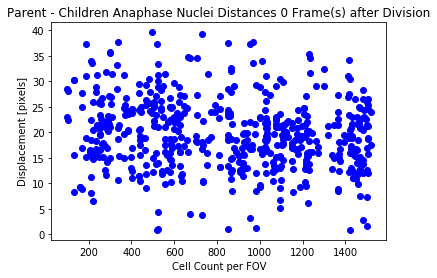

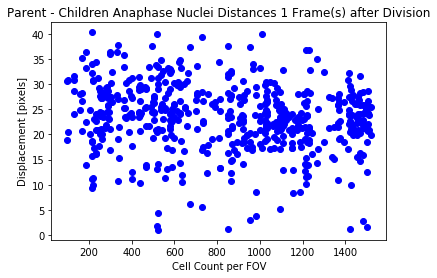

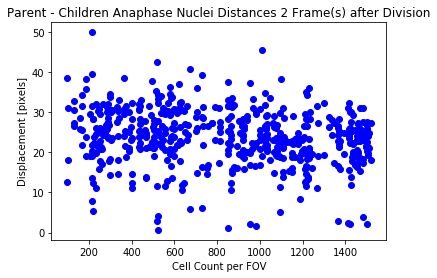

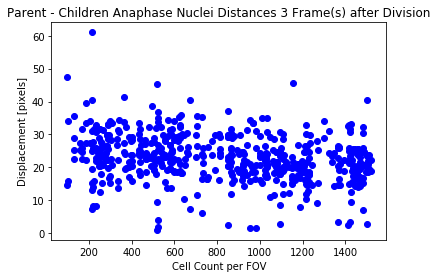

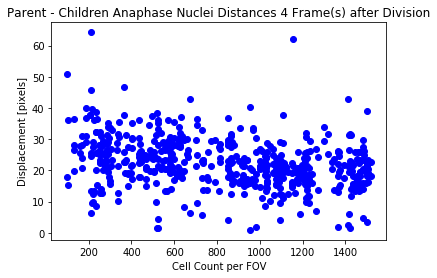

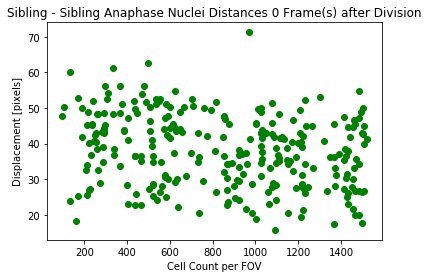

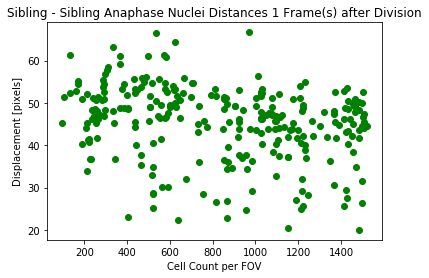

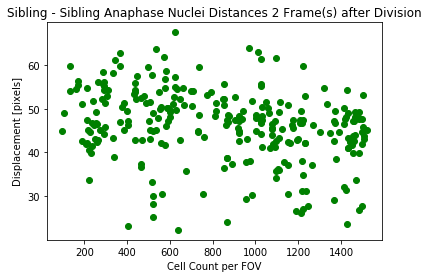

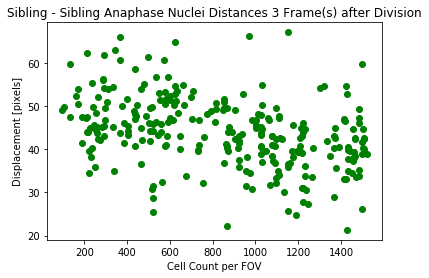

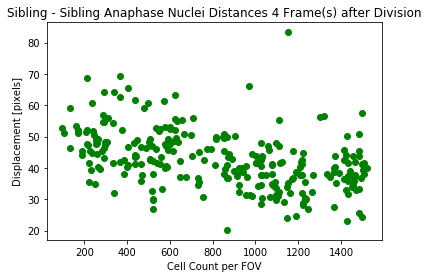

In [20]:
for i in range(5):
    plt.plot(cell_count, parent_child_1[i], "bo")
    plt.plot(cell_count, parent_child_2[i], "bo")
    plt.title("Parent - Children Anaphase Nuclei Distances {} Frame(s) after Division".format(i))
    plt.ylabel("Displacement [pixels]")
    plt.xlabel("Cell Count per FOV")
    #plt.savefig("/Volumes/lowegrp/Data/Kristina/Anaphase_Distances_All_Movies.png", bbox_inches = "tight")
    plt.show()
    plt.close()
        
for i in range(5):
    plt.plot(cell_count, sibling_sibling[i], "go")
    plt.title("Sibling - Sibling Anaphase Nuclei Distances {} Frame(s) after Division".format(i))
    plt.ylabel("Displacement [pixels]")
    plt.xlabel("Cell Count per FOV")
    #plt.savefig("/Volumes/lowegrp/Data/Kristina/Anaphase_Distances_All_Movies.png", bbox_inches = "tight")
    plt.show()
    plt.close()